ШИФТ конкурс "Займы"

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

In [2]:
df = pd.read_csv('C:/Users/ivans/Shift/lending/X_train.csv', index_col="index")
y = pd.read_csv('C:/Users/ivans/Shift/lending/y_train.csv', index_col="index")
df['loan_status']=y['loan_status']
df.head()

acc_now_delinq addr_state  annual_inc  chargeoff_within_12_mths  \
index                                                                    
0                 0.0         UT     80000.0                       0.0   
1                 0.0         CA     82000.0                       0.0   
2                 0.0         NV     46080.0                       0.0   
3                 0.0         AZ     30000.0                       0.0   
4                 0.0         OH     70000.0                       0.0   

       collections_12_mths_ex_med  delinq_2yrs    dti earliest_cr_line  \
index                                                                    
0                             0.0          0.0  30.49         Oct-1996   
1                             0.0          0.0   7.00         Mar-1993   
2                             0.0          1.0  17.32         Nov-2000   
3                             0.0          0.0   7.80         Jan-2010   
4                             0.0          0.0  13.36         Jan-2002   

      emp_length  fico_range_high  ...  pub_rec_bankruptcies      purpose  \
index                              ...                                      
0        4 years            689.0  ...                   1.0  credit_card   
1      10+ years            689.0  ...                   1.0  credit_card   
2        3 years            674.0  ...                   0.0  credit_card   
3       < 1 year            694.0  ...                   0.0          car   
4       < 1 year            674.0  ...                   0.0        other   

      revol_util  tax_liens        term                    title total_acc  \
index                                                                        
0          56.1%        0.0   36 months  Credit card refinancing      26.0   
1          88.3%        0.0   36 months  Credit card refinancing      11.0   
2          18.1%        0.0   36 months  Credit card refinancing      31.0   
3          33.4%        0.0   36 months            Car financing      24.0   
4          88.6%        0.0   60 months                    Other      16.0   

       verification_status  zip_code  loan_status  
index                                              
0          Source Verified     847xx            1  
1             Not Verified     900xx            0  
2          Source Verified     895xx            1  
3          Source Verified     853xx            0  
4             Not Verified     453xx            0  

[5 rows x 45 columns]

In [3]:
print(df.columns)

Index(['acc_now_delinq', 'addr_state', 'annual_inc',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'home_ownership', 'inq_last_12m',
       'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m',
       'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'revol_util', 'tax_liens', 'term', 'title', 'total_acc',
       'verification_status', 'zip_code', 'loan_status'],
      dtype='object')


In [4]:
df['fico_mean']=(df['fico_range_high']+df['fico_range_low'])/2
df['share_of_open_acc']=df['open_acc']/df['total_acc']
df['bad_rec']=(df['pub_rec']+df['pub_rec_bankruptcies'])/2
# df['number_of_rv_for_12m']=df['open_rv_24m']/2
df['credit_load']=df['installment']*12/df['annual_inc']
df['purpose'].replace(['credit_card', 'car', 'other', 'debt_consolidation',
       'major_purchase', 'small_business', 'home_improvement', 'moving',
       'medical', 'wedding', 'vacation', 'house', 'renewable_energy',
       'educational'], [1,2,3,4,5,6,7,8,9,10,11,12,13,14], inplace=True)
df['term'].replace([' 36 months', ' 60 months'], [1,2], inplace=True)
df['verification_status'].replace(['Source Verified', 'Not Verified', 'Verified'], [1,2,3], inplace=True)
df['home_ownership'].replace(['RENT', 'MORTGAGE', 'OWN', 'OTHER', 'ANY', 'NONE'], [1,2,3,2,2,2], inplace=True)
df['int_rate']=df['int_rate'].str.replace('%', '').astype(float)
df['revol_util']=df['revol_util'].str.replace('%', '').astype(float)
df['emp_length'].replace(['4 years', '10+ years', '3 years', '< 1 year', '5 years', '1 year',
       '7 years', '8 years', '2 years', '9 years', '6 years', np.nan], [4, 10,3,0.5,5,1,
       7,8,2,9, 6,10], inplace=True)
# df['year'] = pd.to_datetime(df['earliest_cr_line']).dt.year
df.loc[df['annual_inc']>160000, 'annual_inc']=df['annual_inc'].median()
# df = pd.get_dummies(data=df, columns=['verification_status'])

In [6]:
data=pd.crosstab(df['verification_status'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data

loan_status  verification_status         0         1
1                              2  0.850939  0.149061
0                              1  0.799828  0.200172
2                              3  0.768710  0.231290

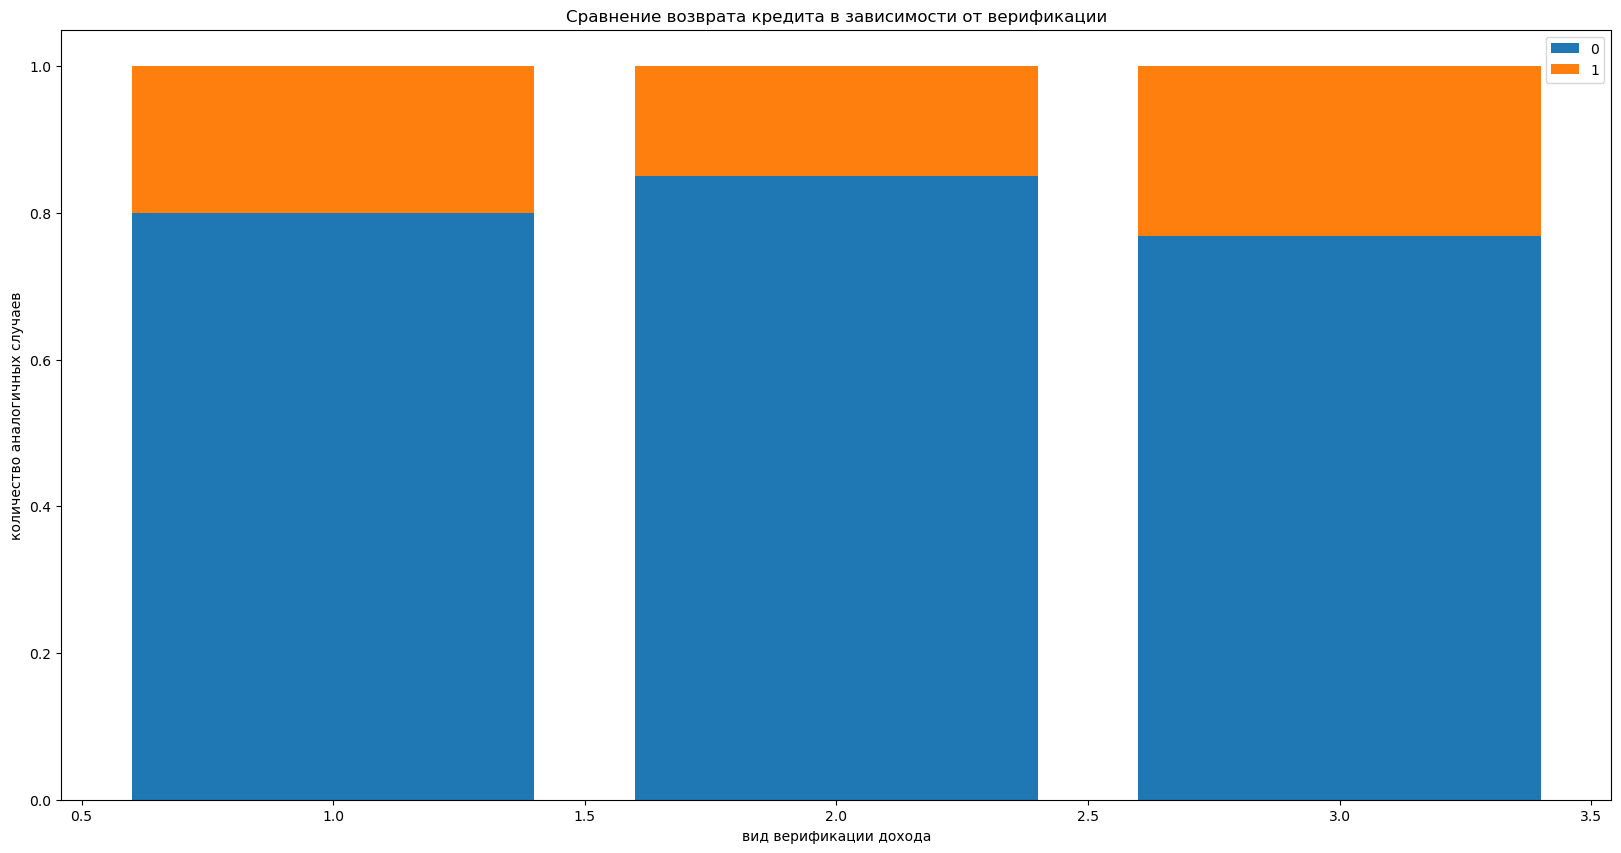

In [7]:
plt.figure(figsize=(20,10))
plt.bar(data['verification_status'], data[0], label='0')
plt.bar(data['verification_status'], data[1], bottom=data[0], label='1')
plt.title('Сравнение возврата кредита в зависимости от верификации')
plt.xlabel('вид верификации дохода')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks()
plt.show()

In [8]:
df['earliest_cr_line']

index
0          Oct-1996
1          Mar-1993
2          Nov-2000
3          Jan-2010
4          Jan-2002
             ...   
1199856    Feb-2002
1199857    Jan-2002
1199858    Nov-2002
1199859    Nov-1991
1199860    Sep-2007
Name: earliest_cr_line, Length: 1199861, dtype: object

In [9]:
df['year'] = pd.to_datetime(df['issue_d']).dt.year
df['year']

index
0          2016
1          2017
2          2016
3          2015
4          2017
           ... 
1199856    2012
1199857    2013
1199858    2015
1199859    2012
1199860    2015
Name: year, Length: 1199861, dtype: int64

In [10]:
df['month'] = pd.to_datetime(df['issue_d']).dt.month
df['month']

index
0           4
1           9
2           8
3           8
4           9
           ..
1199856     6
1199857    11
1199858    12
1199859     6
1199860     5
Name: month, Length: 1199861, dtype: int64

In [11]:
# df.loc[df['open_rv_24m']>8, 'open_rv_24m']=df['open_rv_24m'].median()

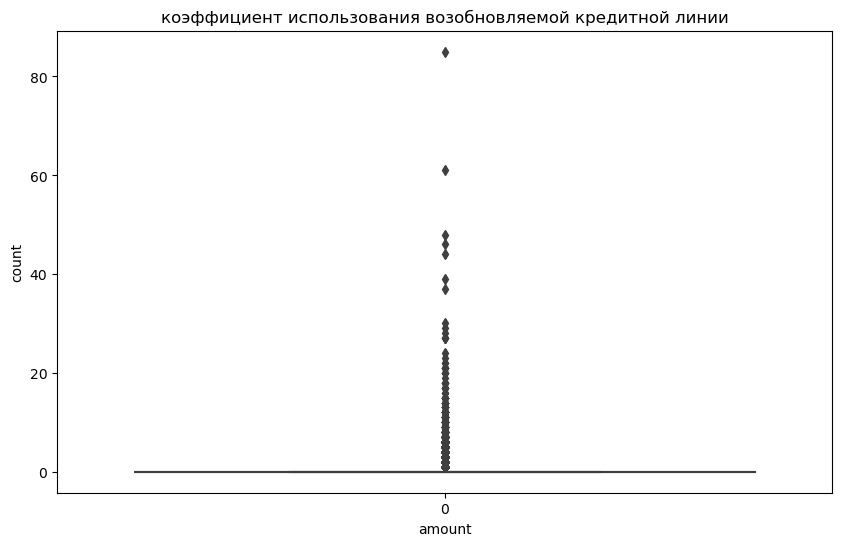

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(df['tax_liens'],whis=1.5)
plt.title('коэффициент использования возобновляемой кредитной линии')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

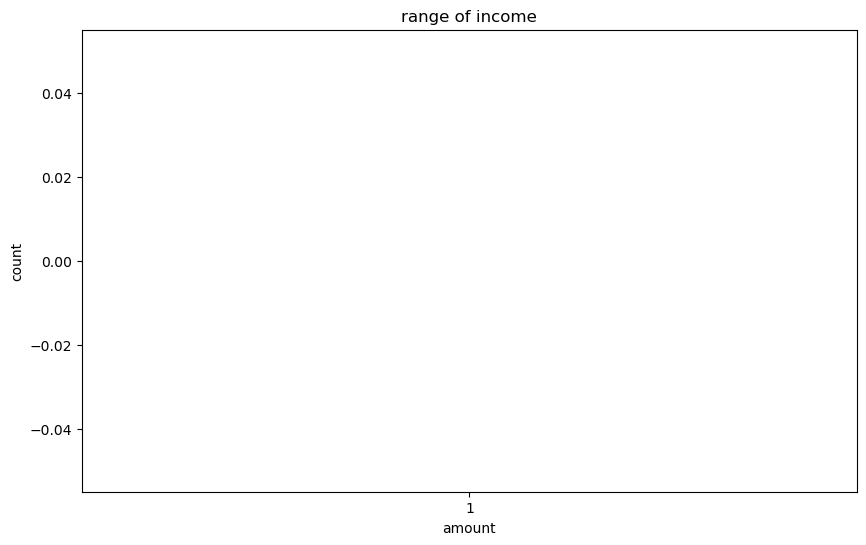

In [13]:
plt.figure(figsize=(10,6))
plt.boxplot(df['tax_liens'], showfliers=False)
plt.title('range of income')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

In [14]:
data=df.groupby('month')['loan_status'].agg(count='count').reset_index().sort_values(by='month')
data

month   count
0       1   99064
1       2   89421
2       3  111869
3       4  102579
4       5   97915
5       6   91947
6       7  113755
7       8  101633
8       9   81745
9      10  116379
10     11  100204
11     12   93350

In [15]:
data=pd.crosstab(df['year'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data

loan_status  year         0         1
13           2020  0.986609  0.013391
2            2009  0.874960  0.125040
3            2010  0.872781  0.127219
4            2011  0.850014  0.149986
1            2008  0.844575  0.155425
6            2013  0.843646  0.156354
5            2012  0.836851  0.163149
12           2019  0.826232  0.173768
7            2014  0.822944  0.177056
0            2007  0.808642  0.191358
9            2016  0.803857  0.196143
8            2015  0.801985  0.198015
10           2017  0.793070  0.206930
11           2018  0.765586  0.234414

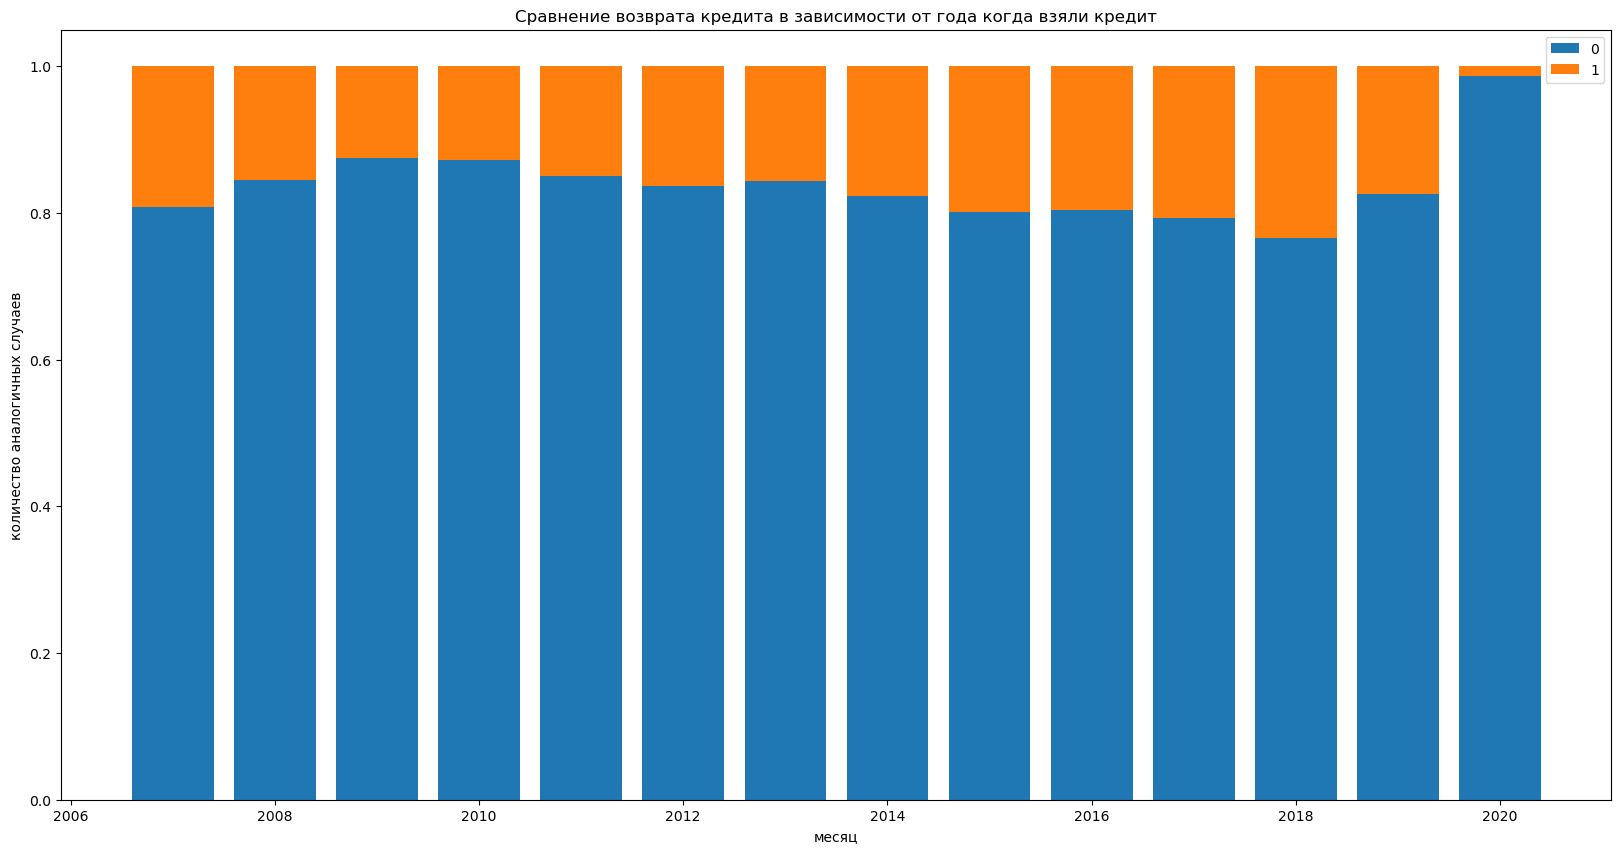

In [16]:
plt.figure(figsize=(20,10))
plt.bar(data['year'], data[0], label='0')
plt.bar(data['year'], data[1], bottom=data[0], label='1')
plt.title('Сравнение возврата кредита в зависимости от года когда взяли кредит')
plt.xlabel('месяц')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks()
plt.show()

In [17]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [18]:
plt.style.use('fivethirtyeight')

In [19]:
data=df.groupby('month')['loan_status'].agg(count='count').reset_index().sort_values(by='month')
data

month   count
0       1   99064
1       2   89421
2       3  111869
3       4  102579
4       5   97915
5       6   91947
6       7  113755
7       8  101633
8       9   81745
9      10  116379
10     11  100204
11     12   93350

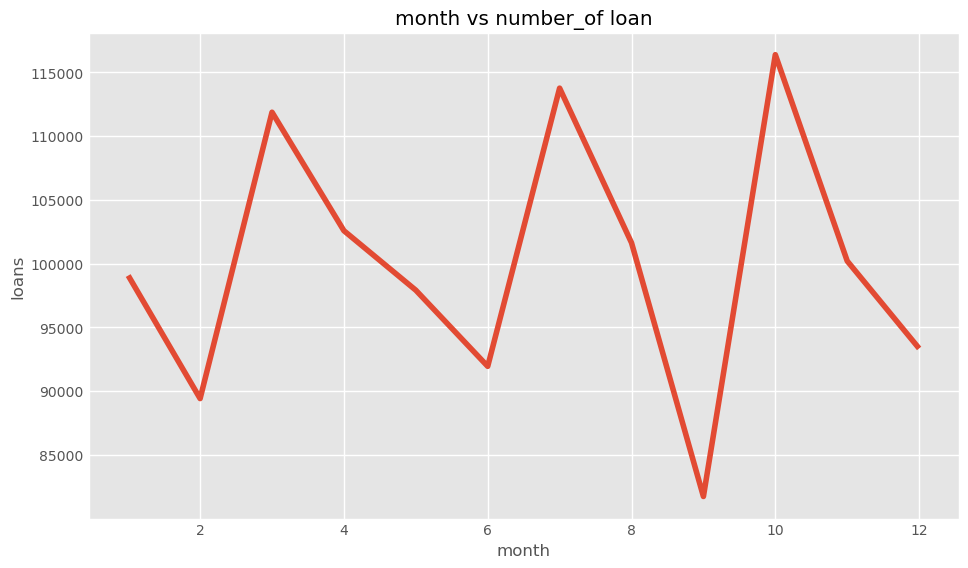

In [20]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(data['month'], data['count'])
plt.title('month vs number_of loan')
plt.xlabel('month')
plt.ylabel('loans')
plt.show()

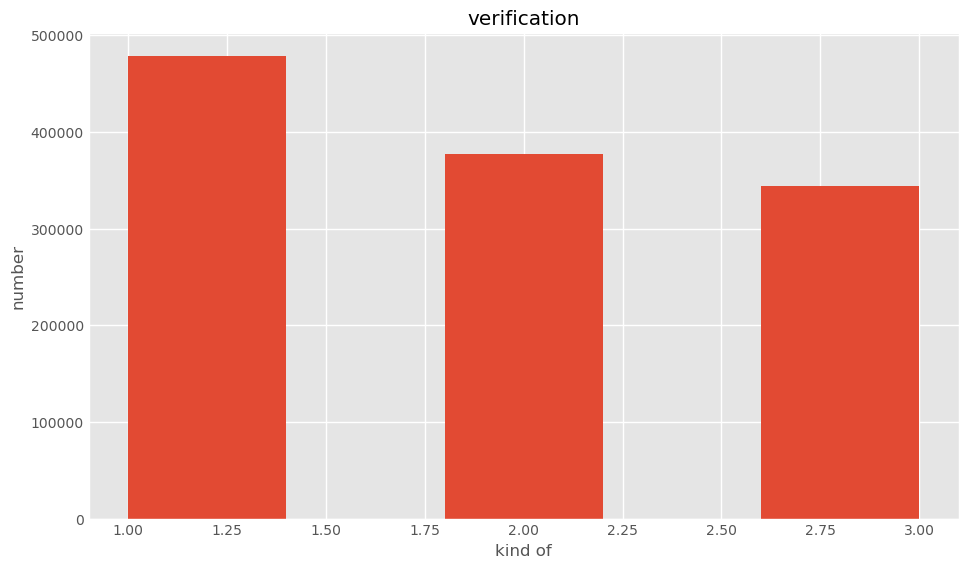

In [21]:
plt.figure(figsize=(10,6))
plt.hist(df['verification_status'], bins=5)
plt.title('verification')
plt.xlabel('kind of')
plt.ylabel('number')
plt.show()

In [25]:
zero_data_emp=df['emp_length'].isnull().sum()
zero_data_emp

0

In [26]:
unique_values=df['emp_length'].value_counts().reset_index().sort_values(by='emp_length')
unique_values
# unique_values=df.groupby('emp_length')['verification_status'].agg(count='Count').reset_index().sort_values('emp_length')

index  emp_length
10    9.0       44029
9     7.0       51168
8     8.0       51577
7     6.0       55398
6     4.0       72998
5     5.0       75440
4     1.0       79958
3     0.5       94486
2     3.0       96813
1     2.0      109336
0    10.0      468658

In [27]:
df['emp_length'].replace(['4 years', '10+ years', '3 years', '< 1 year', '5 years', '1 year',
       '7 years', '8 years', '2 years', '9 years', '6 years', np.nan], [4, 10,3,0.5,5,1,
       7,8,2,9, 6,10], inplace=True)
df['emp_length']

index
0           4.0
1          10.0
2           3.0
3           0.5
4           0.5
           ... 
1199856     4.0
1199857     3.0
1199858     8.0
1199859     5.0
1199860     2.0
Name: emp_length, Length: 1199861, dtype: float64

In [28]:
zero_data_emp=df['emp_length'].isnull().sum()
zero_data_emp

0

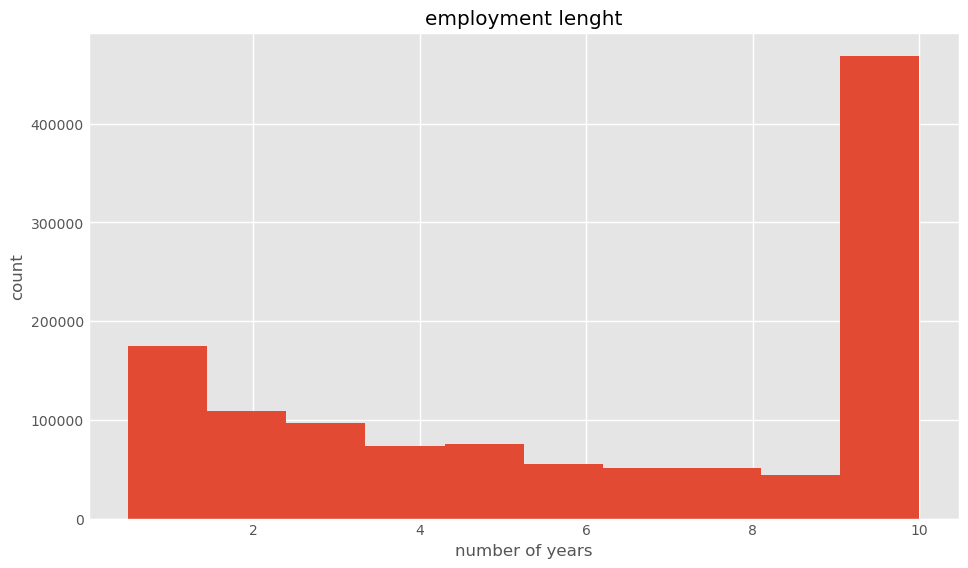

In [29]:
plt.figure(figsize=(10,6))
plt.hist(df['emp_length'], bins=10)
plt.title('employment lenght')
plt.xlabel('number of years')
plt.ylabel('count')
plt.show()

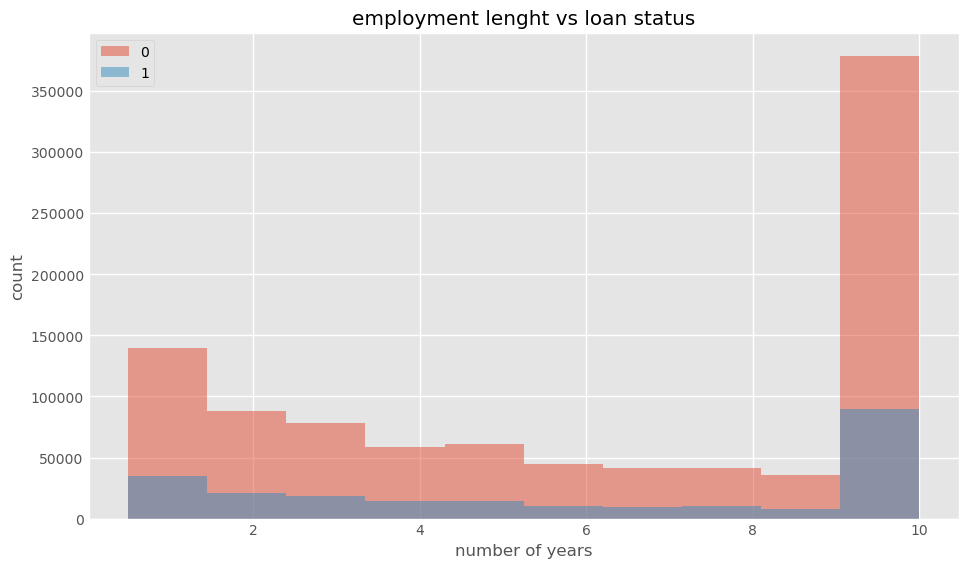

In [30]:
plt.figure(figsize=(10,6))
plt.hist(df['emp_length'][df['loan_status']==0], alpha=0.5, label='0')
plt.hist(df['emp_length'][df['loan_status']==1], alpha=0.5, label='1')
plt.title('employment lenght vs loan status')
plt.xlabel('number of years')
plt.ylabel('count')
plt.legend()
plt.show()

In [31]:
data_new=df.groupby('emp_length')['loan_status'].sum().reset_index()
data_new.head()                                               

emp_length  loan_status
0         0.5        18978
1         1.0        16055
2         2.0        21066
3         3.0        18882
4         4.0        14151

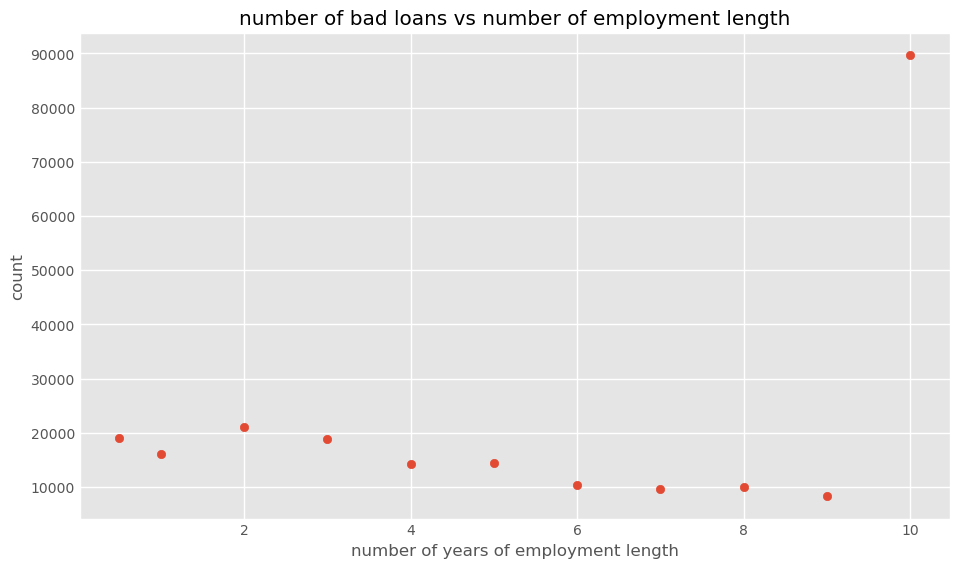

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(data_new['emp_length'], data_new['loan_status'])
plt.title('number of bad loans vs number of employment length')
plt.xlabel('number of years of employment length')
plt.ylabel('count')
plt.show()

In [33]:
df.columns

Index(['acc_now_delinq', 'addr_state', 'annual_inc',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'home_ownership', 'inq_last_12m',
       'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m',
       'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'revol_util', 'tax_liens', 'term', 'title', 'total_acc',
       'verification_status', 'zip_code', 'loan_status', 'fico_mean',
       'share_of_open_acc', 'bad_rec', 'credit_load', 'year', 'month'],
      dtype='object')

In [34]:
df['int_rate']

index
0          12.99
1          10.42
2           8.99
3          11.53
4          26.30
           ...  
1199856    15.31
1199857     6.03
1199858    11.99
1199859    22.78
1199860    21.67
Name: int_rate, Length: 1199861, dtype: float64

In [36]:
df['int_rate']

index
0          12.99
1          10.42
2           8.99
3          11.53
4          26.30
           ...  
1199856    15.31
1199857     6.03
1199858    11.99
1199859    22.78
1199860    21.67
Name: int_rate, Length: 1199861, dtype: float64

In [38]:
df['revol_util']

index
0          56.1
1          88.3
2          18.1
3          33.4
4          88.6
           ... 
1199856    82.1
1199857    82.3
1199858     6.0
1199859    76.2
1199860    37.3
Name: revol_util, Length: 1199861, dtype: float64

In [39]:
data1=df['int_rate'][df['loan_status']==1]
data2=df['int_rate'][df['loan_status']==0]

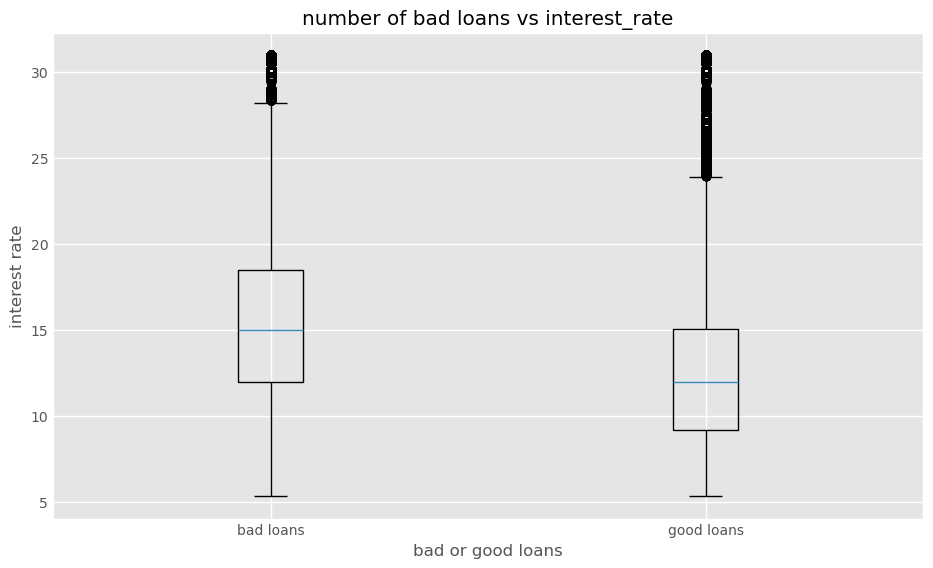

In [40]:
plt.figure(figsize=(10,6))
plt.boxplot([data1, data2])
plt.title('number of bad loans vs interest_rate')
plt.xlabel('bad or good loans')
plt.ylabel('interest rate')
plt.xticks([1,2], ['bad loans', 'good loans'])
plt.show()

In [41]:
data_d=df['purpose'].value_counts().reset_index()
data_d

index  purpose
0       4   684522
1       1   268419
2       7    78972
3       3    73218
4       5    26885
5       9    14327
6       6    13462
7       2    13214
8      11     8686
9       8     8423
10     12     7143
11     10     1555
12     13      827
13     14      208

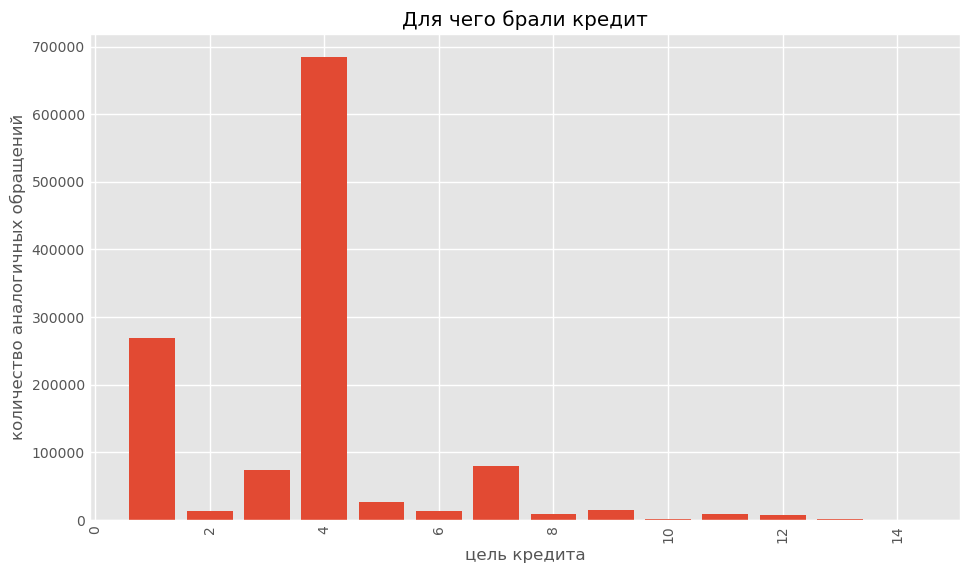

In [42]:
plt.figure(figsize=(10,6))
plt.bar(data_d['index'], data_d['purpose'])
plt.title('Для чего брали кредит')
plt.xlabel('цель кредита')
plt.ylabel('количество аналогичных обращений')
plt.xticks(rotation=90)
plt.show()

In [43]:
data=pd.crosstab(df['purpose'], df['loan_status']).reset_index().sort_values(by=1)
data

loan_status  purpose       0       1
13                14     174      34
12                13     652     175
9                 10    1359     196
10                11    7165    1521
11                12    5577    1566
7                  8    6612    1811
1                  2   11371    1843
8                  9   11459    2868
5                  6    9641    3821
4                  5   21889    4996
6                  7   65459   13513
2                  3   58743   14475
0                  1  223480   44939
3                  4  544672  139850

In [44]:
data=pd.crosstab(df['addr_state'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data

loan_status addr_state         0         1
12                  IA  1.000000  0.000000
46                  VT  0.871058  0.128942
21                  ME  0.867727  0.132273
7                   DC  0.863427  0.136573
37                  OR  0.858306  0.141694
49                  WV  0.850083  0.149917
30                  NH  0.848279  0.151721
26                  MT  0.848002  0.151998
47                  WA  0.847958  0.152042
5                   CO  0.846480  0.153520
40                  SC  0.845398  0.154602
50                  WY  0.844821  0.155179
13                  ID  0.843799  0.156201
16                  KS  0.837394  0.162606
44                  UT  0.834692  0.165308
39                  RI  0.828609  0.171391
6                   CT  0.824776  0.175224
14                  IL  0.824636  0.175364
28                  ND  0.822401  0.177599
0                   AK  0.821190  0.178810
48                  WI  0.818343  0.181657
10                  GA  0.817621  0.182379
8                   DE  0.814892  0.185108
19                  MA  0.813196  0.186804
3                   AZ  0.812186  0.187814
35                  OH  0.809707  0.190293
23                  MN  0.809360  0.190640
45                  VA  0.809112  0.190888
43                  TX  0.808295  0.191705
22                  MI  0.807612  0.192388
4                   CA  0.807021  0.192979
17                  KY  0.804784  0.195216
27                  NC  0.803393  0.196607
38                  PA  0.802259  0.197741
41                  SD  0.800655  0.199345
11                  HI  0.800476  0.199524
15                  IN  0.800278  0.199722
32                  NM  0.799217  0.200783
24                  MO  0.797995  0.202005
31                  NJ  0.797843  0.202157
42                  TN  0.797197  0.202803
20                  MD  0.791106  0.208894
33                  NV  0.789268  0.210732
9                   FL  0.787080  0.212920
34                  NY  0.786819  0.213181
18                  LA  0.779900  0.220100
36                  OK  0.778833  0.221167
1                   AL  0.776341  0.223659
29                  NE  0.771104  0.228896
2                   AR  0.763776  0.236224
25                  MS  0.752992  0.247008

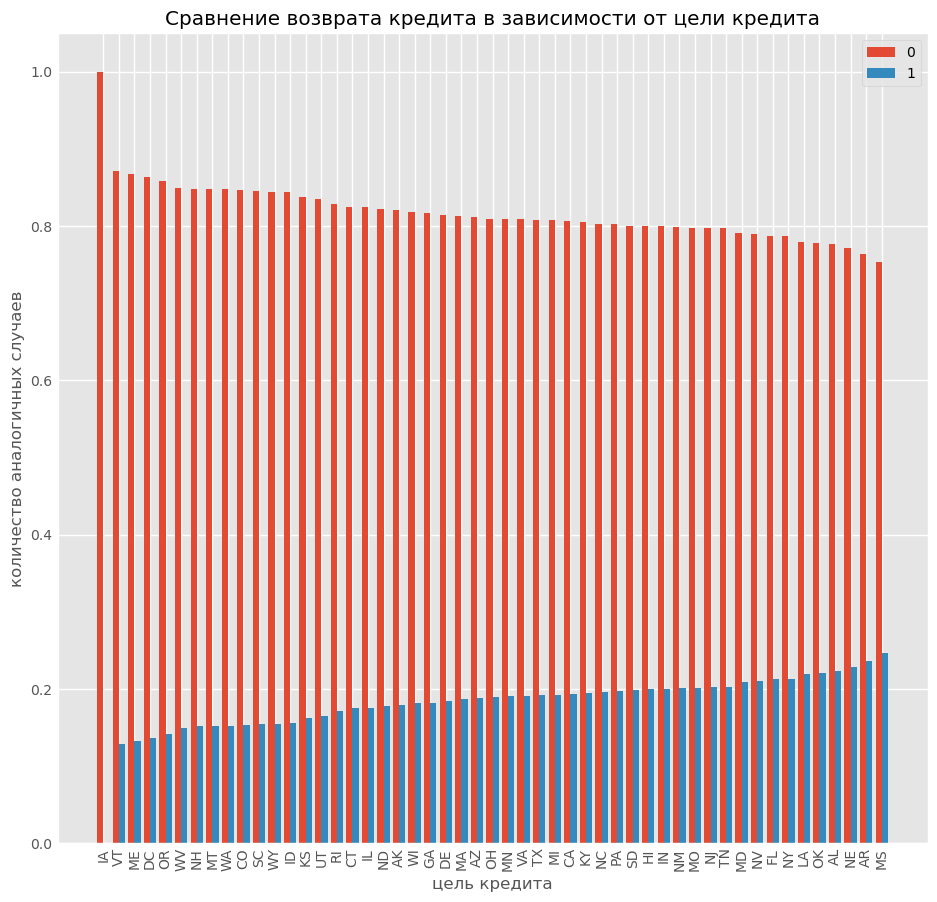

In [46]:
plt.figure(figsize=(10,10))

n_ticks=np.arange(len(data[0]))
offset=0.2
w=0.4
plt.bar(n_ticks-offset, data[0], width=w, label='0')
plt.bar(n_ticks+offset, data[1], width=w, label='1')
plt.title('Сравнение возврата кредита в зависимости от цели кредита')
plt.xlabel('цель кредита')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks(n_ticks, data['addr_state'], rotation=90)
plt.show()

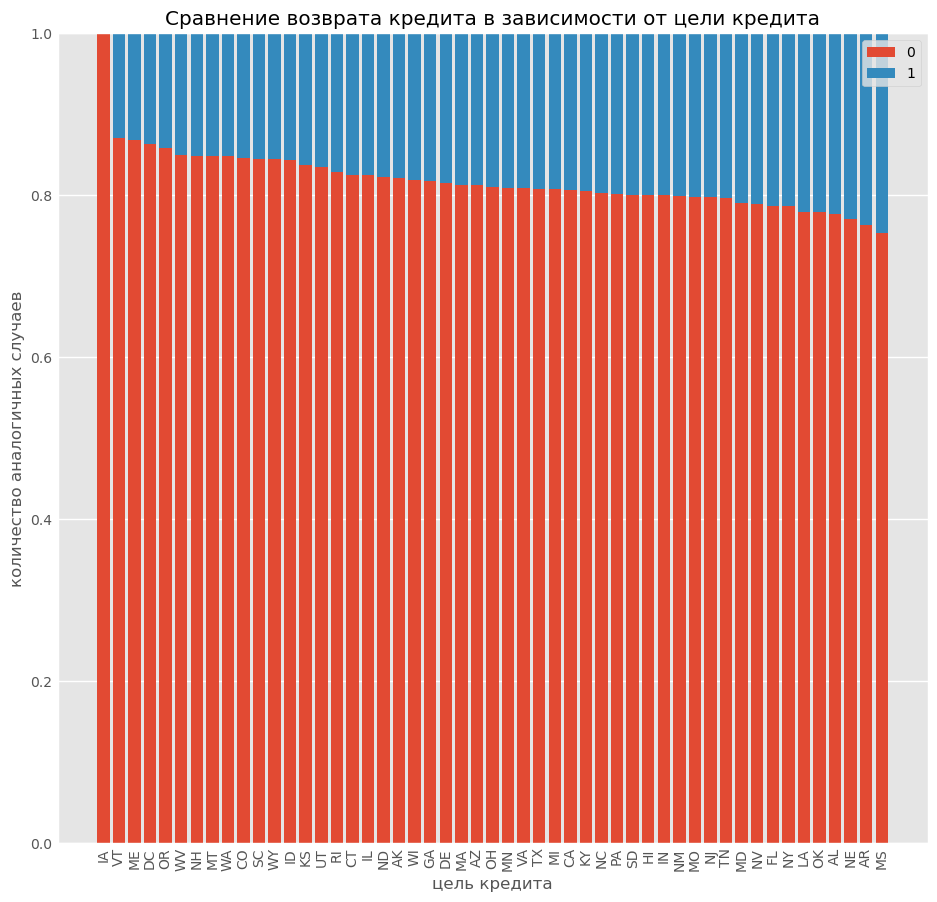

In [48]:
plt.figure(figsize=(10,10))
plt.bar(data['addr_state'], data[0], label='0')
plt.bar(data['addr_state'], data[1], bottom=data[0], label='1')
plt.title('Сравнение возврата кредита в зависимости от цели кредита')
plt.xlabel('цель кредита')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [49]:
data=pd.crosstab(df['purpose'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data

loan_status  purpose         0         1
9                 10  0.873955  0.126045
1                  2  0.860527  0.139473
13                14  0.836538  0.163462
0                  1  0.832579  0.167421
6                  7  0.828889  0.171111
10                11  0.824891  0.175109
4                  5  0.814171  0.185829
2                  3  0.802303  0.197697
8                  9  0.799819  0.200181
3                  4  0.795697  0.204303
12                13  0.788392  0.211608
7                  8  0.784993  0.215007
11                12  0.780764  0.219236
5                  6  0.716164  0.283836

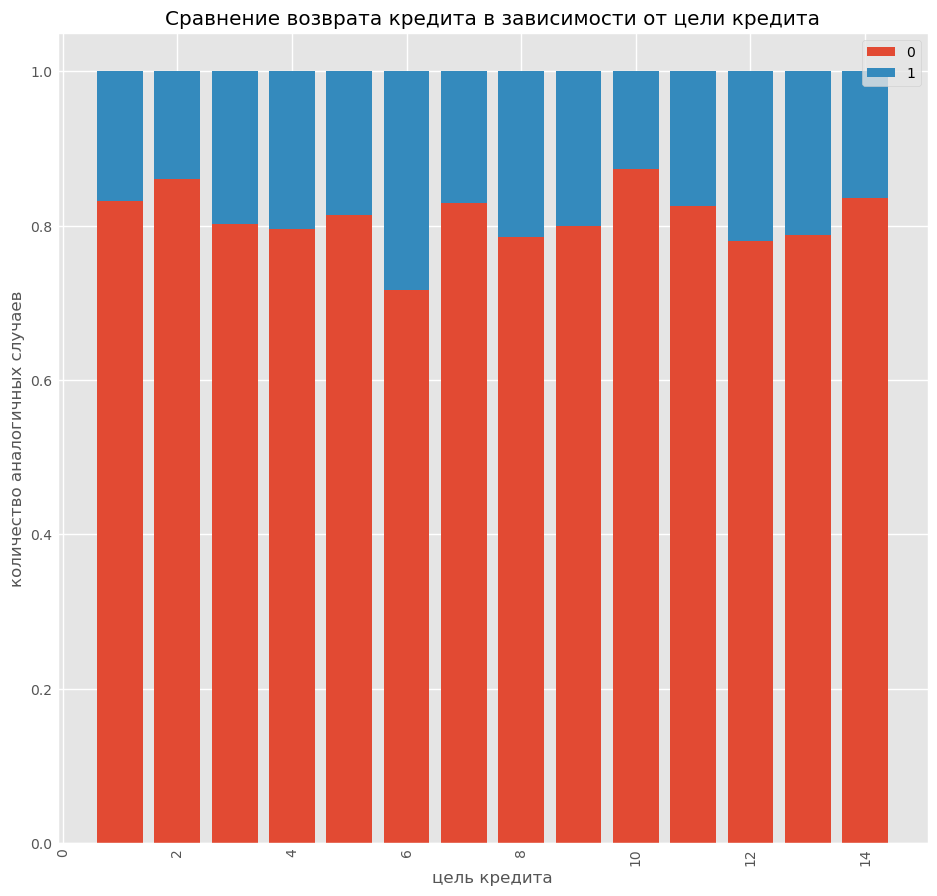

In [50]:
plt.figure(figsize=(10,10))
plt.bar(data['purpose'], data[0], label='0')
plt.bar(data['purpose'], data[1], bottom=data[0], label='1')
plt.title('Сравнение возврата кредита в зависимости от цели кредита')
plt.xlabel('цель кредита')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [51]:
data_else=pd.crosstab(df['emp_length'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data_else

loan_status  emp_length         0         1
9                   9.0  0.812941  0.187059
6                   6.0  0.812268  0.187732
7                   7.0  0.811425  0.188575
10                 10.0  0.808498  0.191502
5                   5.0  0.808086  0.191914
2                   2.0  0.807328  0.192672
8                   8.0  0.806813  0.193187
4                   4.0  0.806145  0.193855
3                   3.0  0.804964  0.195036
1                   1.0  0.799207  0.200793
0                   0.5  0.799145  0.200855

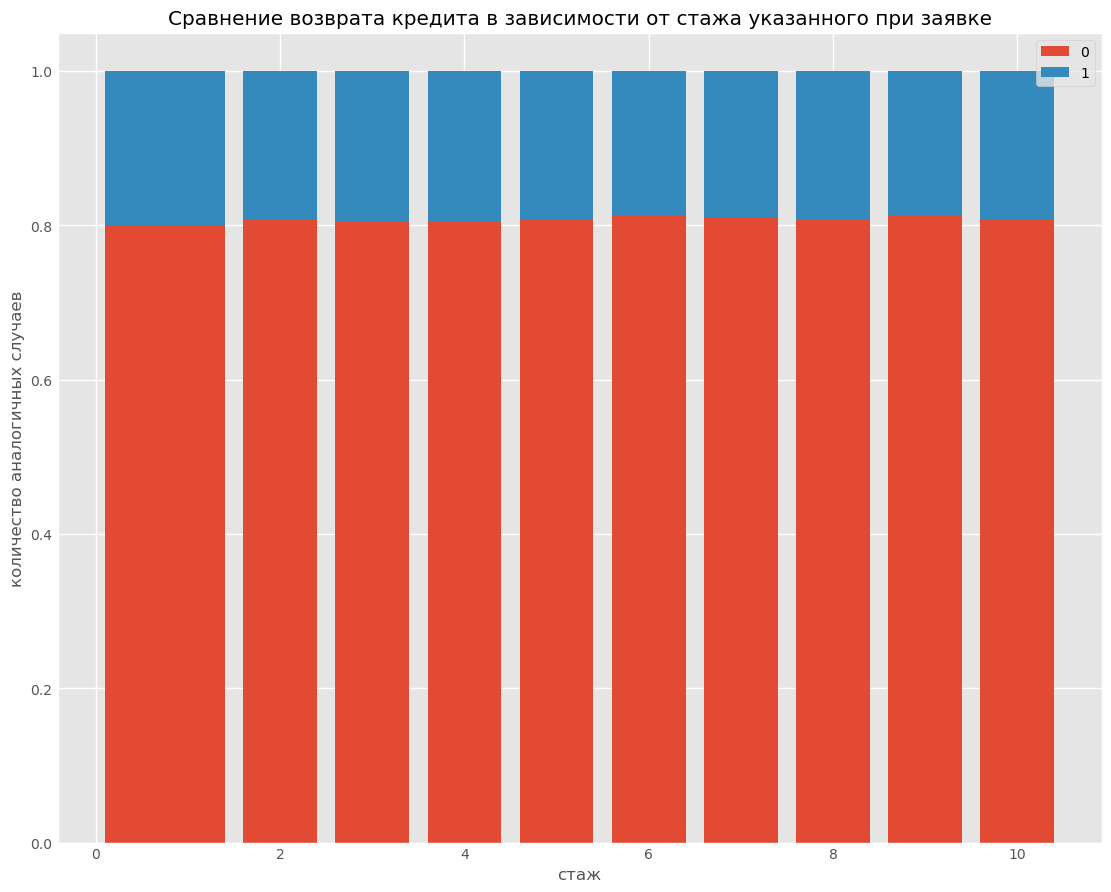

In [52]:
plt.figure(figsize=(12,10))
plt.bar(data_else['emp_length'], data_else[0], label='0')
plt.bar(data_else['emp_length'], data_else[1], bottom=data_else[0], label='1')
plt.title('Сравнение возврата кредита в зависимости от стажа указанного при заявке')
plt.xlabel('стаж')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks()
plt.show()

In [53]:
data=pd.crosstab(df['addr_state'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data

loan_status addr_state         0         1
12                  IA  1.000000  0.000000
46                  VT  0.871058  0.128942
21                  ME  0.867727  0.132273
7                   DC  0.863427  0.136573
37                  OR  0.858306  0.141694
49                  WV  0.850083  0.149917
30                  NH  0.848279  0.151721
26                  MT  0.848002  0.151998
47                  WA  0.847958  0.152042
5                   CO  0.846480  0.153520
40                  SC  0.845398  0.154602
50                  WY  0.844821  0.155179
13                  ID  0.843799  0.156201
16                  KS  0.837394  0.162606
44                  UT  0.834692  0.165308
39                  RI  0.828609  0.171391
6                   CT  0.824776  0.175224
14                  IL  0.824636  0.175364
28                  ND  0.822401  0.177599
0                   AK  0.821190  0.178810
48                  WI  0.818343  0.181657
10                  GA  0.817621  0.182379
8                   DE  0.814892  0.185108
19                  MA  0.813196  0.186804
3                   AZ  0.812186  0.187814
35                  OH  0.809707  0.190293
23                  MN  0.809360  0.190640
45                  VA  0.809112  0.190888
43                  TX  0.808295  0.191705
22                  MI  0.807612  0.192388
4                   CA  0.807021  0.192979
17                  KY  0.804784  0.195216
27                  NC  0.803393  0.196607
38                  PA  0.802259  0.197741
41                  SD  0.800655  0.199345
11                  HI  0.800476  0.199524
15                  IN  0.800278  0.199722
32                  NM  0.799217  0.200783
24                  MO  0.797995  0.202005
31                  NJ  0.797843  0.202157
42                  TN  0.797197  0.202803
20                  MD  0.791106  0.208894
33                  NV  0.789268  0.210732
9                   FL  0.787080  0.212920
34                  NY  0.786819  0.213181
18                  LA  0.779900  0.220100
36                  OK  0.778833  0.221167
1                   AL  0.776341  0.223659
29                  NE  0.771104  0.228896
2                   AR  0.763776  0.236224
25                  MS  0.752992  0.247008

In [54]:
data_33=pd.crosstab(df['verification_status'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data_33

loan_status  verification_status         0         1
1                              2  0.850939  0.149061
0                              1  0.799828  0.200172
2                              3  0.768710  0.231290

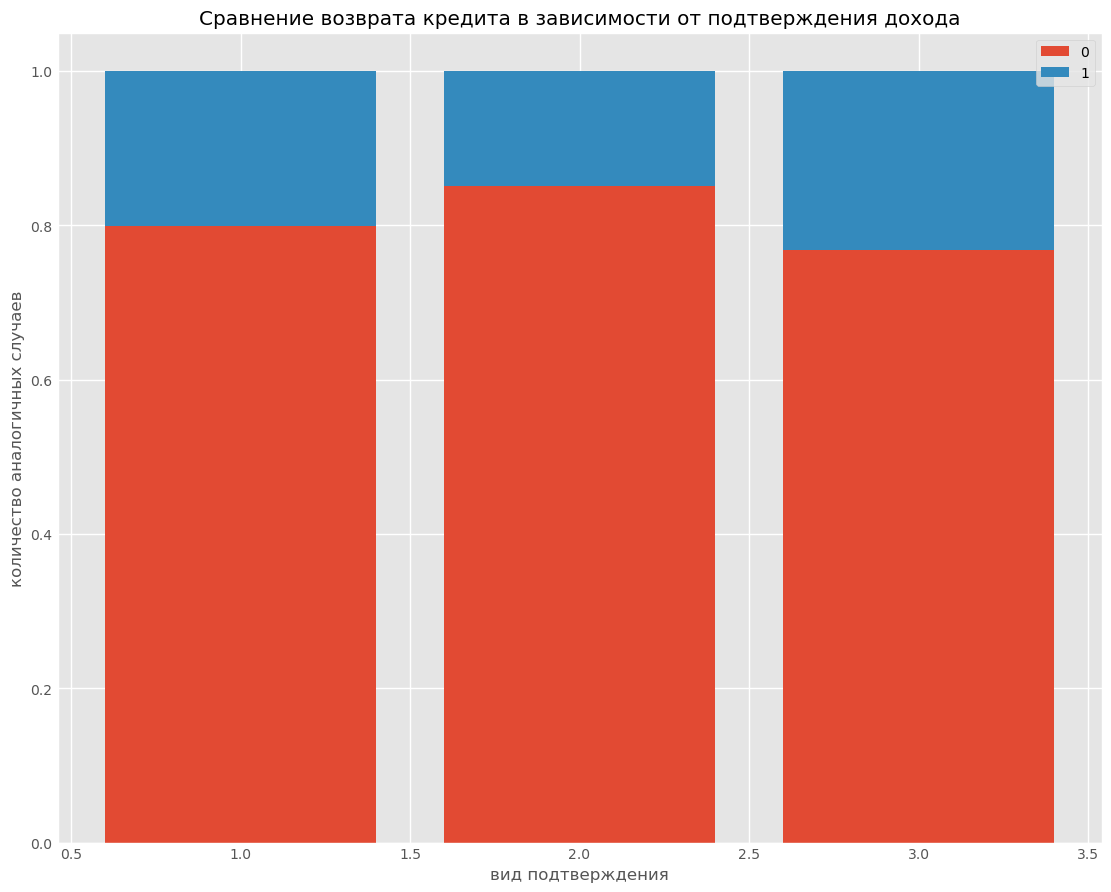

In [55]:
plt.figure(figsize=(12,10))
plt.bar(data_33['verification_status'], data_33[0], label='0')
plt.bar(data_33['verification_status'], data_33[1], bottom=data_33[0], label='1')
plt.title('Сравнение возврата кредита в зависимости от подтверждения дохода')
plt.xlabel('вид подтверждения')
plt.ylabel('количество аналогичных случаев')
plt.legend()
plt.xticks()
plt.show()

In [56]:
data=df['loan_status'].value_counts()
data

0    968253
1    231608
Name: loan_status, dtype: int64

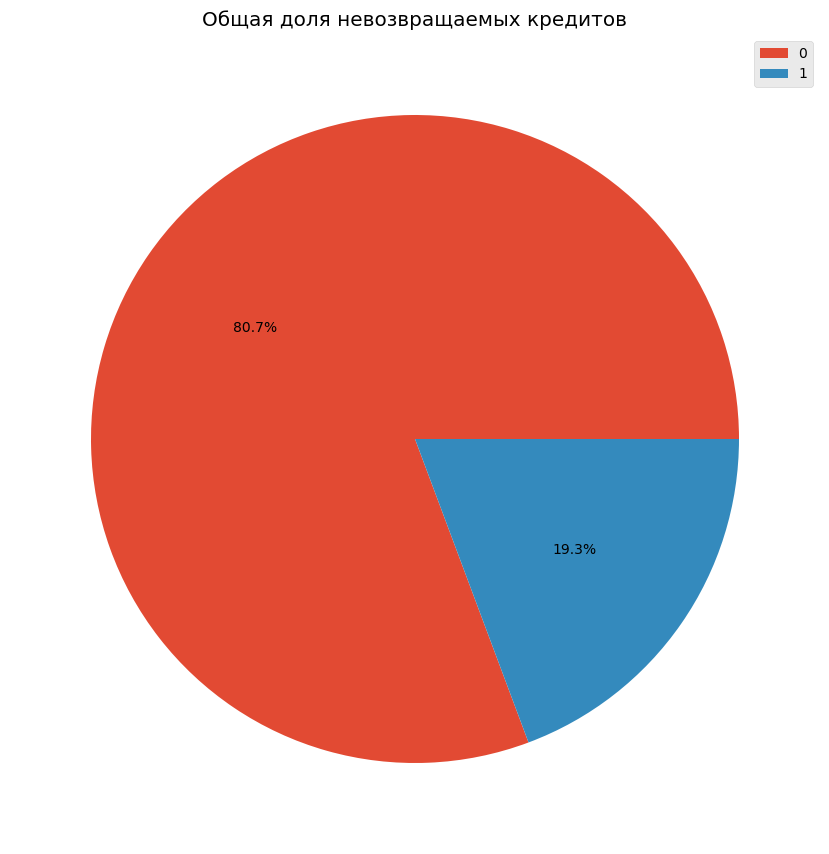

In [57]:
plt.figure(figsize=(10,10))
plt.pie(data, autopct='%1.1f%%')
plt.title('Общая доля невозвращаемых кредитов')
plt.legend(data.index)
plt.show()

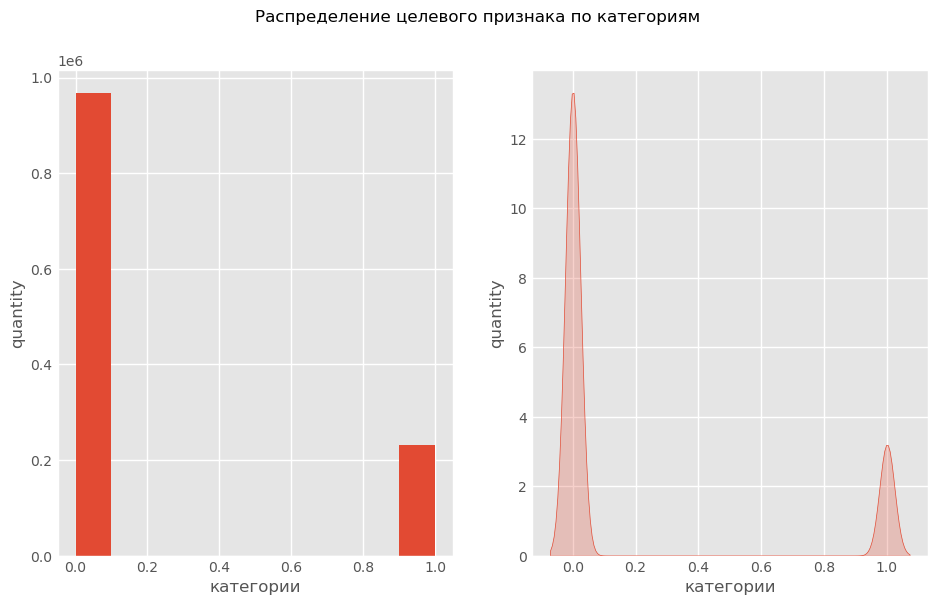

In [58]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.hist(df['loan_status'], bins=10)
plt.xlabel('категории')
plt.ylabel('quantity')

plt.subplot(122)
sns.kdeplot(df['loan_status'], fill=True)
plt.xlabel('категории')
plt.ylabel('quantity')

plt.suptitle ('Распределение целевого признака по категориям')
plt.show()

In [59]:
target_mean=round(df['loan_status'].mean(),2)
target_median=df['loan_status'].median()
target_mode=df['loan_status'].mode()[0]
print(target_mean)
print(target_median)
print(target_mode)

0.19
0.0
0


##### Анализ Количественных непрерывных данных

In [60]:
df_num_unlim=df[['annual_inc','dti','funded_amnt','installment','int_rate','loan_amnt','percent_bc_gt_75','revol_util']]
df_num_unlim.head()

annual_inc    dti  funded_amnt  installment  int_rate  loan_amnt  \
index                                                                     
0         80000.0  30.49      16000.0       539.03     12.99    16000.0   
1         82000.0   7.00       6600.0       214.27     10.42     6600.0   
2         46080.0  17.32      10000.0       317.96      8.99    10000.0   
3         30000.0   7.80       3000.0        98.98     11.53     3000.0   
4         70000.0  13.36      20000.0       602.37     26.30    20000.0   

       percent_bc_gt_75  revol_util  
index                                
0                 100.0        56.1  
1                 100.0        88.3  
2                   0.0        18.1  
3                   0.0        33.4  
4                 100.0        88.6

array([[<Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'dti'}>,
        <Axes: title={'center': 'funded_amnt'}>],
       [<Axes: title={'center': 'installment'}>,
        <Axes: title={'center': 'int_rate'}>,
        <Axes: title={'center': 'loan_amnt'}>],
       [<Axes: title={'center': 'percent_bc_gt_75'}>,
        <Axes: title={'center': 'revol_util'}>, <Axes: >]], dtype=object)

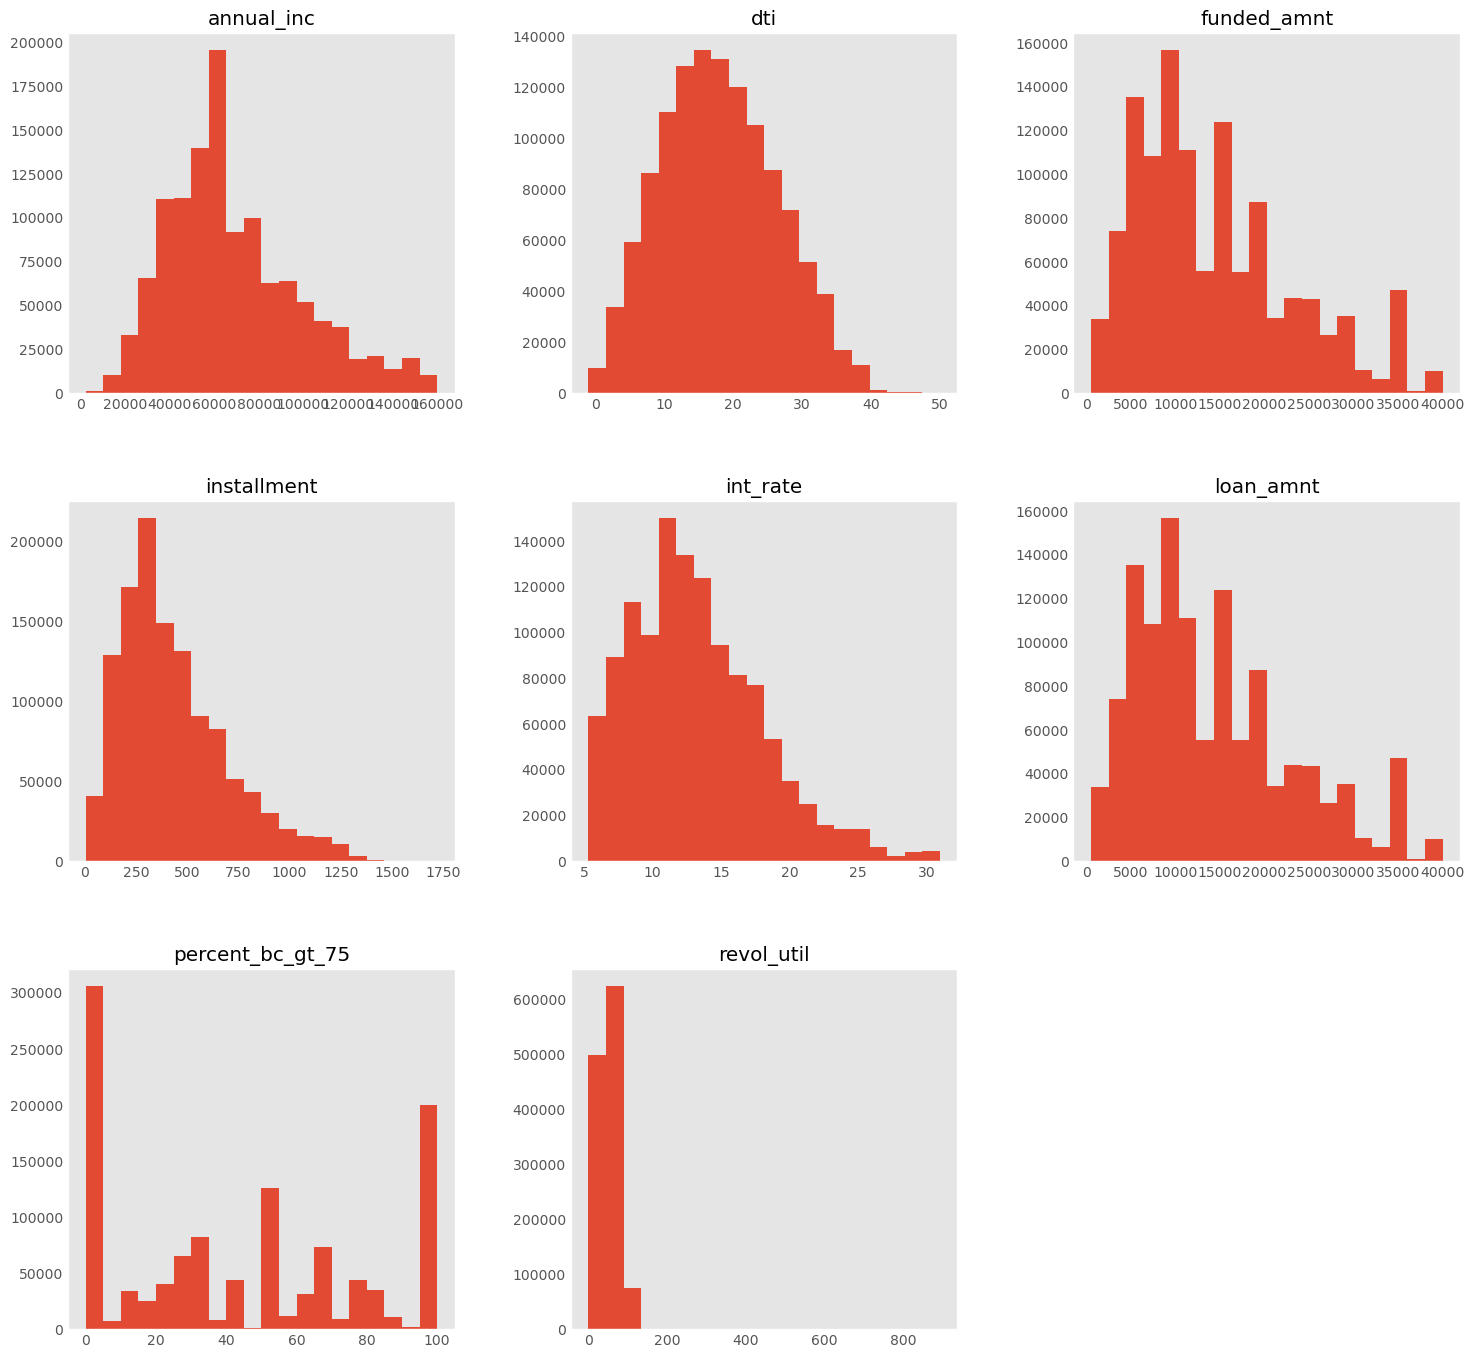

In [61]:
df_num_unlim.hist(figsize=(16,16), bins=20, grid=False)

In [62]:
df['annual_inc'].head()

index
0    80000.0
1    82000.0
2    46080.0
3    30000.0
4    70000.0
Name: annual_inc, dtype: float64

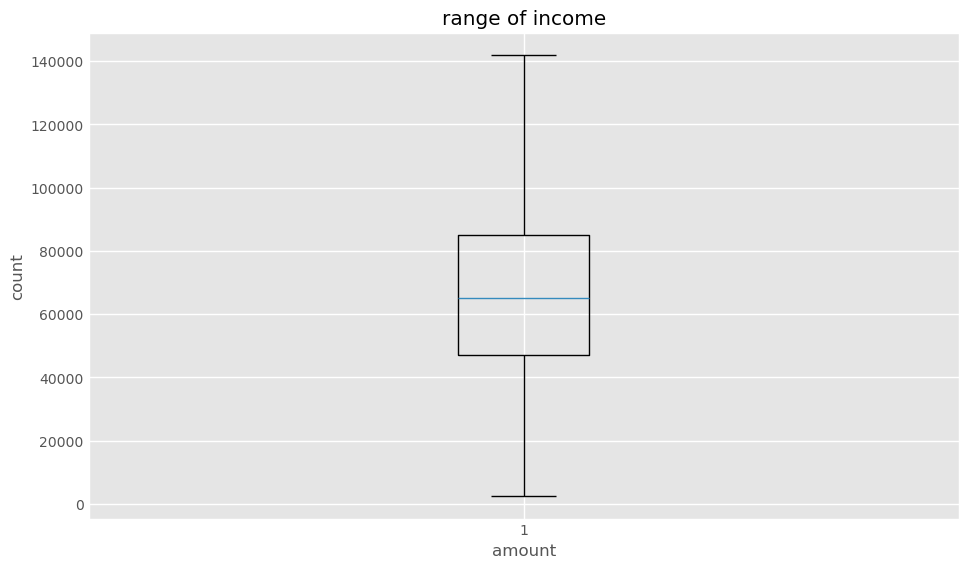

In [63]:
plt.figure(figsize=(10,6))
plt.boxplot(df['annual_inc'], showfliers=False)
plt.title('range of income')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

In [64]:
df.loc[df['annual_inc']>160000, 'annual_inc']=df['annual_inc'].median()

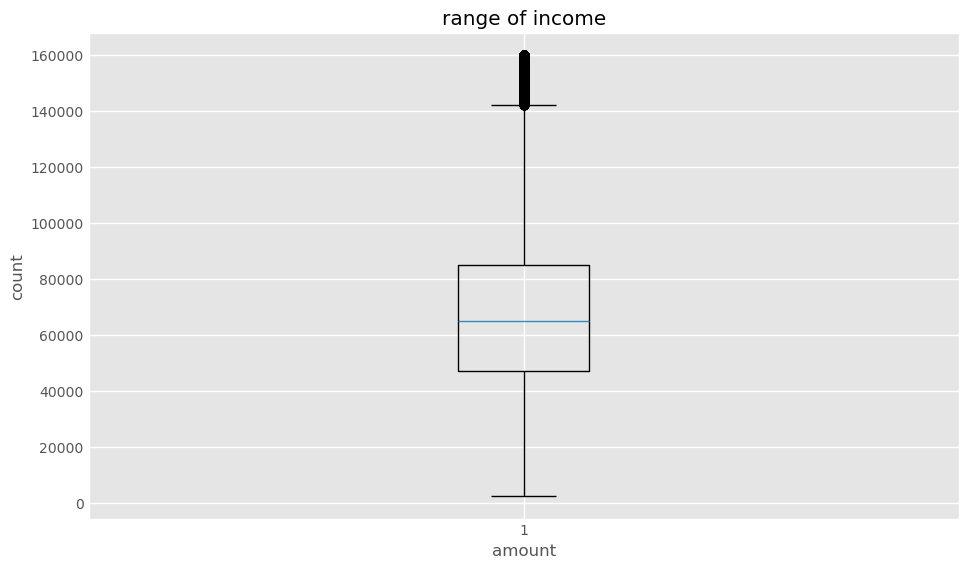

In [65]:
plt.figure(figsize=(10,6))
plt.boxplot(df['annual_inc'])
plt.title('range of income')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

array([[<Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'dti'}>,
        <Axes: title={'center': 'funded_amnt'}>],
       [<Axes: title={'center': 'installment'}>,
        <Axes: title={'center': 'int_rate'}>,
        <Axes: title={'center': 'loan_amnt'}>],
       [<Axes: title={'center': 'percent_bc_gt_75'}>,
        <Axes: title={'center': 'revol_util'}>, <Axes: >]], dtype=object)

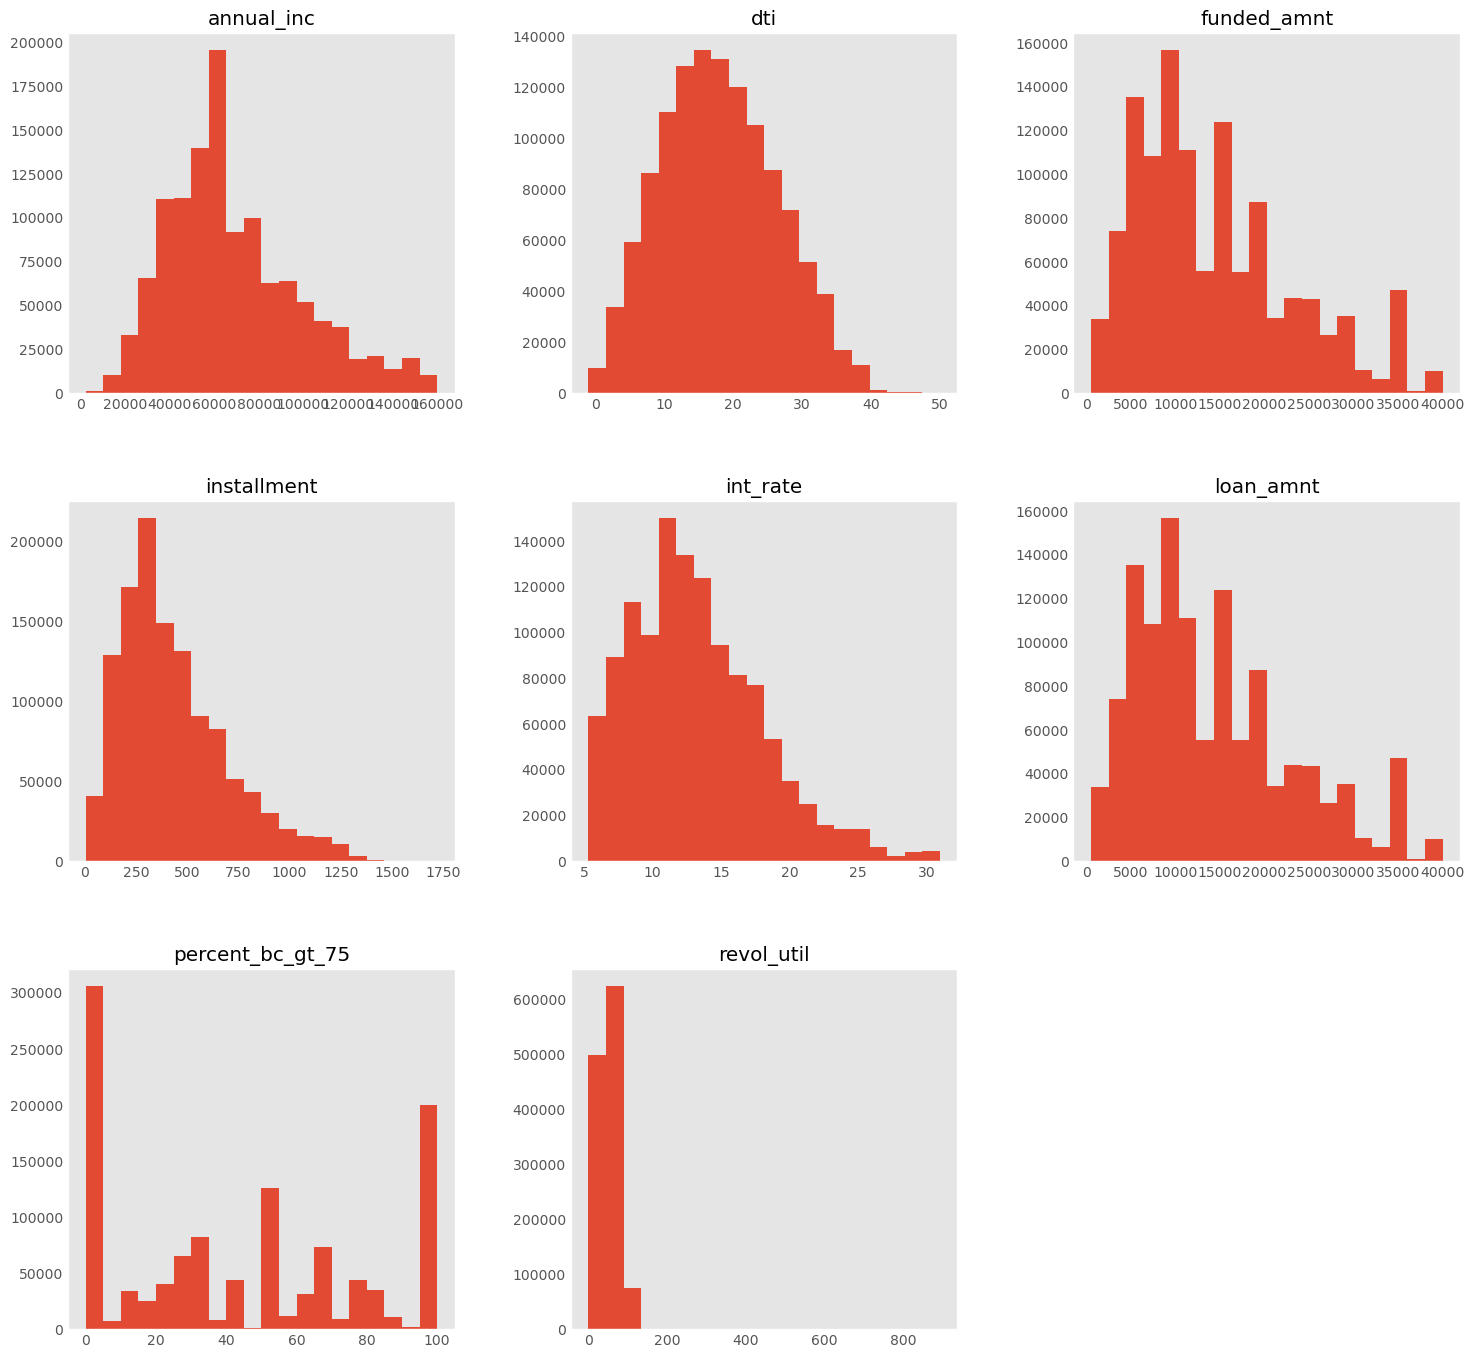

In [66]:
df_num_unlim=df[['annual_inc','dti','funded_amnt','installment','int_rate','loan_amnt','percent_bc_gt_75','revol_util']]
df_num_unlim.hist(figsize=(16,16), bins=20, grid=False)

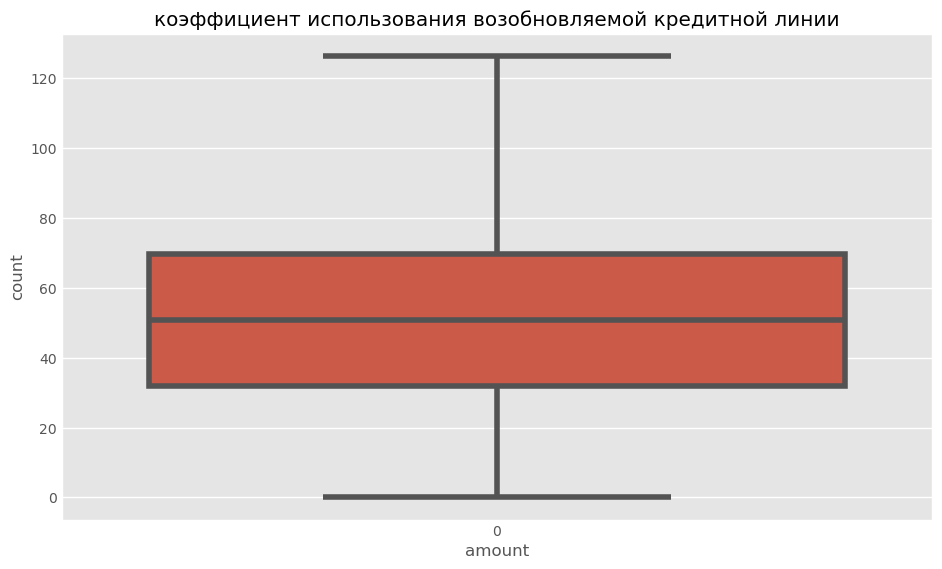

In [67]:
plt.figure(figsize=(10,6))
sns.boxplot(df['revol_util'],whis=1.5,showfliers=False)
plt.title('коэффициент использования возобновляемой кредитной линии')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

In [68]:
df.loc[df['revol_util']>100, 'revol_util']=df['revol_util'].median()

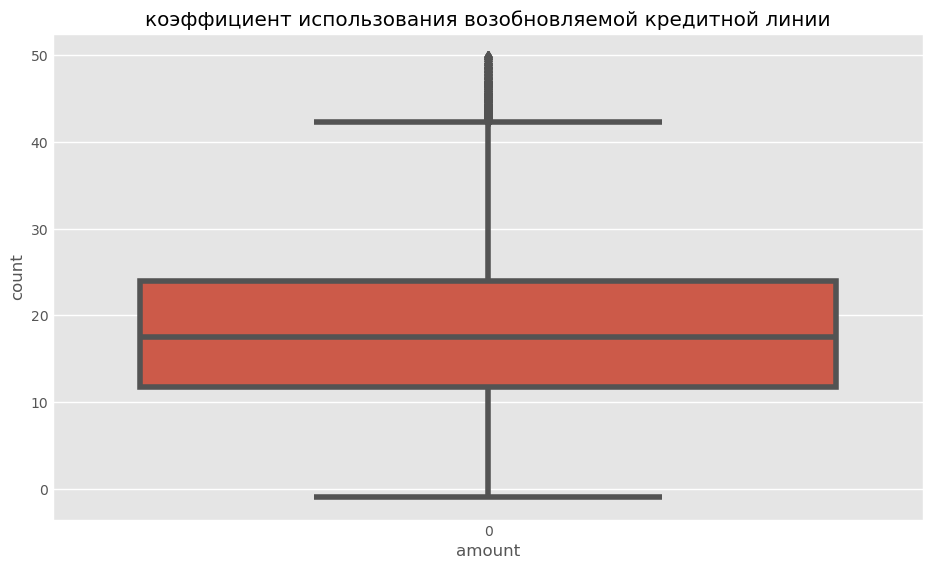

In [69]:
plt.figure(figsize=(10,6))
sns.boxplot(df['dti'],whis=1.5)
plt.title('коэффициент использования возобновляемой кредитной линии')
plt.xlabel('amount')
plt.ylabel('count')
plt.show()

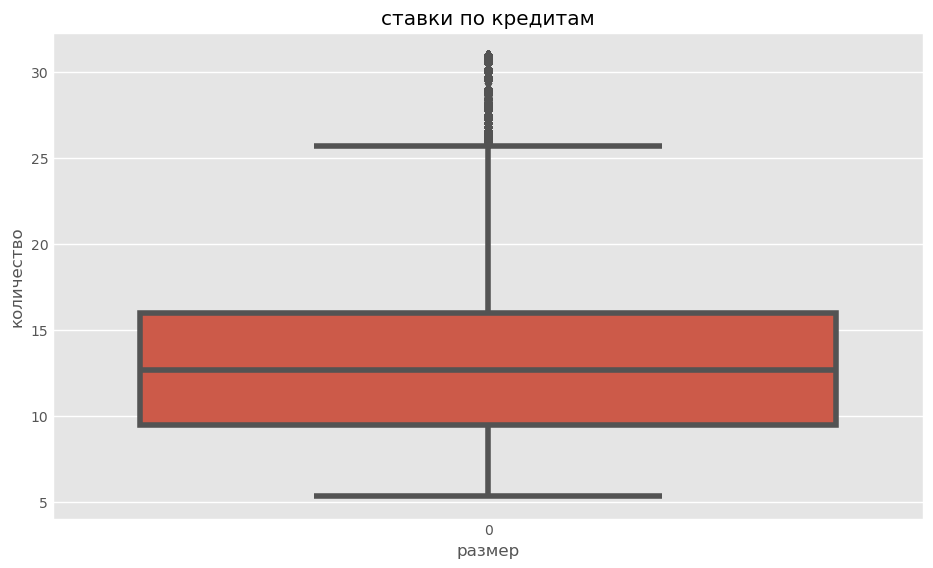

In [70]:
plt.figure(figsize=(10,6))
sns.boxplot(df['int_rate'],whis=1.5)
plt.title('ставки по кредитам')
plt.xlabel('размер')
plt.ylabel('количество')
plt.show()

In [71]:
# df.loc[df['int_rate']>25, 'int_rate']=df['int_rate'].median()

In [72]:
# plt.figure(figsize=(10,6))
# sns.boxplot(df['int_rate'],whis=1.5)
# plt.title('ставки по кредитам')
# plt.xlabel('размер')
# plt.ylabel('количество')
# plt.show()

array([[<Axes: title={'center': 'annual_inc'}>,
        <Axes: title={'center': 'dti'}>,
        <Axes: title={'center': 'funded_amnt'}>],
       [<Axes: title={'center': 'installment'}>,
        <Axes: title={'center': 'int_rate'}>,
        <Axes: title={'center': 'loan_amnt'}>],
       [<Axes: title={'center': 'percent_bc_gt_75'}>,
        <Axes: title={'center': 'revol_util'}>, <Axes: >]], dtype=object)

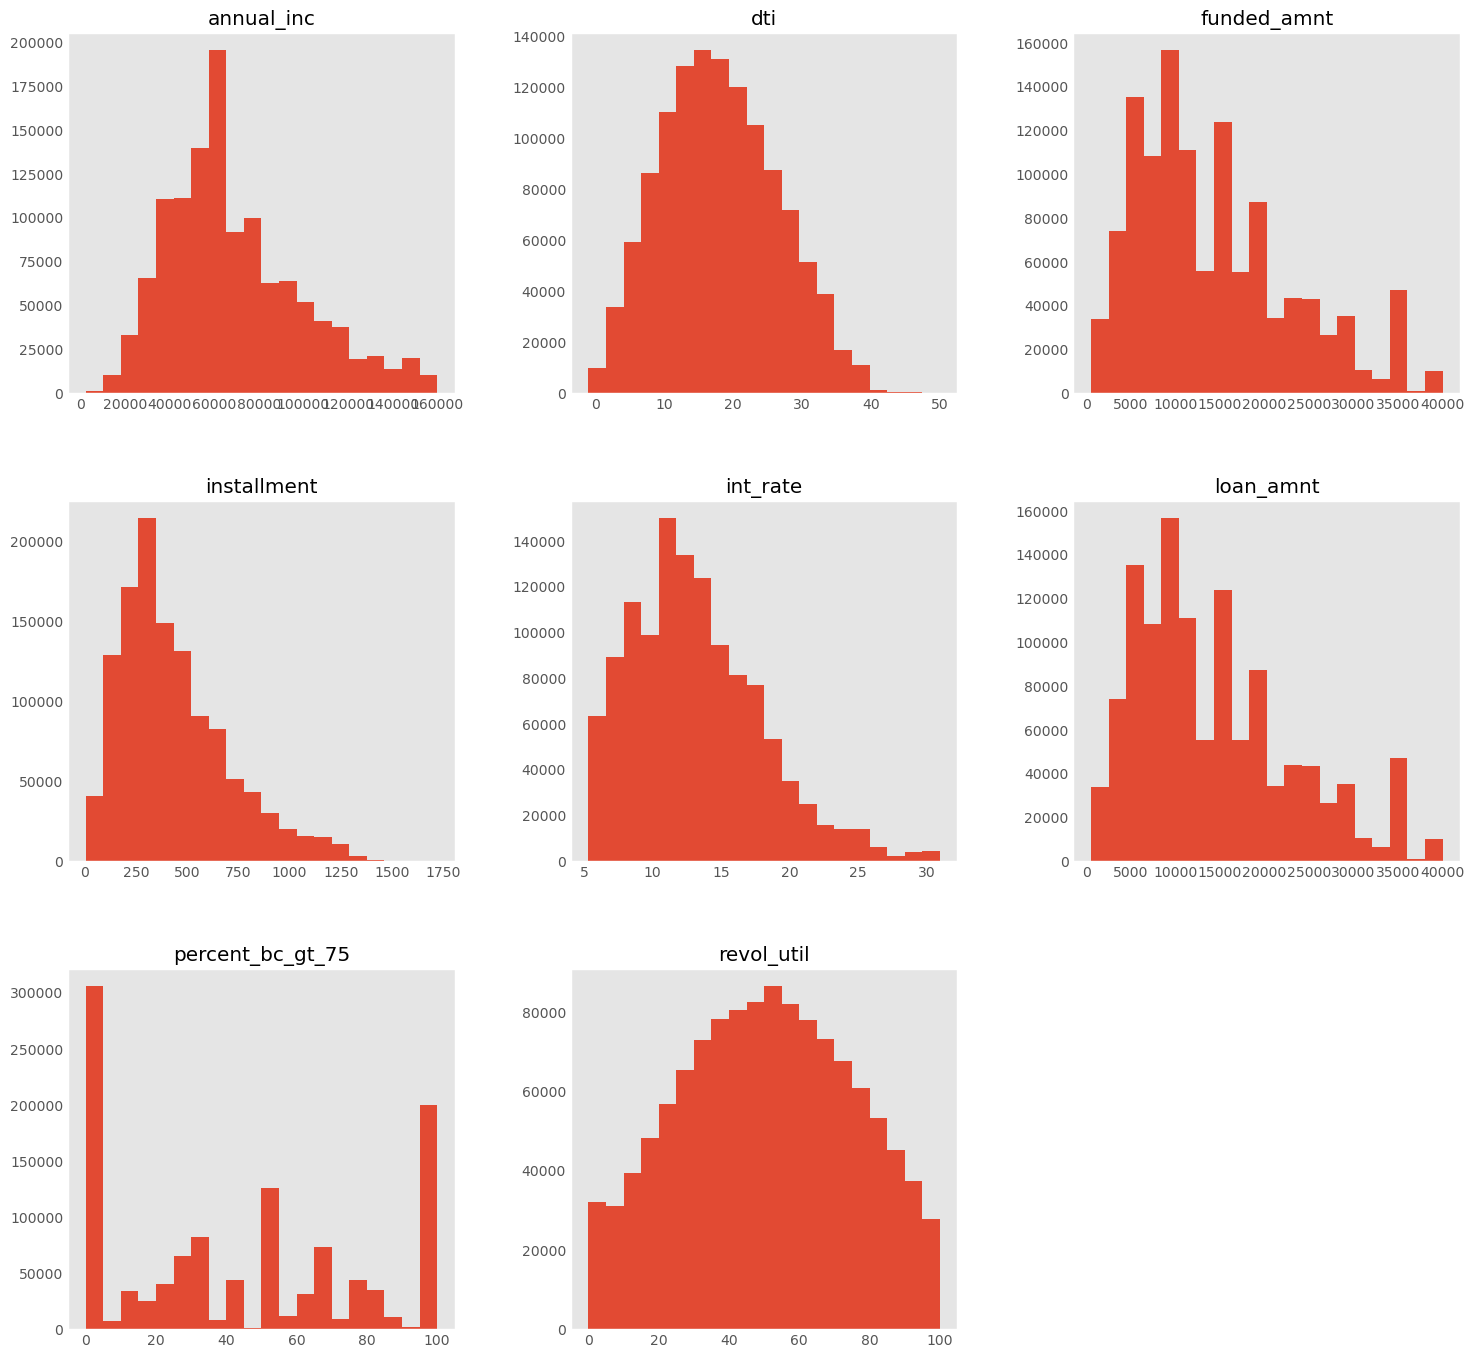

In [73]:
df_num_unlim=df[['annual_inc','dti','funded_amnt','installment','int_rate','loan_amnt','percent_bc_gt_75','revol_util']]
df_num_unlim.hist(figsize=(16,16), bins=20, grid=False)

In [74]:
df_num_unlim.head()
# compare_date=df[['annual_inc', 'installment']]
# compare_date.head()

annual_inc    dti  funded_amnt  installment  int_rate  loan_amnt  \
index                                                                     
0         80000.0  30.49      16000.0       539.03     12.99    16000.0   
1         82000.0   7.00       6600.0       214.27     10.42     6600.0   
2         46080.0  17.32      10000.0       317.96      8.99    10000.0   
3         30000.0   7.80       3000.0        98.98     11.53     3000.0   
4         70000.0  13.36      20000.0       602.37     26.30    20000.0   

       percent_bc_gt_75  revol_util  
index                                
0                 100.0        56.1  
1                 100.0        88.3  
2                   0.0        18.1  
3                   0.0        33.4  
4                 100.0        88.6

In [75]:
# df_num_unlim.head()
# # compare_date=df[['annual_inc', 'installment']]
# # compare_date.head()

# # plt.figure(figsize=(15, 10))
# # ax = sns.regplot(x='annual_inc', y='installment', data=compare_date, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
# # sns.set(font_scale=2.0)
# # sns.set_style('whitegrid')
# # ax.set(xlabel='показатель Х', ylabel='показатель Y')
# # ax.set_title('Зависимость двух показателей')
# # plt.show()

In [76]:
df_num_lim=df[['acc_now_delinq','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'fico_range_high','fico_range_low','inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_bc_dlq','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
             'open_acc','open_il_24m','open_rv_24m','pub_rec','pub_rec_bankruptcies', 'tax_liens','total_acc']]
df_num_lim.head()

acc_now_delinq  chargeoff_within_12_mths  collections_12_mths_ex_med  \
index                                                                         
0                 0.0                       0.0                         0.0   
1                 0.0                       0.0                         0.0   
2                 0.0                       0.0                         0.0   
3                 0.0                       0.0                         0.0   
4                 0.0                       0.0                         0.0   

       delinq_2yrs  fico_range_high  fico_range_low  inq_last_12m  mort_acc  \
index                                                                         
0              0.0            689.0           685.0           1.0       5.0   
1              0.0            689.0           685.0           0.0       2.0   
2              1.0            674.0           670.0           0.0       3.0   
3              0.0            694.0           690.0           NaN       0.0   
4              0.0            674.0           670.0           0.0       0.0   

       mths_since_last_delinq  mths_since_recent_bc_dlq  ...  num_tl_30dpd  \
index                                                    ...                 
0                        50.0                      65.0  ...           0.0   
1                         NaN                       NaN  ...           0.0   
2                        10.0                       NaN  ...           0.0   
3                         NaN                       NaN  ...           0.0   
4                        24.0                       NaN  ...           0.0   

       num_tl_90g_dpd_24m  num_tl_op_past_12m  open_acc  open_il_24m  \
index                                                                  
0                     0.0                 3.0      14.0          2.0   
1                     0.0                 0.0       5.0          0.0   
2                     0.0                 0.0       7.0          0.0   
3                     0.0                 4.0      19.0          NaN   
4                     0.0                 0.0       4.0          3.0   

       open_rv_24m  pub_rec  pub_rec_bankruptcies  tax_liens  total_acc  
index                                                                    
0              3.0      1.0                   1.0        0.0       26.0  
1              1.0      1.0                   1.0        0.0       11.0  
2              3.0      0.0                   0.0        0.0       31.0  
3              NaN      0.0                   0.0        0.0       24.0  
4              1.0      0.0                   0.0        0.0       16.0  

[5 rows x 26 columns]

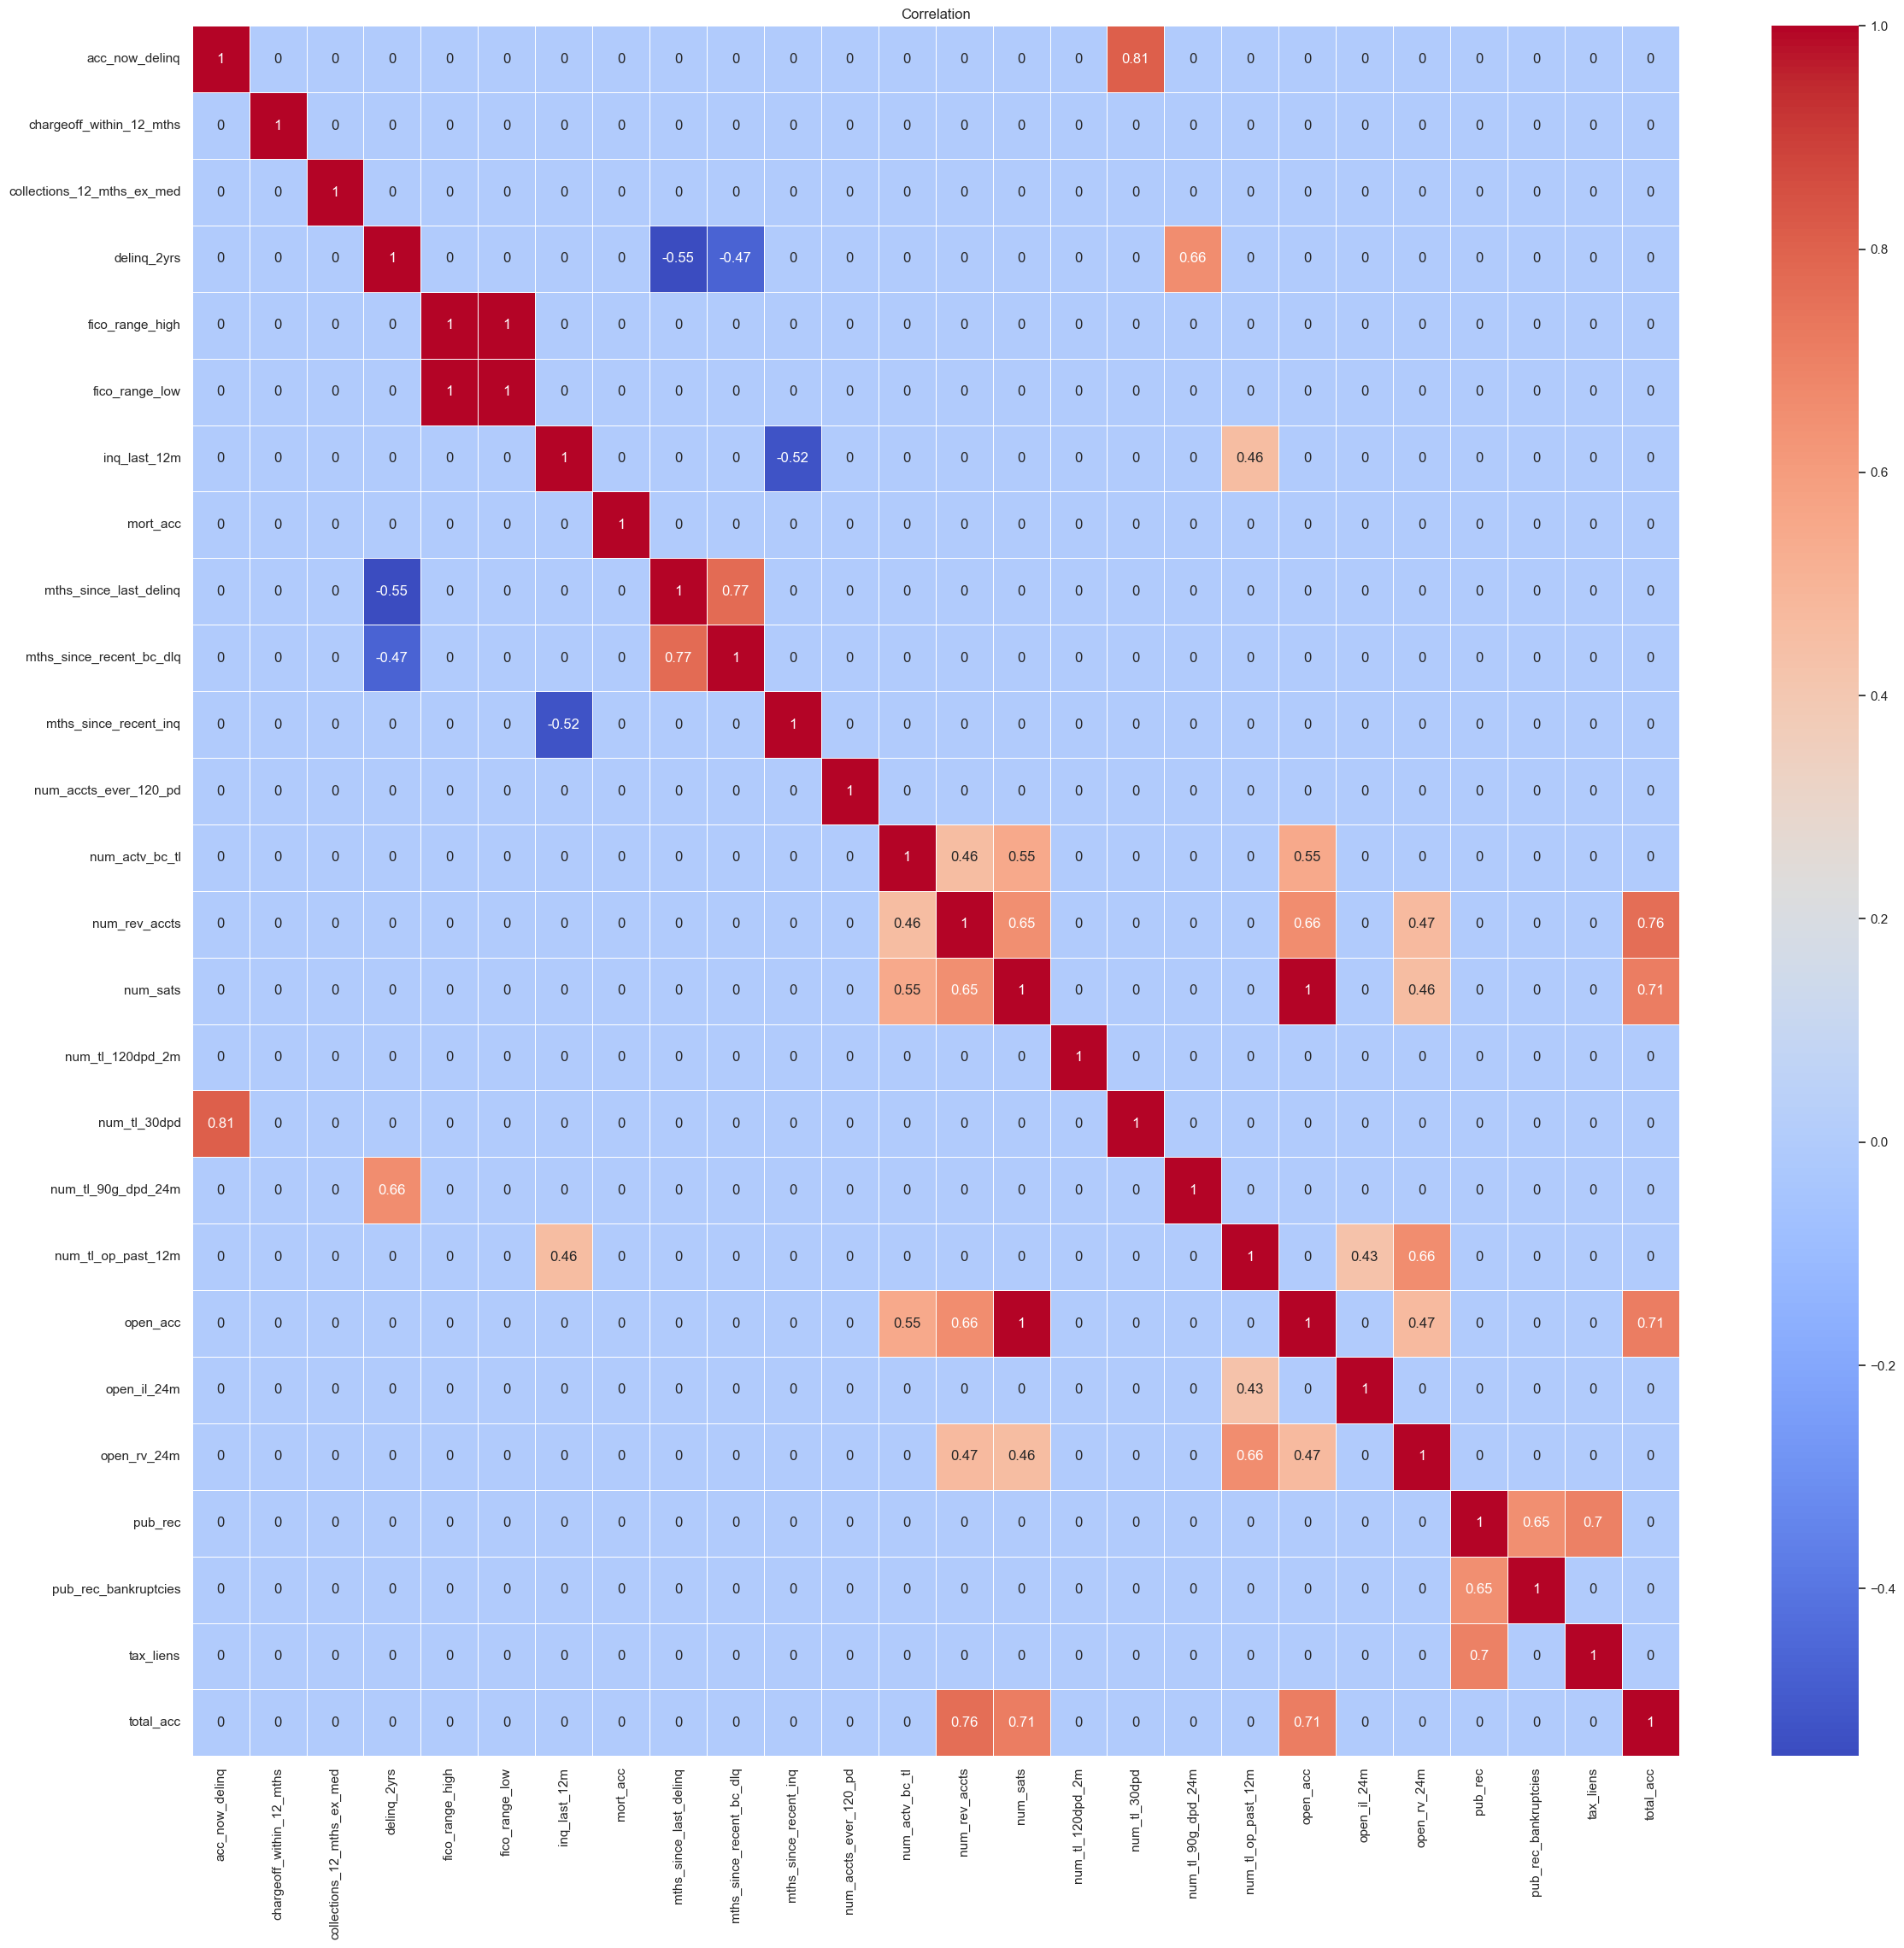

In [77]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.4]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [78]:
df.columns

Index(['acc_now_delinq', 'addr_state', 'annual_inc',
       'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs',
       'dti', 'earliest_cr_line', 'emp_length', 'fico_range_high',
       'fico_range_low', 'funded_amnt', 'home_ownership', 'inq_last_12m',
       'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_bc_dlq',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m',
       'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies',
       'purpose', 'revol_util', 'tax_liens', 'term', 'title', 'total_acc',
       'verification_status', 'zip_code', 'loan_status', 'fico_mean',
       'share_of_open_acc', 'bad_rec', 'credit_load', 'year', 'month'],
      dtype='object')

In [79]:
df['fico_mean']=(df['fico_range_high']+df['fico_range_low'])/2
df.drop(['fico_range_high','fico_range_low'], axis=1,inplace=True)
df.head()

acc_now_delinq addr_state  annual_inc  chargeoff_within_12_mths  \
index                                                                    
0                 0.0         UT     80000.0                       0.0   
1                 0.0         CA     82000.0                       0.0   
2                 0.0         NV     46080.0                       0.0   
3                 0.0         AZ     30000.0                       0.0   
4                 0.0         OH     70000.0                       0.0   

       collections_12_mths_ex_med  delinq_2yrs    dti earliest_cr_line  \
index                                                                    
0                             0.0          0.0  30.49         Oct-1996   
1                             0.0          0.0   7.00         Mar-1993   
2                             0.0          1.0  17.32         Nov-2000   
3                             0.0          0.0   7.80         Jan-2010   
4                             0.0          0.0  13.36         Jan-2002   

       emp_length  funded_amnt  ...  total_acc  verification_status  zip_code  \
index                           ...                                             
0             4.0      16000.0  ...       26.0                    1     847xx   
1            10.0       6600.0  ...       11.0                    2     900xx   
2             3.0      10000.0  ...       31.0                    1     895xx   
3             0.5       3000.0  ...       24.0                    1     853xx   
4             0.5      20000.0  ...       16.0                    2     453xx   

       loan_status fico_mean  share_of_open_acc  bad_rec  credit_load  year  \
index                                                                         
0                1     687.0           0.538462      1.0     0.080854  2016   
1                0     687.0           0.454545      1.0     0.031357  2017   
2                1     672.0           0.225806      0.0     0.082802  2016   
3                0     692.0           0.791667      0.0     0.039592  2015   
4                0     672.0           0.250000      0.0     0.103263  2017   

       month  
index         
0          4  
1          9  
2          8  
3          8  
4          9  

[5 rows x 49 columns]

In [80]:
df_num_lim=df[['acc_now_delinq','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_bc_dlq','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_sats','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
             'open_acc','open_il_24m','open_rv_24m','pub_rec','pub_rec_bankruptcies', 'tax_liens','total_acc','fico_mean']]
df_num_lim.head()

acc_now_delinq  chargeoff_within_12_mths  collections_12_mths_ex_med  \
index                                                                         
0                 0.0                       0.0                         0.0   
1                 0.0                       0.0                         0.0   
2                 0.0                       0.0                         0.0   
3                 0.0                       0.0                         0.0   
4                 0.0                       0.0                         0.0   

       delinq_2yrs  inq_last_12m  mort_acc  mths_since_last_delinq  \
index                                                                
0              0.0           1.0       5.0                    50.0   
1              0.0           0.0       2.0                     NaN   
2              1.0           0.0       3.0                    10.0   
3              0.0           NaN       0.0                     NaN   
4              0.0           0.0       0.0                    24.0   

       mths_since_recent_bc_dlq  mths_since_recent_inq  num_accts_ever_120_pd  \
index                                                                           
0                          65.0                    6.0                    3.0   
1                           NaN                    NaN                    0.0   
2                           NaN                   13.0                    0.0   
3                           NaN                   16.0                    0.0   
4                           NaN                   15.0                    0.0   

       ...  num_tl_90g_dpd_24m  num_tl_op_past_12m  open_acc  open_il_24m  \
index  ...                                                                  
0      ...                 0.0                 3.0      14.0          2.0   
1      ...                 0.0                 0.0       5.0          0.0   
2      ...                 0.0                 0.0       7.0          0.0   
3      ...                 0.0                 4.0      19.0          NaN   
4      ...                 0.0                 0.0       4.0          3.0   

       open_rv_24m  pub_rec  pub_rec_bankruptcies  tax_liens  total_acc  \
index                                                                     
0              3.0      1.0                   1.0        0.0       26.0   
1              1.0      1.0                   1.0        0.0       11.0   
2              3.0      0.0                   0.0        0.0       31.0   
3              NaN      0.0                   0.0        0.0       24.0   
4              1.0      0.0                   0.0        0.0       16.0   

       fico_mean  
index             
0          687.0  
1          687.0  
2          672.0  
3          692.0  
4          672.0  

[5 rows x 25 columns]

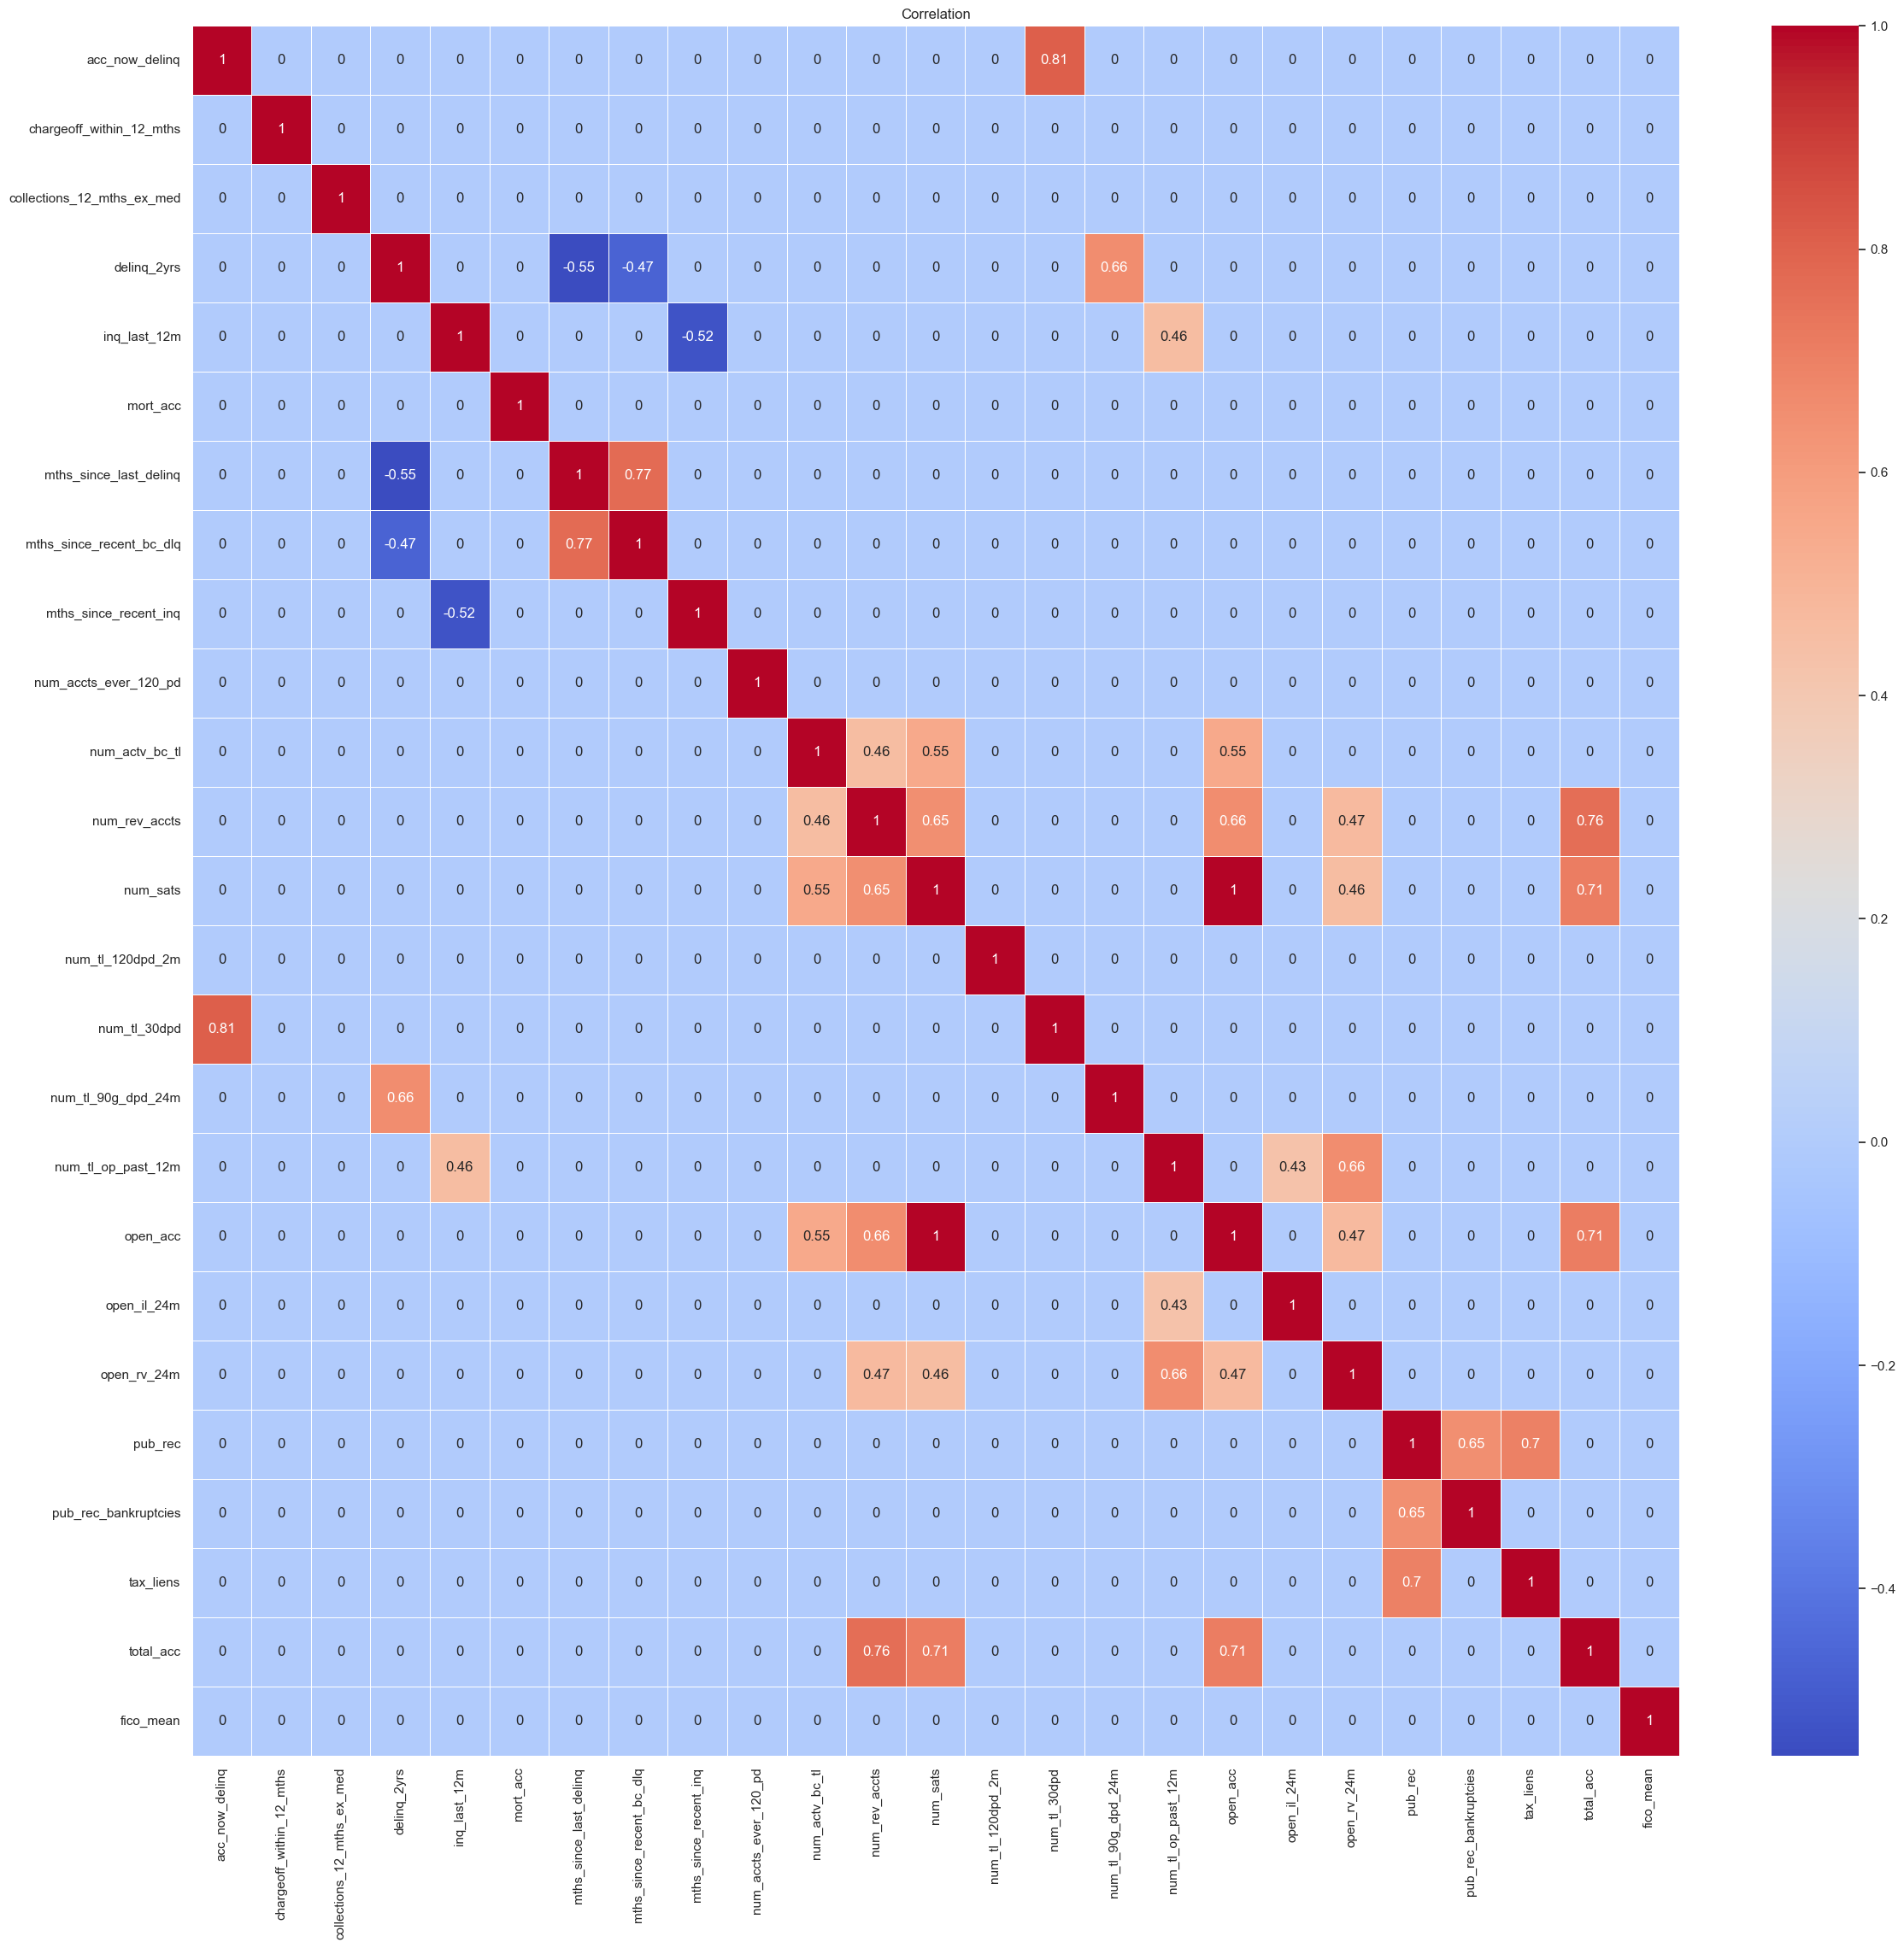

In [81]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.4]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [82]:
df.drop(['num_sats'], axis=1,inplace=True)

In [83]:
df_num_lim=df[['acc_now_delinq','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_bc_dlq','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
             'open_acc','open_il_24m','open_rv_24m','pub_rec','pub_rec_bankruptcies', 'tax_liens','total_acc','fico_mean']]
df_num_lim.head()

acc_now_delinq  chargeoff_within_12_mths  collections_12_mths_ex_med  \
index                                                                         
0                 0.0                       0.0                         0.0   
1                 0.0                       0.0                         0.0   
2                 0.0                       0.0                         0.0   
3                 0.0                       0.0                         0.0   
4                 0.0                       0.0                         0.0   

       delinq_2yrs  inq_last_12m  mort_acc  mths_since_last_delinq  \
index                                                                
0              0.0           1.0       5.0                    50.0   
1              0.0           0.0       2.0                     NaN   
2              1.0           0.0       3.0                    10.0   
3              0.0           NaN       0.0                     NaN   
4              0.0           0.0       0.0                    24.0   

       mths_since_recent_bc_dlq  mths_since_recent_inq  num_accts_ever_120_pd  \
index                                                                           
0                          65.0                    6.0                    3.0   
1                           NaN                    NaN                    0.0   
2                           NaN                   13.0                    0.0   
3                           NaN                   16.0                    0.0   
4                           NaN                   15.0                    0.0   

       ...  num_tl_90g_dpd_24m  num_tl_op_past_12m  open_acc  open_il_24m  \
index  ...                                                                  
0      ...                 0.0                 3.0      14.0          2.0   
1      ...                 0.0                 0.0       5.0          0.0   
2      ...                 0.0                 0.0       7.0          0.0   
3      ...                 0.0                 4.0      19.0          NaN   
4      ...                 0.0                 0.0       4.0          3.0   

       open_rv_24m  pub_rec  pub_rec_bankruptcies  tax_liens  total_acc  \
index                                                                     
0              3.0      1.0                   1.0        0.0       26.0   
1              1.0      1.0                   1.0        0.0       11.0   
2              3.0      0.0                   0.0        0.0       31.0   
3              NaN      0.0                   0.0        0.0       24.0   
4              1.0      0.0                   0.0        0.0       16.0   

       fico_mean  
index             
0          687.0  
1          687.0  
2          672.0  
3          692.0  
4          672.0  

[5 rows x 24 columns]

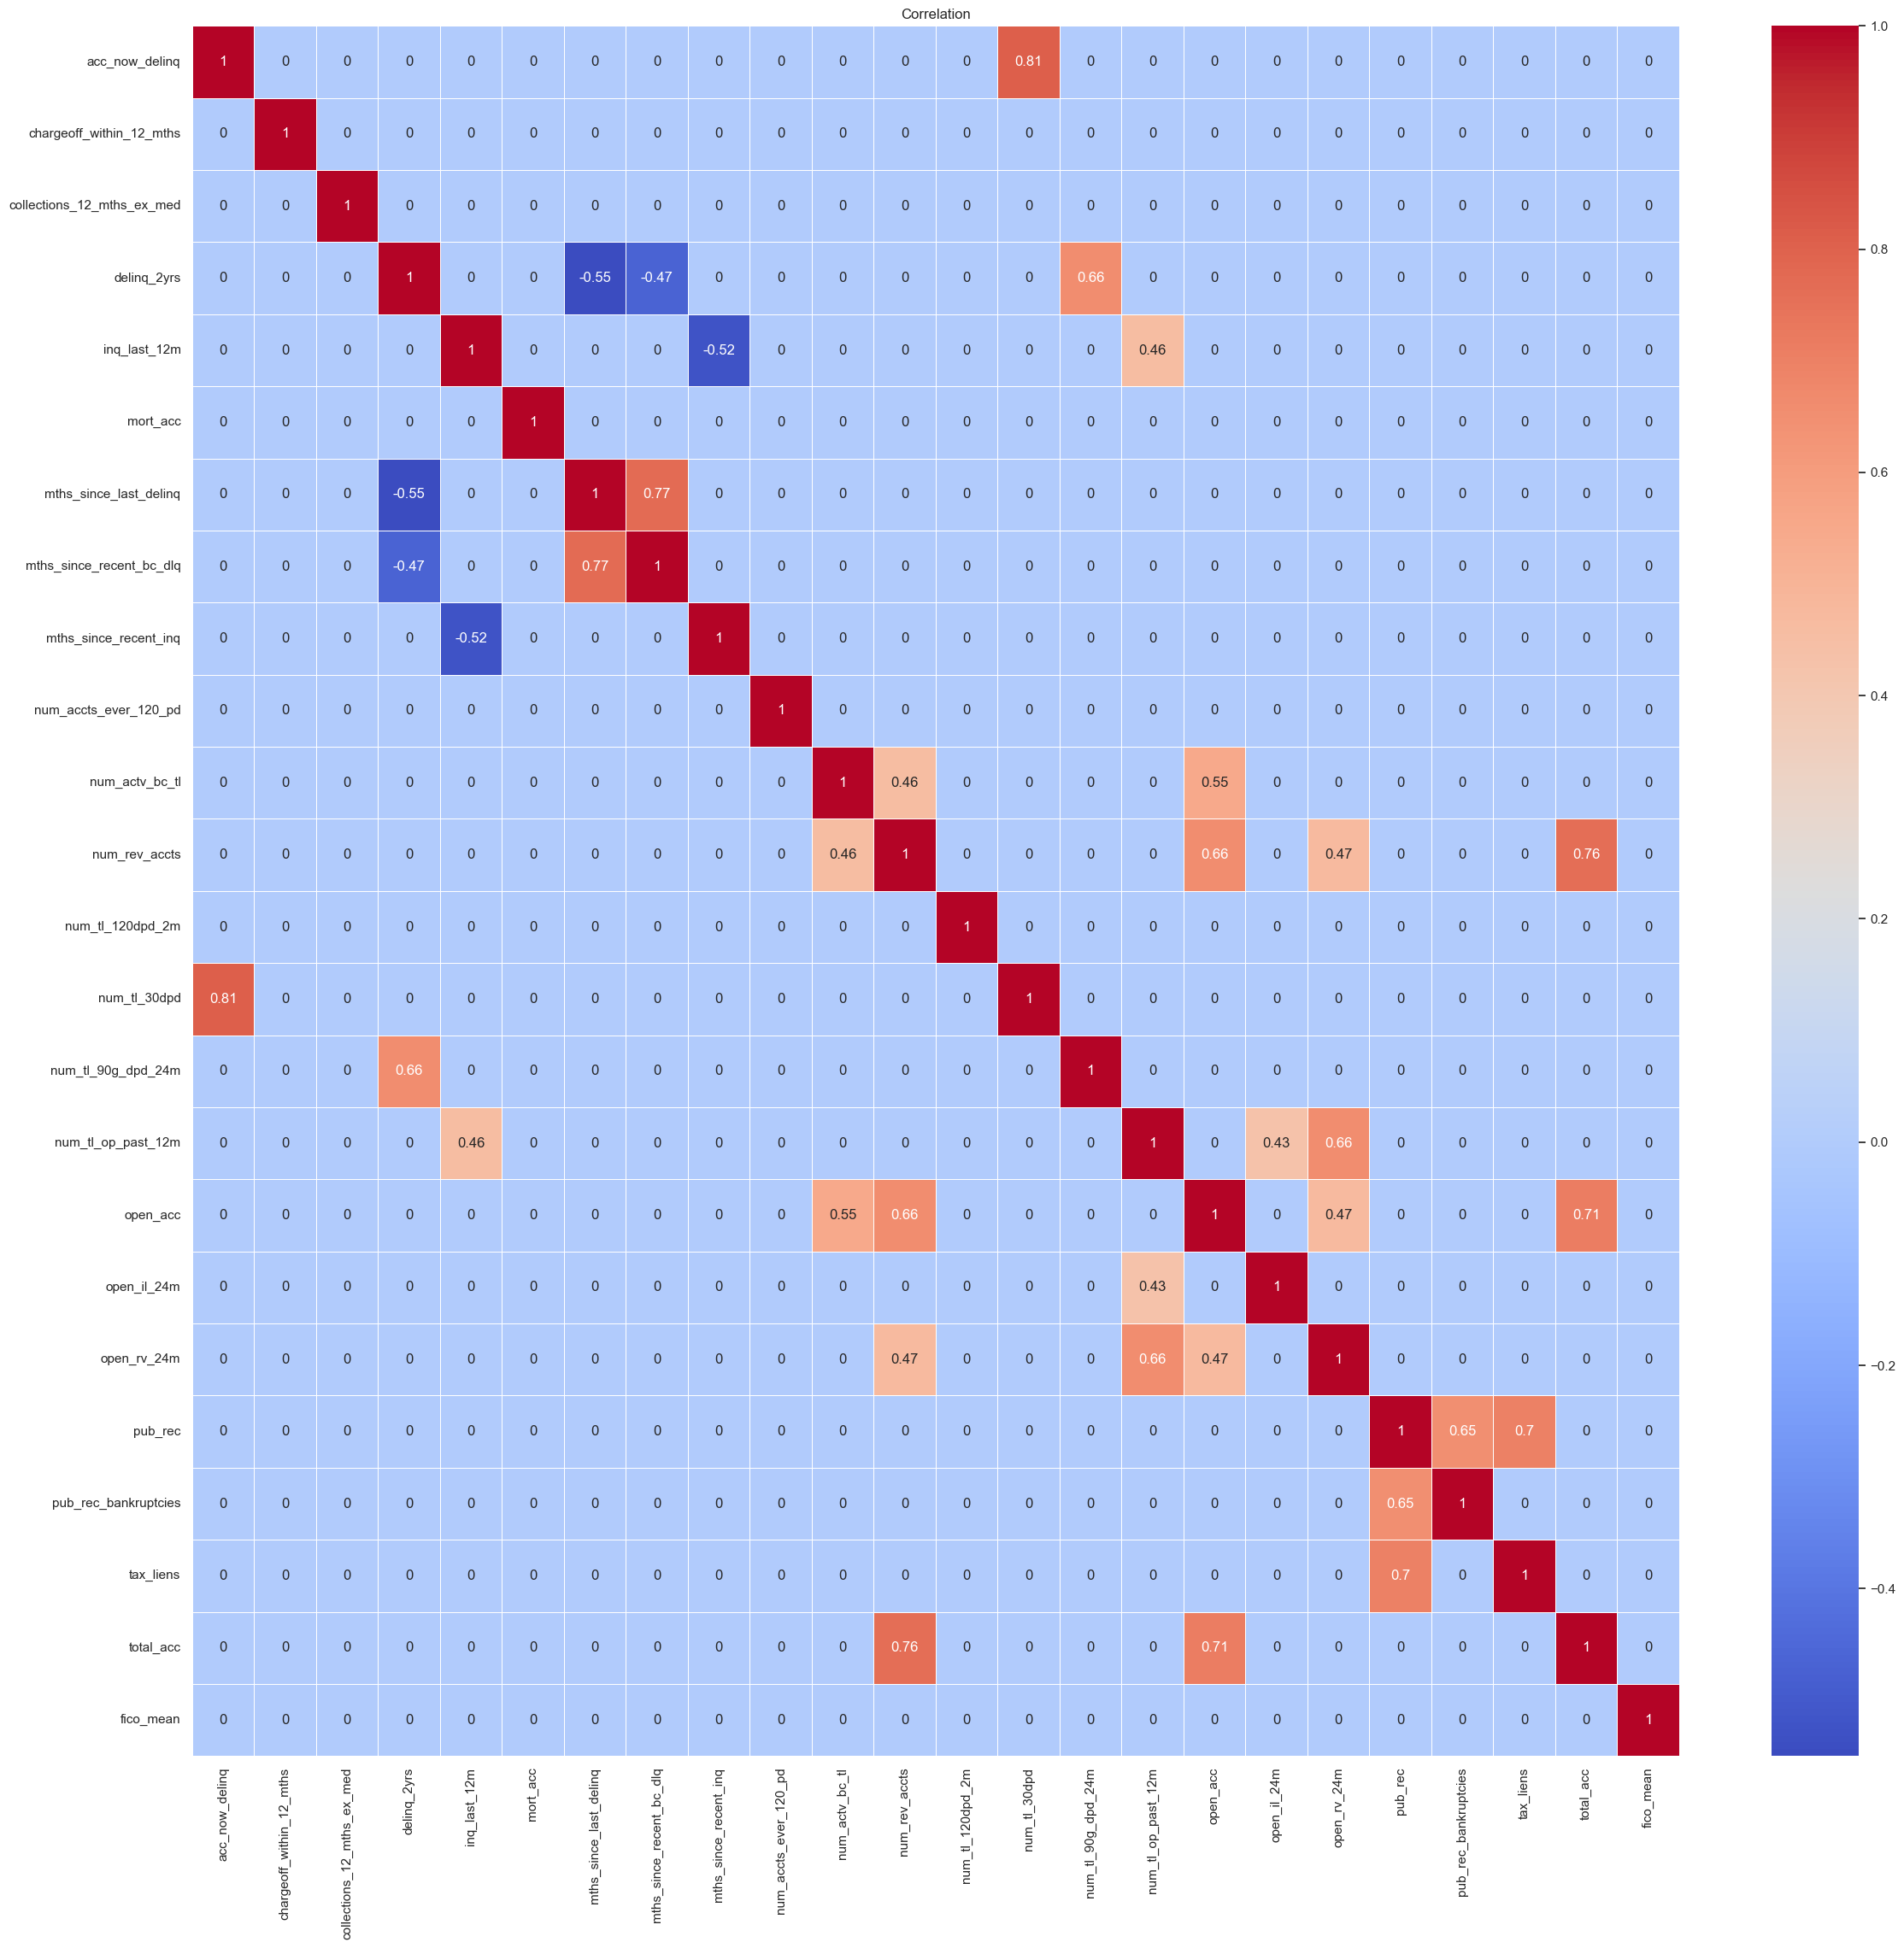

In [84]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.4]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [85]:
df['share_of_open_acc']=df['open_acc']/df['total_acc']
df.drop(['open_acc','total_acc'], axis=1,inplace=True)
df.head()

acc_now_delinq addr_state  annual_inc  chargeoff_within_12_mths  \
index                                                                    
0                 0.0         UT     80000.0                       0.0   
1                 0.0         CA     82000.0                       0.0   
2                 0.0         NV     46080.0                       0.0   
3                 0.0         AZ     30000.0                       0.0   
4                 0.0         OH     70000.0                       0.0   

       collections_12_mths_ex_med  delinq_2yrs    dti earliest_cr_line  \
index                                                                    
0                             0.0          0.0  30.49         Oct-1996   
1                             0.0          0.0   7.00         Mar-1993   
2                             0.0          1.0  17.32         Nov-2000   
3                             0.0          0.0   7.80         Jan-2010   
4                             0.0          0.0  13.36         Jan-2002   

       emp_length  funded_amnt  ...                    title  \
index                           ...                            
0             4.0      16000.0  ...  Credit card refinancing   
1            10.0       6600.0  ...  Credit card refinancing   
2             3.0      10000.0  ...  Credit card refinancing   
3             0.5       3000.0  ...            Car financing   
4             0.5      20000.0  ...                    Other   

       verification_status  zip_code  loan_status fico_mean  \
index                                                         
0                        1     847xx            1     687.0   
1                        2     900xx            0     687.0   
2                        1     895xx            1     672.0   
3                        1     853xx            0     692.0   
4                        2     453xx            0     672.0   

       share_of_open_acc  bad_rec  credit_load  year  month  
index                                                        
0               0.538462      1.0     0.080854  2016      4  
1               0.454545      1.0     0.031357  2017      9  
2               0.225806      0.0     0.082802  2016      8  
3               0.791667      0.0     0.039592  2015      8  
4               0.250000      0.0     0.103263  2017      9  

[5 rows x 46 columns]

In [86]:
df_num_lim=df[['acc_now_delinq','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_bc_dlq','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
               'open_il_24m','open_rv_24m','pub_rec','pub_rec_bankruptcies', 'tax_liens','fico_mean','share_of_open_acc']]
df_num_lim.head()

acc_now_delinq  chargeoff_within_12_mths  collections_12_mths_ex_med  \
index                                                                         
0                 0.0                       0.0                         0.0   
1                 0.0                       0.0                         0.0   
2                 0.0                       0.0                         0.0   
3                 0.0                       0.0                         0.0   
4                 0.0                       0.0                         0.0   

       delinq_2yrs  inq_last_12m  mort_acc  mths_since_last_delinq  \
index                                                                
0              0.0           1.0       5.0                    50.0   
1              0.0           0.0       2.0                     NaN   
2              1.0           0.0       3.0                    10.0   
3              0.0           NaN       0.0                     NaN   
4              0.0           0.0       0.0                    24.0   

       mths_since_recent_bc_dlq  mths_since_recent_inq  num_accts_ever_120_pd  \
index                                                                           
0                          65.0                    6.0                    3.0   
1                           NaN                    NaN                    0.0   
2                           NaN                   13.0                    0.0   
3                           NaN                   16.0                    0.0   
4                           NaN                   15.0                    0.0   

       ...  num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  open_il_24m  \
index  ...                                                                      
0      ...           0.0                 0.0                 3.0          2.0   
1      ...           0.0                 0.0                 0.0          0.0   
2      ...           0.0                 0.0                 0.0          0.0   
3      ...           0.0                 0.0                 4.0          NaN   
4      ...           0.0                 0.0                 0.0          3.0   

       open_rv_24m  pub_rec  pub_rec_bankruptcies  tax_liens  fico_mean  \
index                                                                     
0              3.0      1.0                   1.0        0.0      687.0   
1              1.0      1.0                   1.0        0.0      687.0   
2              3.0      0.0                   0.0        0.0      672.0   
3              NaN      0.0                   0.0        0.0      692.0   
4              1.0      0.0                   0.0        0.0      672.0   

       share_of_open_acc  
index                     
0               0.538462  
1               0.454545  
2               0.225806  
3               0.791667  
4               0.250000  

[5 rows x 23 columns]

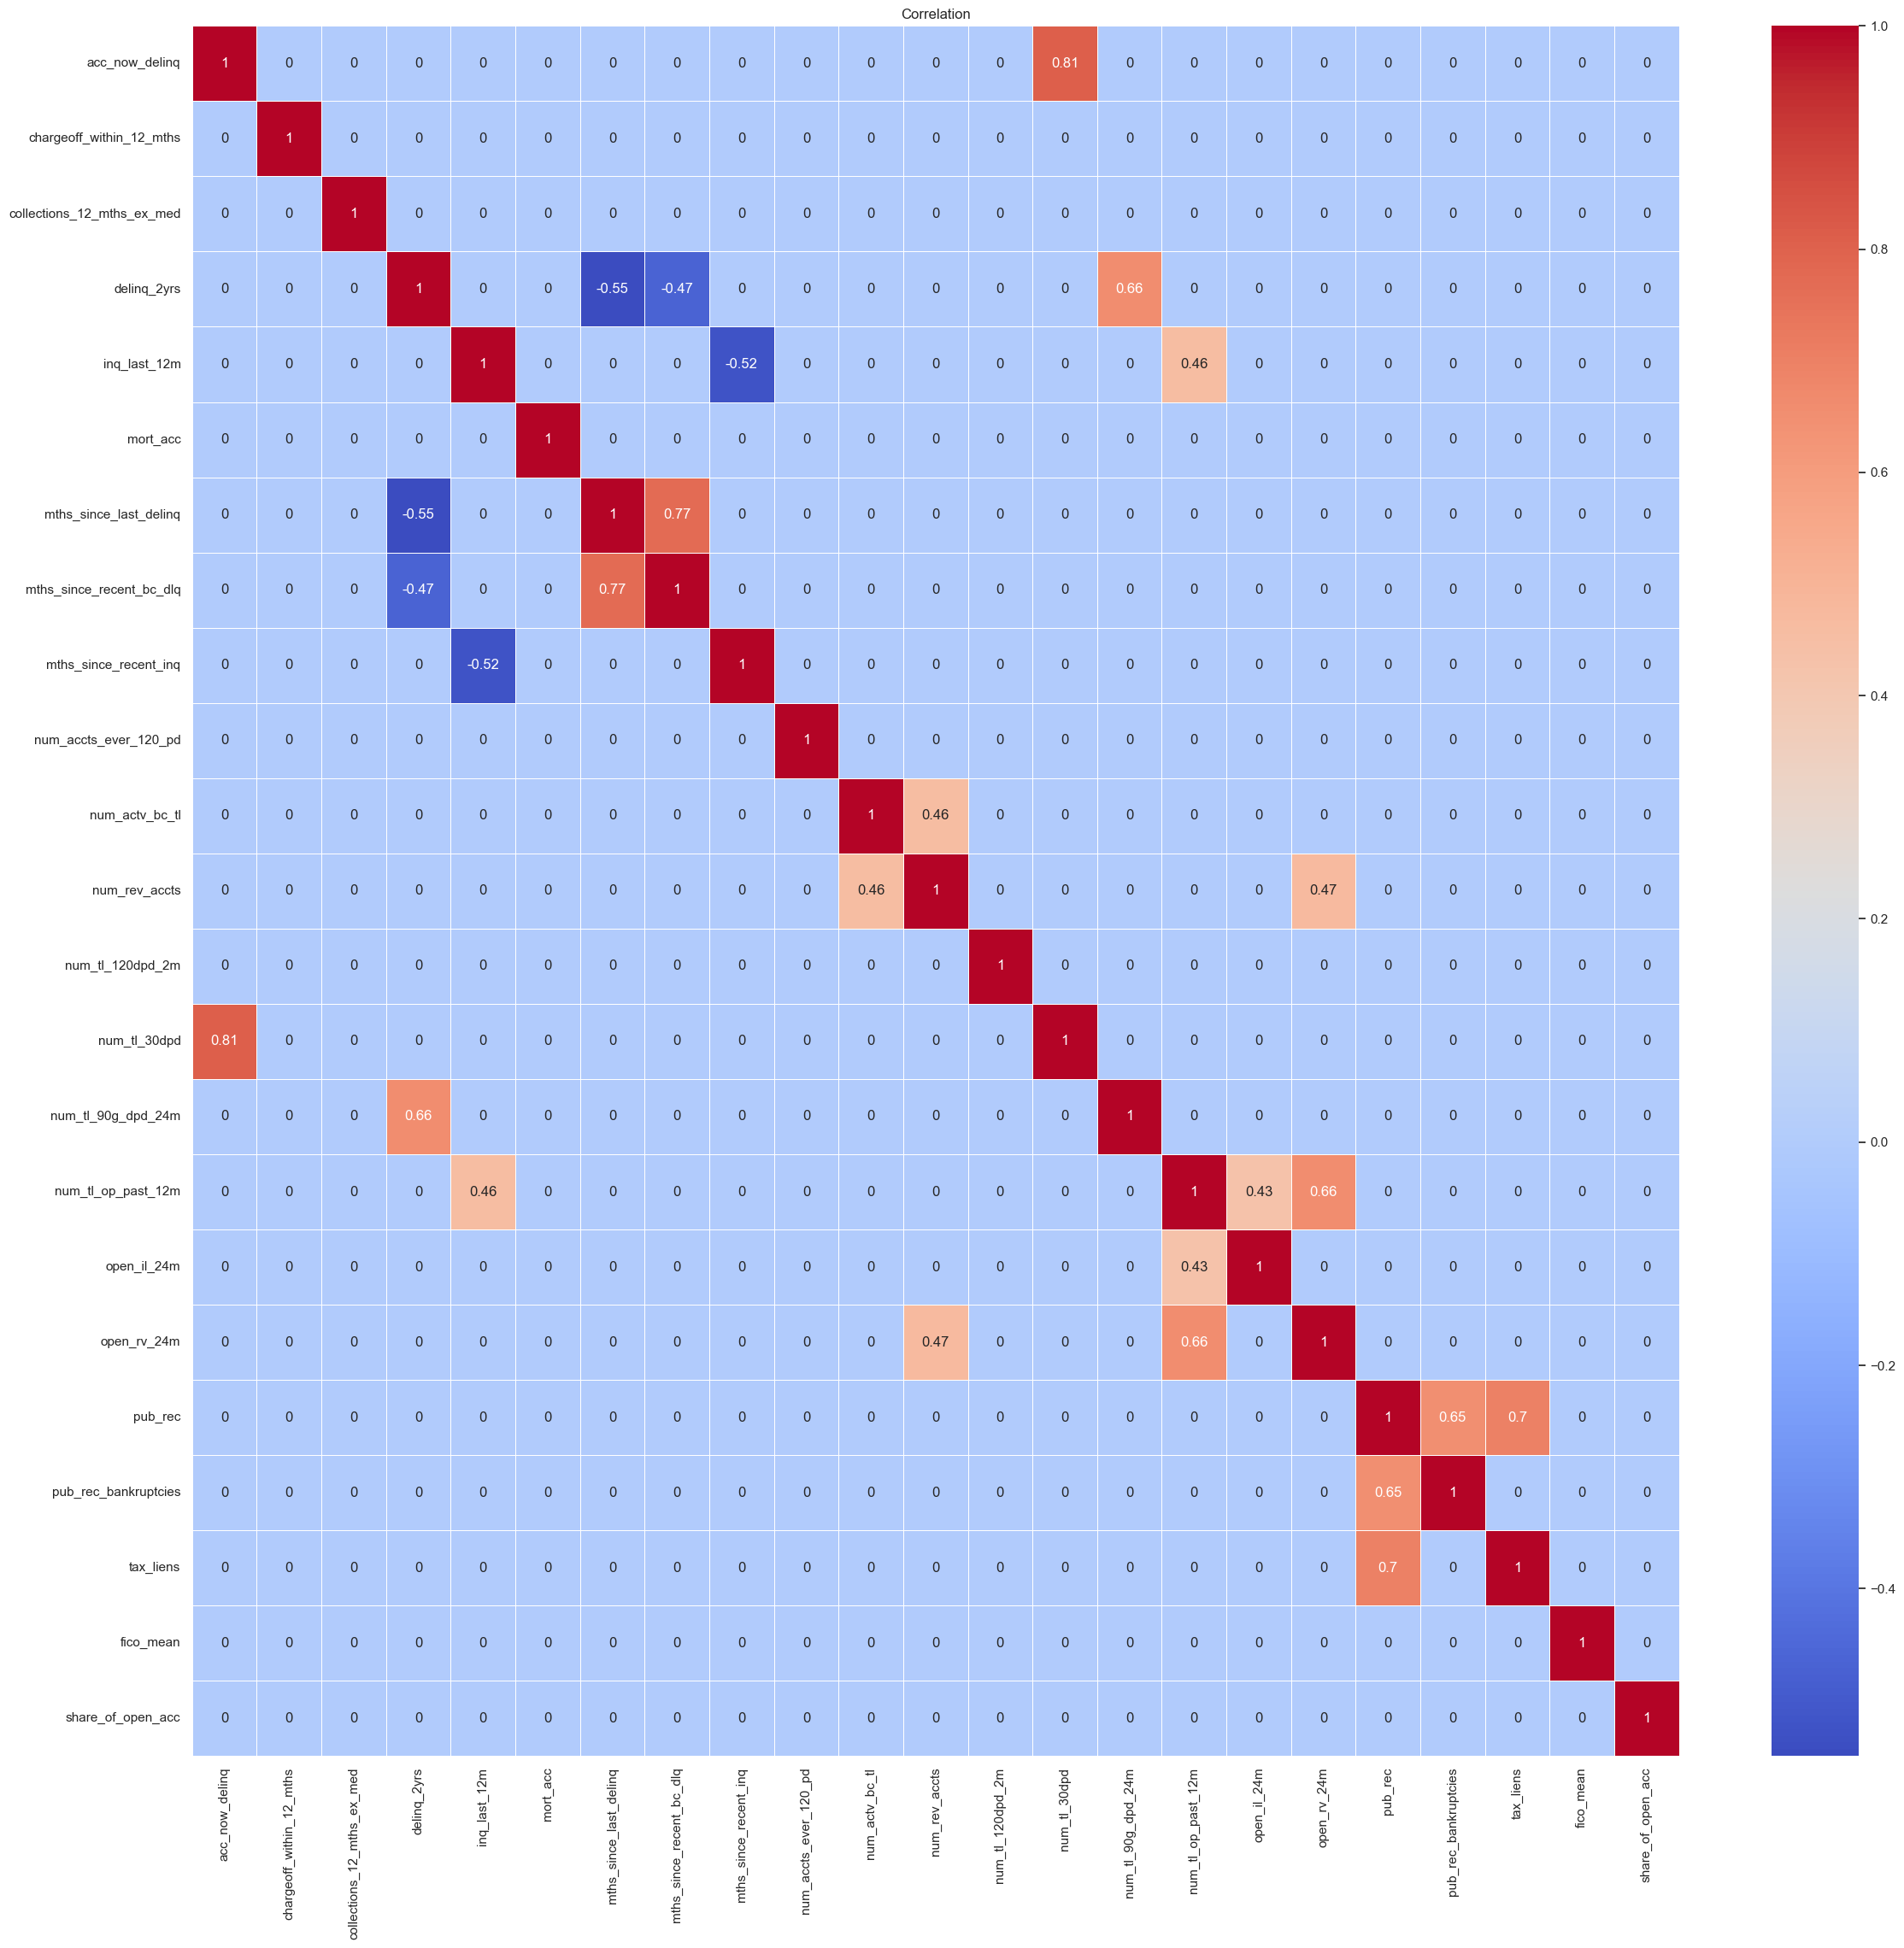

In [87]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.4]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [88]:
df.drop(['acc_now_delinq','addr_state', 'title', 'zip_code', 'earliest_cr_line', 'issue_d'], axis=1, inplace=True)
df.head()

annual_inc  chargeoff_within_12_mths  collections_12_mths_ex_med  \
index                                                                     
0         80000.0                       0.0                         0.0   
1         82000.0                       0.0                         0.0   
2         46080.0                       0.0                         0.0   
3         30000.0                       0.0                         0.0   
4         70000.0                       0.0                         0.0   

       delinq_2yrs    dti  emp_length  funded_amnt  home_ownership  \
index                                                                
0              0.0  30.49         4.0      16000.0               1   
1              0.0   7.00        10.0       6600.0               2   
2              1.0  17.32         3.0      10000.0               2   
3              0.0   7.80         0.5       3000.0               3   
4              0.0  13.36         0.5      20000.0               1   

       inq_last_12m  installment  ...  tax_liens  term  verification_status  \
index                             ...                                         
0               1.0       539.03  ...        0.0     1                    1   
1               0.0       214.27  ...        0.0     1                    2   
2               0.0       317.96  ...        0.0     1                    1   
3               NaN        98.98  ...        0.0     1                    1   
4               0.0       602.37  ...        0.0     2                    2   

       loan_status  fico_mean  share_of_open_acc  bad_rec  credit_load  year  \
index                                                                          
0                1      687.0           0.538462      1.0     0.080854  2016   
1                0      687.0           0.454545      1.0     0.031357  2017   
2                1      672.0           0.225806      0.0     0.082802  2016   
3                0      692.0           0.791667      0.0     0.039592  2015   
4                0      672.0           0.250000      0.0     0.103263  2017   

       month  
index         
0          4  
1          9  
2          8  
3          8  
4          9  

[5 rows x 40 columns]

In [89]:
df_num_lim=df[['chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_bc_dlq','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
               'open_il_24m','open_rv_24m','pub_rec','pub_rec_bankruptcies', 'tax_liens','fico_mean','share_of_open_acc']]
df_num_lim.head()

chargeoff_within_12_mths  collections_12_mths_ex_med  delinq_2yrs  \
index                                                                      
0                           0.0                         0.0          0.0   
1                           0.0                         0.0          0.0   
2                           0.0                         0.0          1.0   
3                           0.0                         0.0          0.0   
4                           0.0                         0.0          0.0   

       inq_last_12m  mort_acc  mths_since_last_delinq  \
index                                                   
0               1.0       5.0                    50.0   
1               0.0       2.0                     NaN   
2               0.0       3.0                    10.0   
3               NaN       0.0                     NaN   
4               0.0       0.0                    24.0   

       mths_since_recent_bc_dlq  mths_since_recent_inq  num_accts_ever_120_pd  \
index                                                                           
0                          65.0                    6.0                    3.0   
1                           NaN                    NaN                    0.0   
2                           NaN                   13.0                    0.0   
3                           NaN                   16.0                    0.0   
4                           NaN                   15.0                    0.0   

       num_actv_bc_tl  ...  num_tl_30dpd  num_tl_90g_dpd_24m  \
index                  ...                                     
0                 4.0  ...           0.0                 0.0   
1                 3.0  ...           0.0                 0.0   
2                 1.0  ...           0.0                 0.0   
3                 3.0  ...           0.0                 0.0   
4                 1.0  ...           0.0                 0.0   

       num_tl_op_past_12m  open_il_24m  open_rv_24m  pub_rec  \
index                                                          
0                     3.0          2.0          3.0      1.0   
1                     0.0          0.0          1.0      1.0   
2                     0.0          0.0          3.0      0.0   
3                     4.0          NaN          NaN      0.0   
4                     0.0          3.0          1.0      0.0   

       pub_rec_bankruptcies  tax_liens  fico_mean  share_of_open_acc  
index                                                                 
0                       1.0        0.0      687.0           0.538462  
1                       1.0        0.0      687.0           0.454545  
2                       0.0        0.0      672.0           0.225806  
3                       0.0        0.0      692.0           0.791667  
4                       0.0        0.0      672.0           0.250000  

[5 rows x 22 columns]

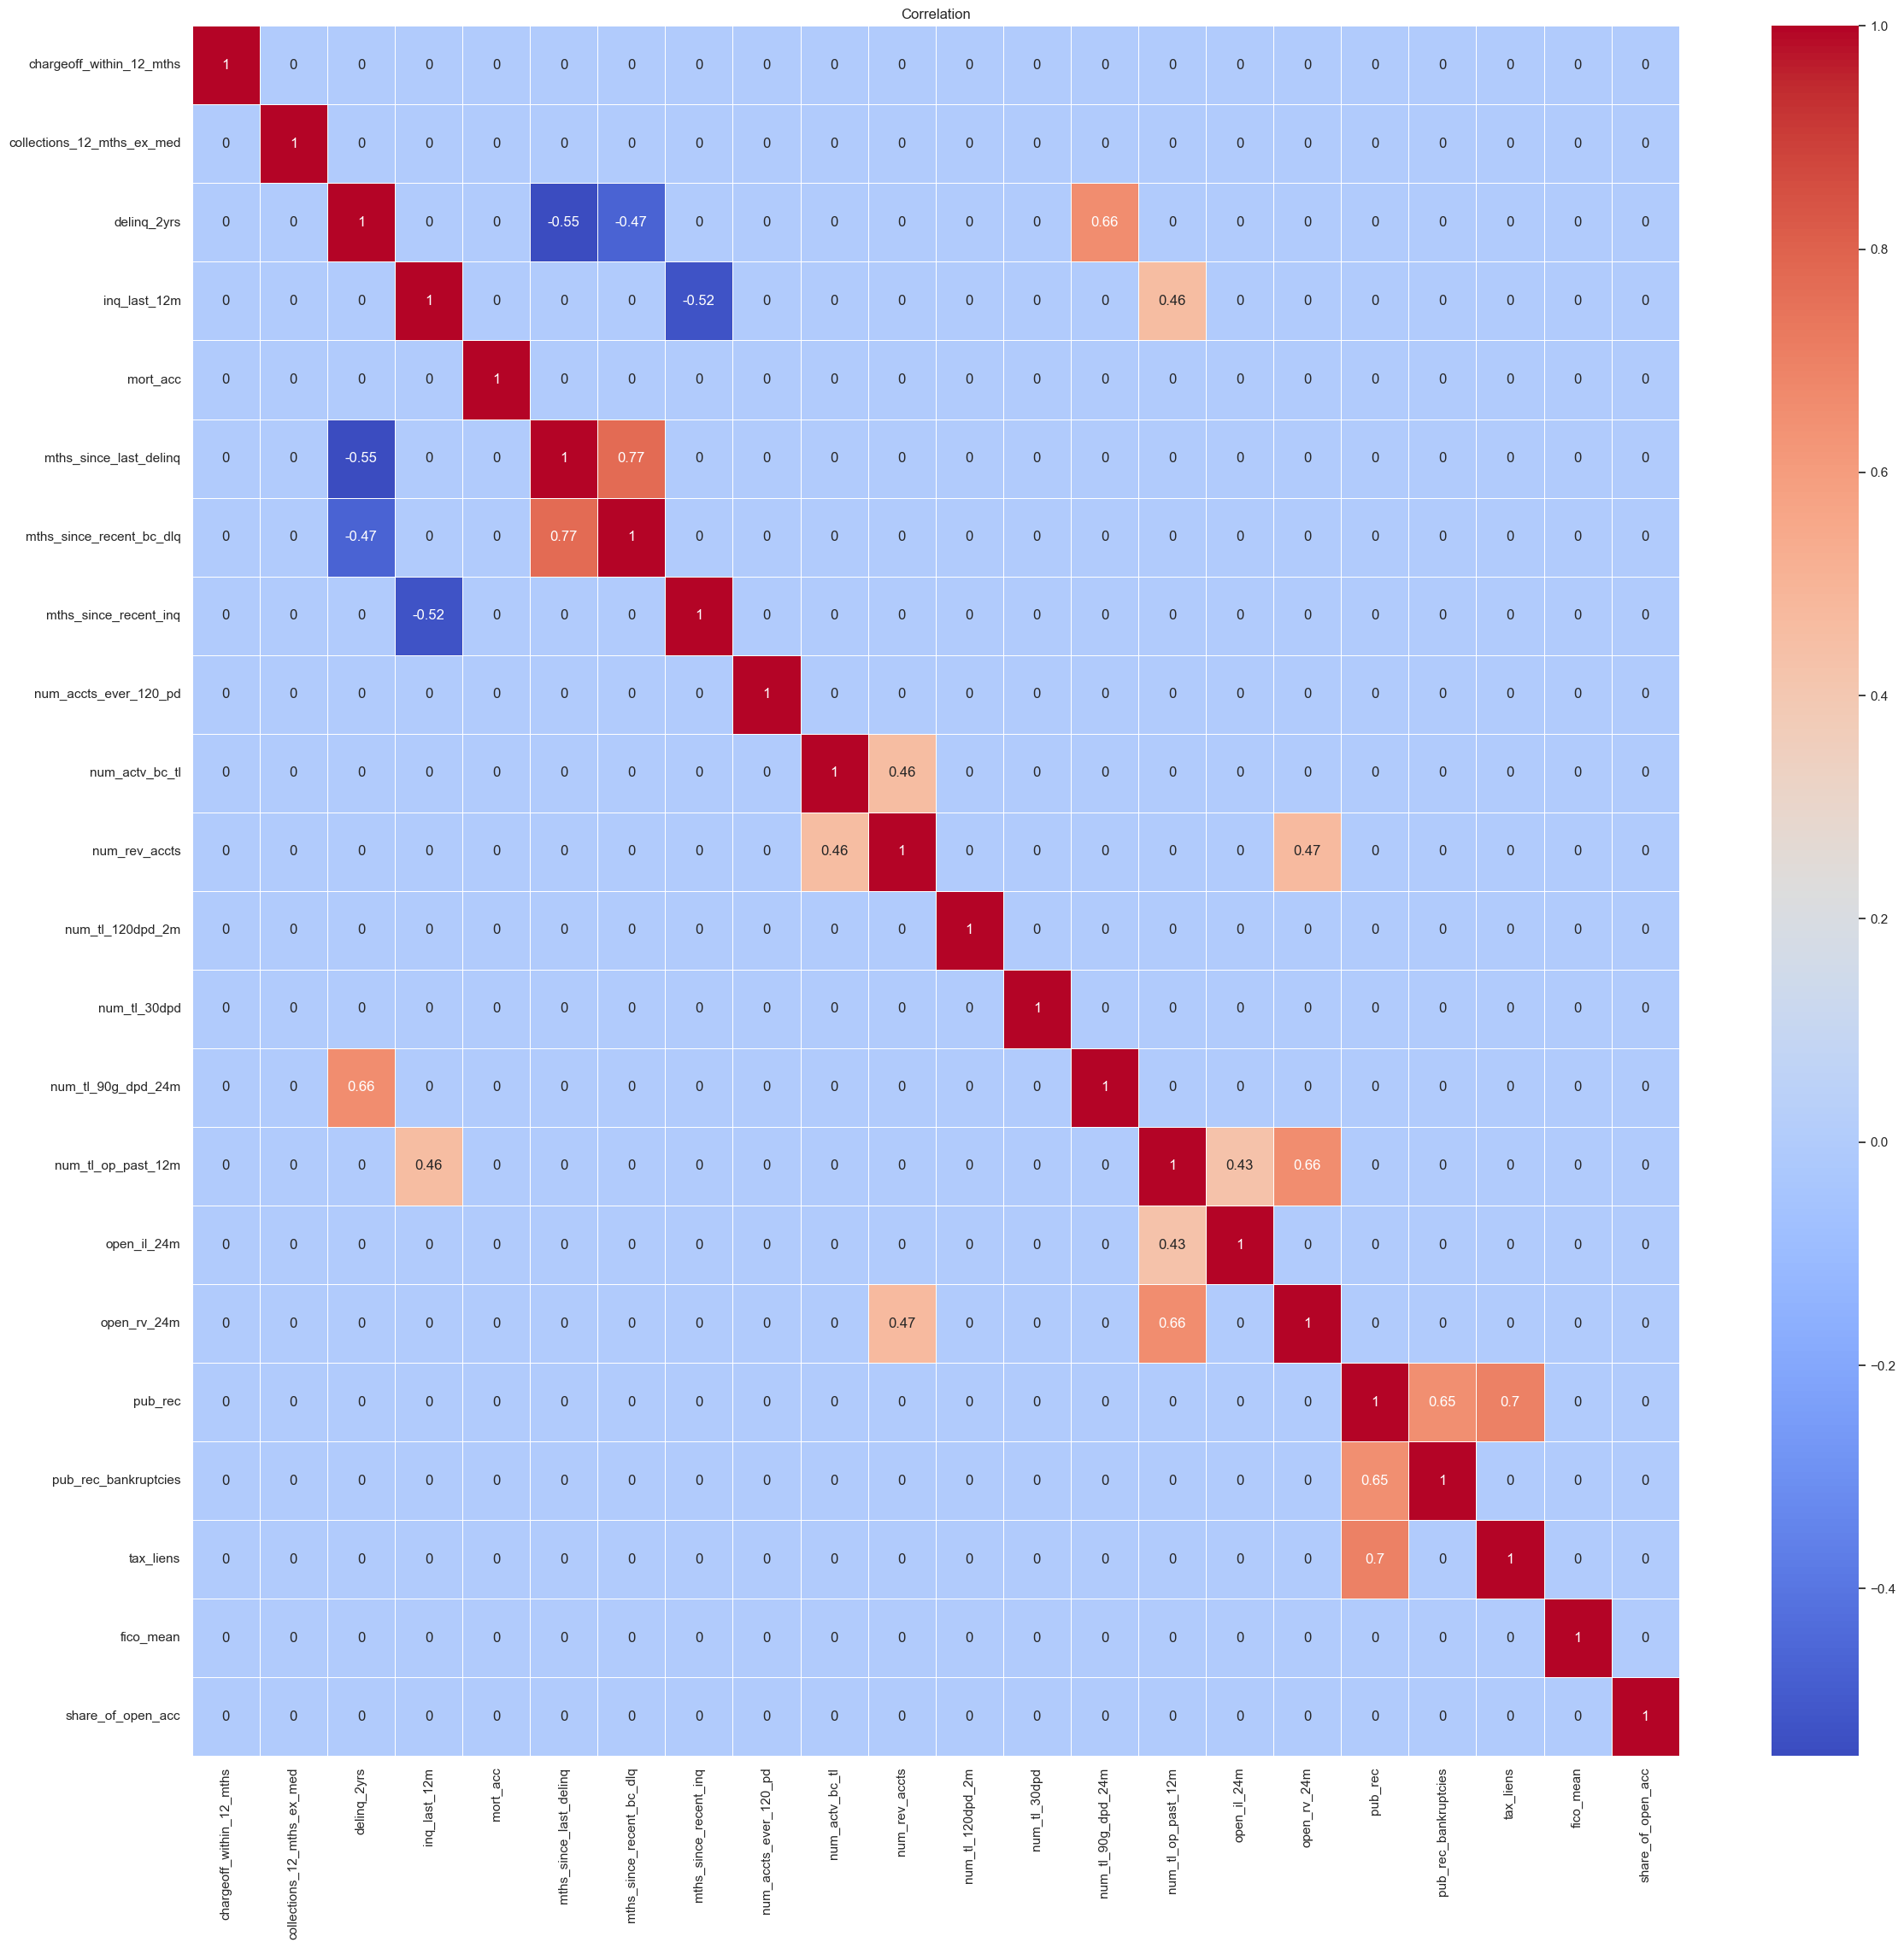

In [90]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.4]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [91]:
df.drop(['mths_since_recent_bc_dlq'], axis=1, inplace=True)
df_num_lim=df[['chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
               'open_il_24m','open_rv_24m','pub_rec','pub_rec_bankruptcies', 'tax_liens','fico_mean','share_of_open_acc']]
df_num_lim.head()

chargeoff_within_12_mths  collections_12_mths_ex_med  delinq_2yrs  \
index                                                                      
0                           0.0                         0.0          0.0   
1                           0.0                         0.0          0.0   
2                           0.0                         0.0          1.0   
3                           0.0                         0.0          0.0   
4                           0.0                         0.0          0.0   

       inq_last_12m  mort_acc  mths_since_last_delinq  mths_since_recent_inq  \
index                                                                          
0               1.0       5.0                    50.0                    6.0   
1               0.0       2.0                     NaN                    NaN   
2               0.0       3.0                    10.0                   13.0   
3               NaN       0.0                     NaN                   16.0   
4               0.0       0.0                    24.0                   15.0   

       num_accts_ever_120_pd  num_actv_bc_tl  num_rev_accts  ...  \
index                                                        ...   
0                        3.0             4.0           17.0  ...   
1                        0.0             3.0            8.0  ...   
2                        0.0             1.0           23.0  ...   
3                        0.0             3.0           11.0  ...   
4                        0.0             1.0            3.0  ...   

       num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  open_il_24m  \
index                                                                      
0               0.0                 0.0                 3.0          2.0   
1               0.0                 0.0                 0.0          0.0   
2               0.0                 0.0                 0.0          0.0   
3               0.0                 0.0                 4.0          NaN   
4               0.0                 0.0                 0.0          3.0   

       open_rv_24m  pub_rec  pub_rec_bankruptcies  tax_liens  fico_mean  \
index                                                                     
0              3.0      1.0                   1.0        0.0      687.0   
1              1.0      1.0                   1.0        0.0      687.0   
2              3.0      0.0                   0.0        0.0      672.0   
3              NaN      0.0                   0.0        0.0      692.0   
4              1.0      0.0                   0.0        0.0      672.0   

       share_of_open_acc  
index                     
0               0.538462  
1               0.454545  
2               0.225806  
3               0.791667  
4               0.250000  

[5 rows x 21 columns]

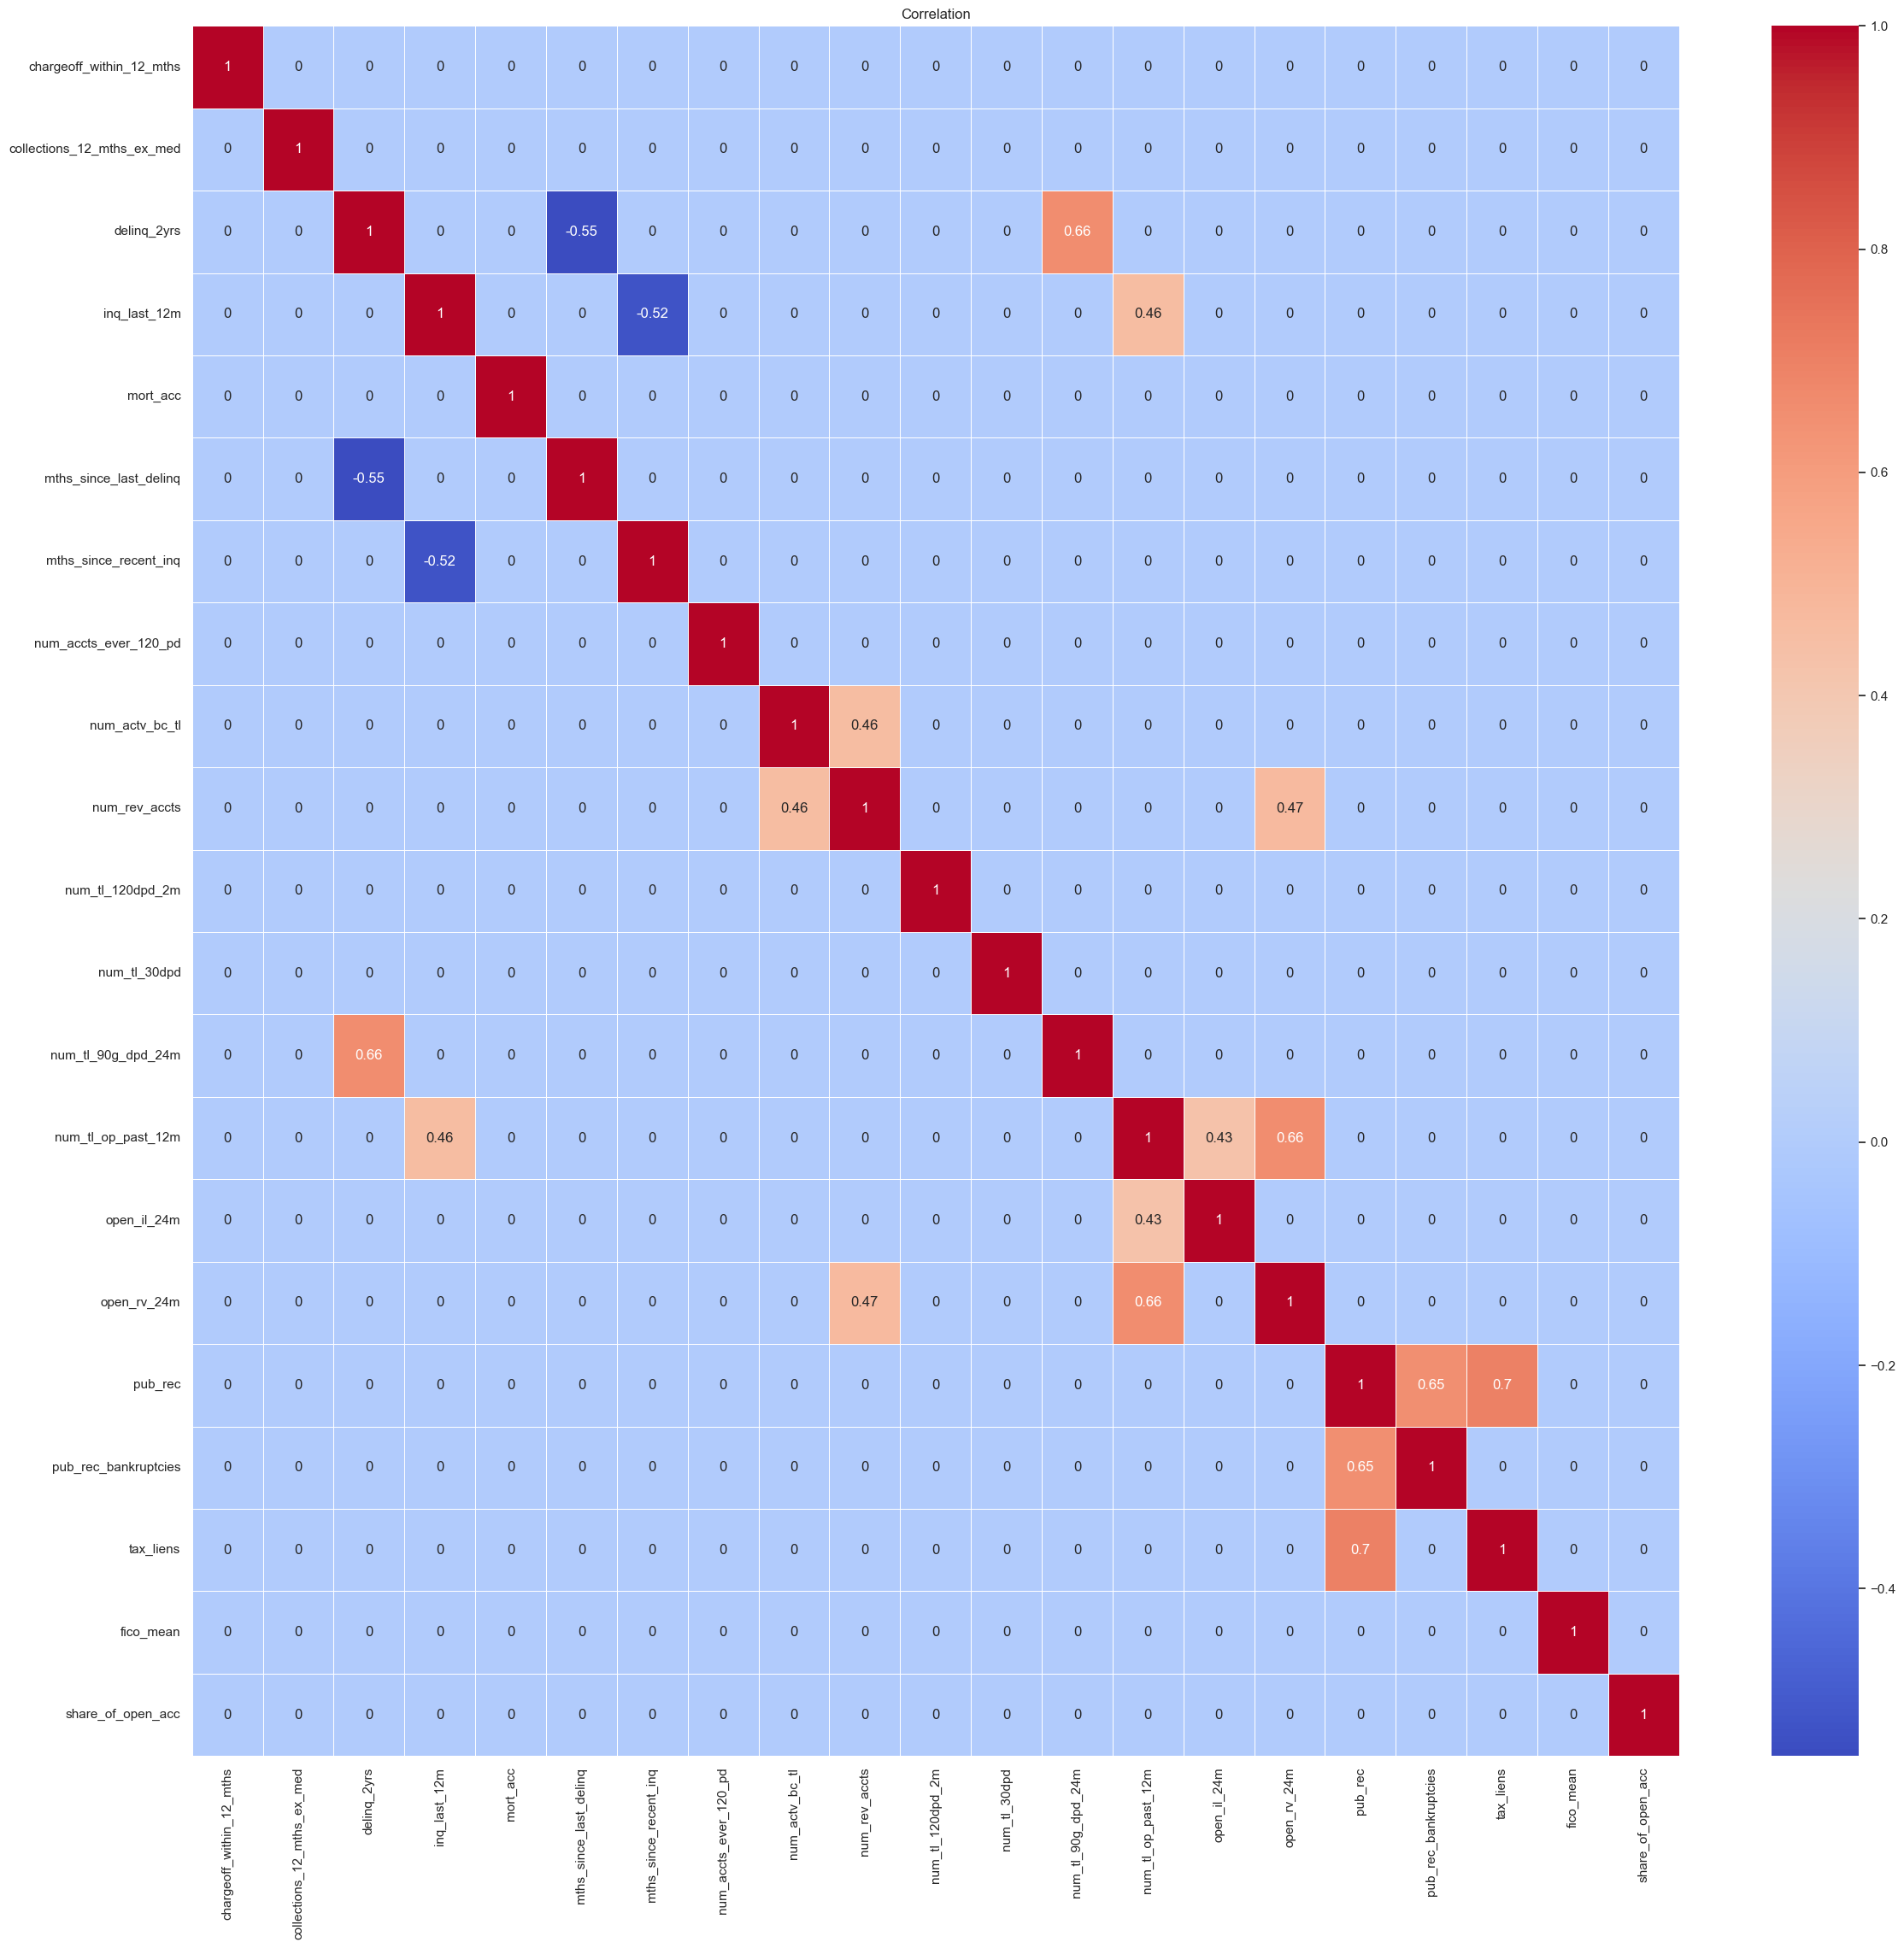

In [92]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.4]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [93]:
df['bad_rec']=(df['pub_rec']+df['pub_rec_bankruptcies'])/2
df.drop(['pub_rec','pub_rec_bankruptcies'], axis=1,inplace=True)
df_num_lim=df[['chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m',
               'open_il_24m','open_rv_24m','tax_liens','fico_mean','share_of_open_acc','bad_rec']]
df_num_lim.head()

chargeoff_within_12_mths  collections_12_mths_ex_med  delinq_2yrs  \
index                                                                      
0                           0.0                         0.0          0.0   
1                           0.0                         0.0          0.0   
2                           0.0                         0.0          1.0   
3                           0.0                         0.0          0.0   
4                           0.0                         0.0          0.0   

       inq_last_12m  mort_acc  mths_since_last_delinq  mths_since_recent_inq  \
index                                                                          
0               1.0       5.0                    50.0                    6.0   
1               0.0       2.0                     NaN                    NaN   
2               0.0       3.0                    10.0                   13.0   
3               NaN       0.0                     NaN                   16.0   
4               0.0       0.0                    24.0                   15.0   

       num_accts_ever_120_pd  num_actv_bc_tl  num_rev_accts  num_tl_120dpd_2m  \
index                                                                           
0                        3.0             4.0           17.0               0.0   
1                        0.0             3.0            8.0               0.0   
2                        0.0             1.0           23.0               0.0   
3                        0.0             3.0           11.0               0.0   
4                        0.0             1.0            3.0               0.0   

       num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  open_il_24m  \
index                                                                      
0               0.0                 0.0                 3.0          2.0   
1               0.0                 0.0                 0.0          0.0   
2               0.0                 0.0                 0.0          0.0   
3               0.0                 0.0                 4.0          NaN   
4               0.0                 0.0                 0.0          3.0   

       open_rv_24m  tax_liens  fico_mean  share_of_open_acc  bad_rec  
index                                                                 
0              3.0        0.0      687.0           0.538462      1.0  
1              1.0        0.0      687.0           0.454545      1.0  
2              3.0        0.0      672.0           0.225806      0.0  
3              NaN        0.0      692.0           0.791667      0.0  
4              1.0        0.0      672.0           0.250000      0.0

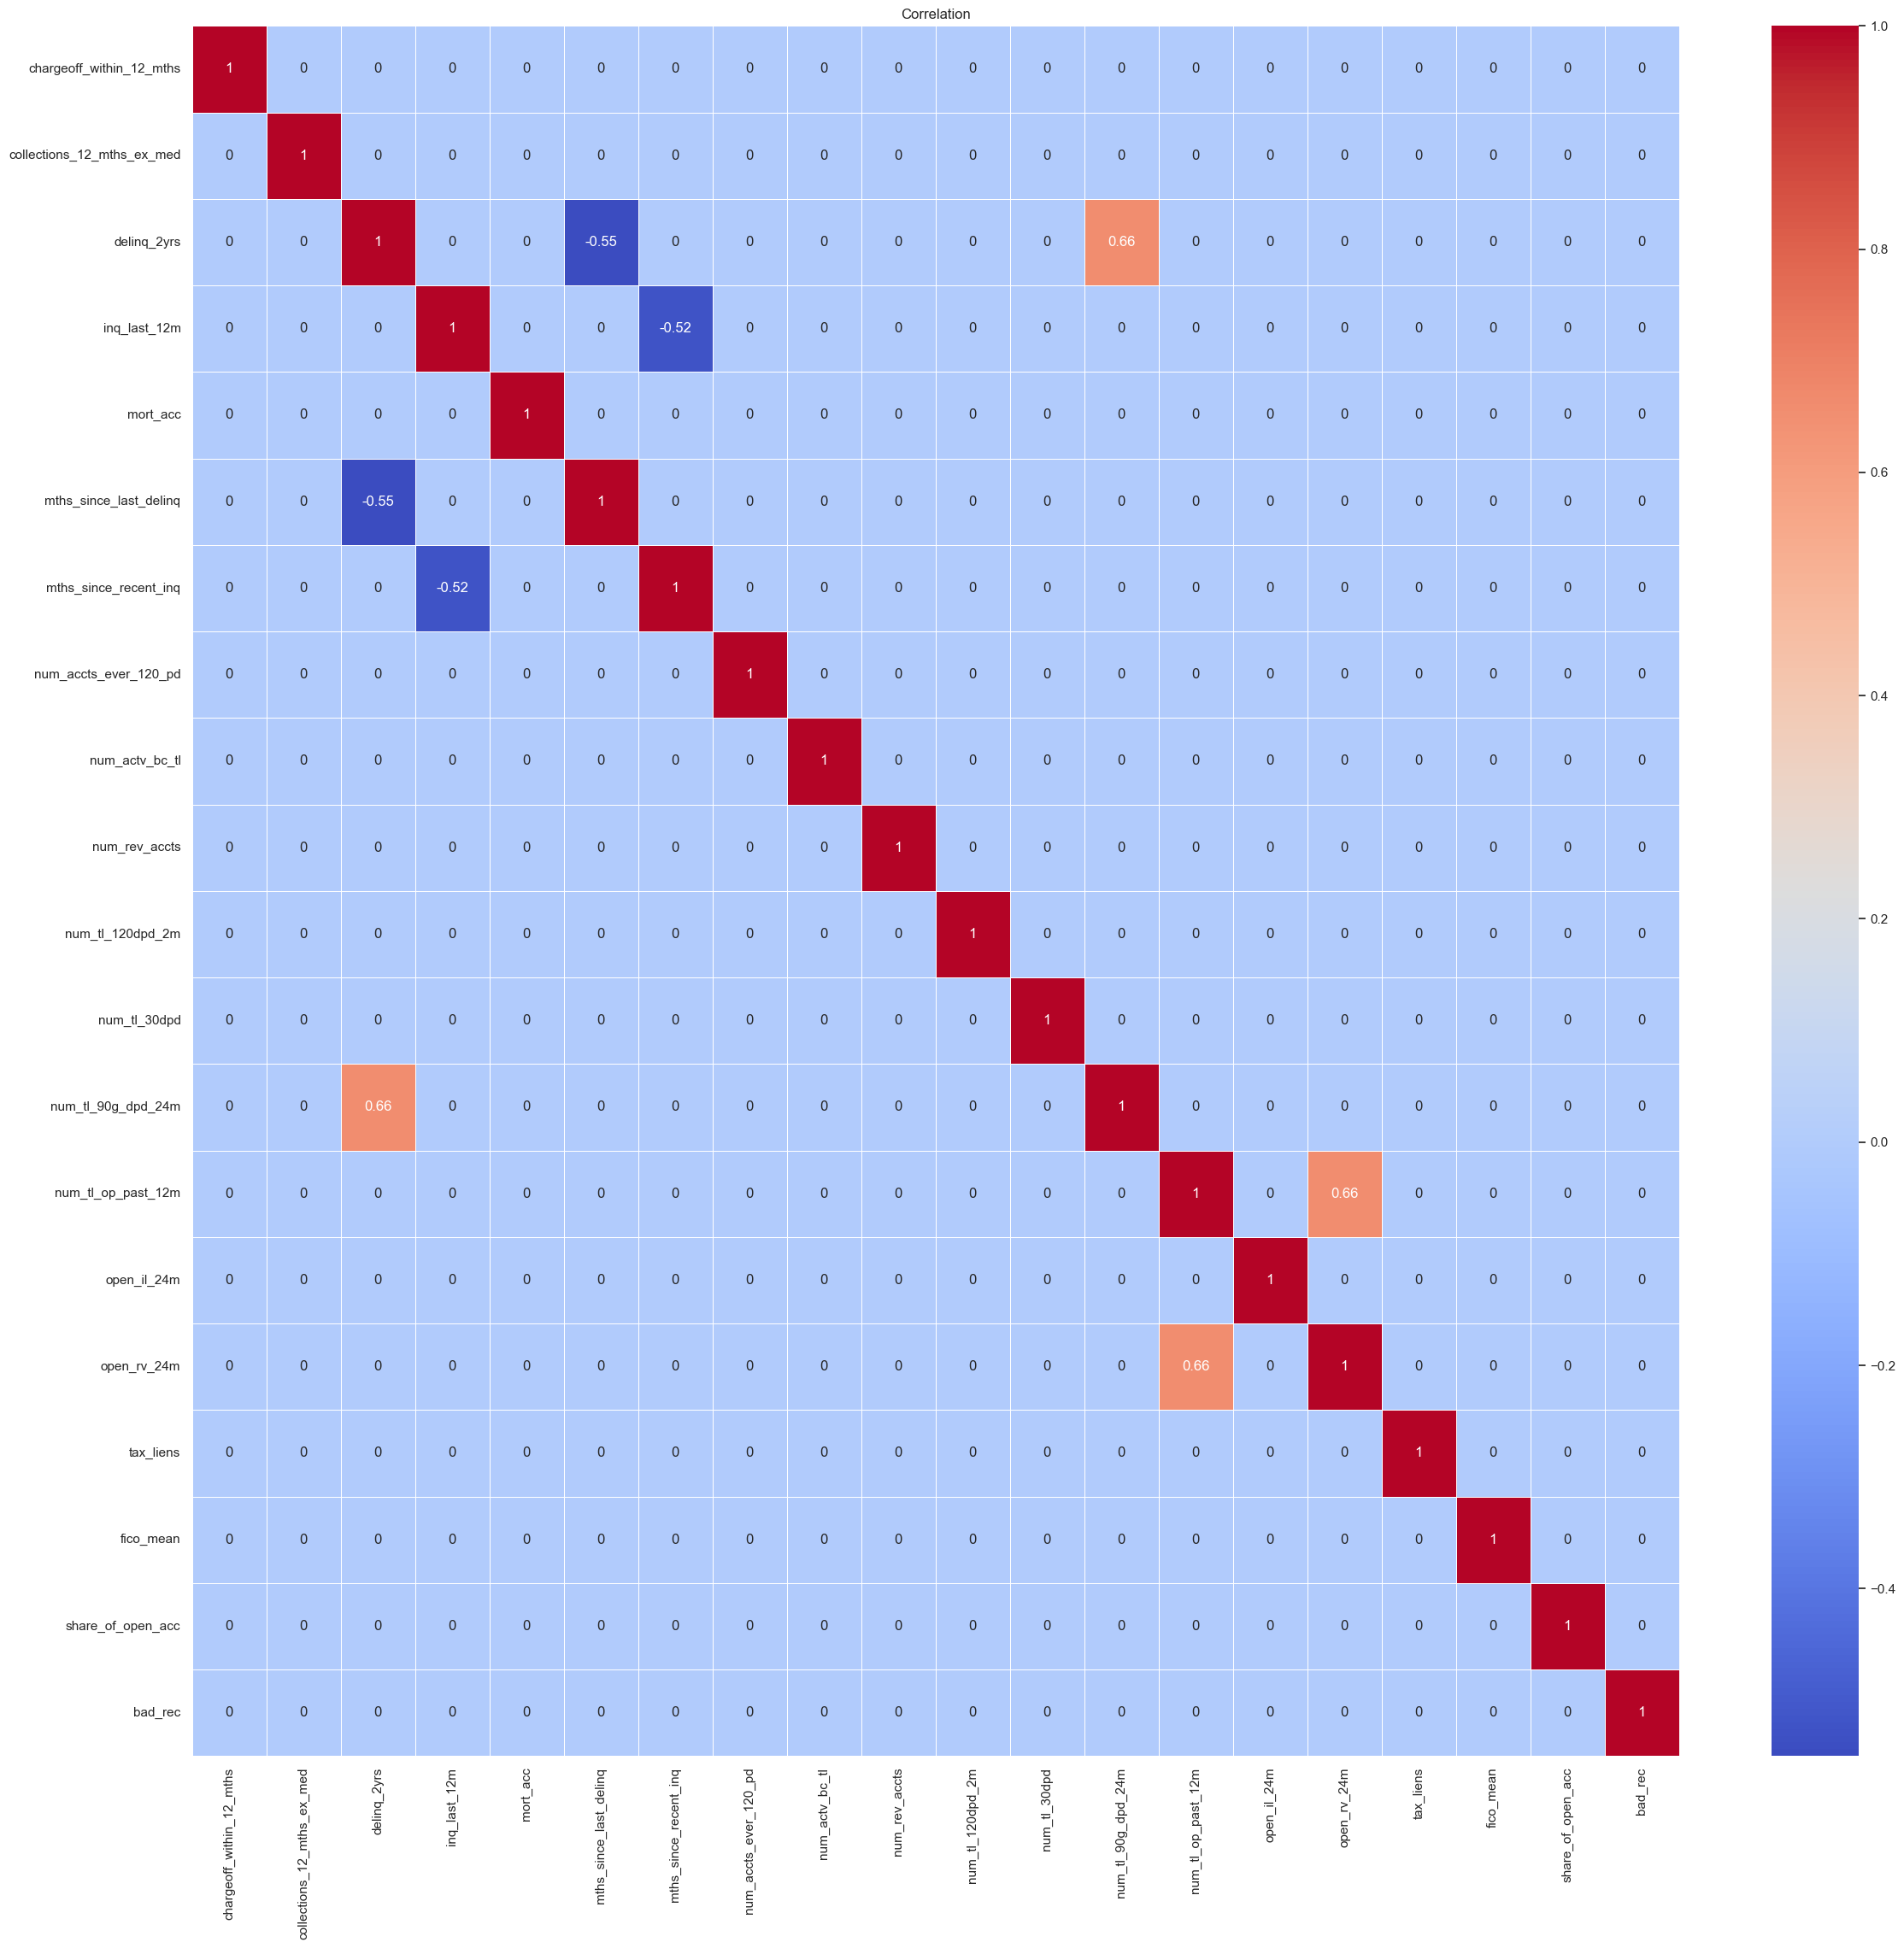

In [94]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.5]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [95]:
zero_data_set_sum=df.isnull().sum()
zero_data_set_percentage=df.isnull().sum()/df.shape[0]*100
zero_data_set=pd.DataFrame({'sum':zero_data_set_sum, 'percentage': zero_data_set_percentage})
zero_data_set[zero_data_set['sum']>0].head(40)

sum  percentage
chargeoff_within_12_mths        37    0.003084
collections_12_mths_ex_med      37    0.003084
inq_last_12m                567215   47.273393
mort_acc                     31541    2.628721
mths_since_last_delinq      607443   50.626114
mths_since_recent_inq       149781   12.483196
num_accts_ever_120_pd        45009    3.751185
num_actv_bc_tl               45009    3.751185
num_rev_accts                45010    3.751268
num_tl_120dpd_2m             90608    7.551541
num_tl_30dpd                 45009    3.751185
num_tl_90g_dpd_24m           45009    3.751185
num_tl_op_past_12m           45009    3.751185
open_il_24m                 567214   47.273309
open_rv_24m                 567214   47.273309
percent_bc_gt_75             44334    3.694928
revol_util                     841    0.070091
tax_liens                       28    0.002334
bad_rec                        467    0.038921

In [96]:
df['number_of_rv_for_12m']=df['open_rv_24m']/2
df.drop(['num_tl_op_past_12m','open_rv_24m'], axis=1,inplace=True)
df_num_lim=df[['chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs',
             'inq_last_12m','mort_acc','mths_since_last_delinq',
             'mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl',
             'num_rev_accts','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m',
               'open_il_24m','tax_liens','fico_mean','share_of_open_acc','bad_rec', 'number_of_rv_for_12m']]
df_num_lim.head()

chargeoff_within_12_mths  collections_12_mths_ex_med  delinq_2yrs  \
index                                                                      
0                           0.0                         0.0          0.0   
1                           0.0                         0.0          0.0   
2                           0.0                         0.0          1.0   
3                           0.0                         0.0          0.0   
4                           0.0                         0.0          0.0   

       inq_last_12m  mort_acc  mths_since_last_delinq  mths_since_recent_inq  \
index                                                                          
0               1.0       5.0                    50.0                    6.0   
1               0.0       2.0                     NaN                    NaN   
2               0.0       3.0                    10.0                   13.0   
3               NaN       0.0                     NaN                   16.0   
4               0.0       0.0                    24.0                   15.0   

       num_accts_ever_120_pd  num_actv_bc_tl  num_rev_accts  num_tl_120dpd_2m  \
index                                                                           
0                        3.0             4.0           17.0               0.0   
1                        0.0             3.0            8.0               0.0   
2                        0.0             1.0           23.0               0.0   
3                        0.0             3.0           11.0               0.0   
4                        0.0             1.0            3.0               0.0   

       num_tl_30dpd  num_tl_90g_dpd_24m  open_il_24m  tax_liens  fico_mean  \
index                                                                        
0               0.0                 0.0          2.0        0.0      687.0   
1               0.0                 0.0          0.0        0.0      687.0   
2               0.0                 0.0          0.0        0.0      672.0   
3               0.0                 0.0          NaN        0.0      692.0   
4               0.0                 0.0          3.0        0.0      672.0   

       share_of_open_acc  bad_rec  number_of_rv_for_12m  
index                                                    
0               0.538462      1.0                   1.5  
1               0.454545      1.0                   0.5  
2               0.225806      0.0                   1.5  
3               0.791667      0.0                   NaN  
4               0.250000      0.0                   0.5

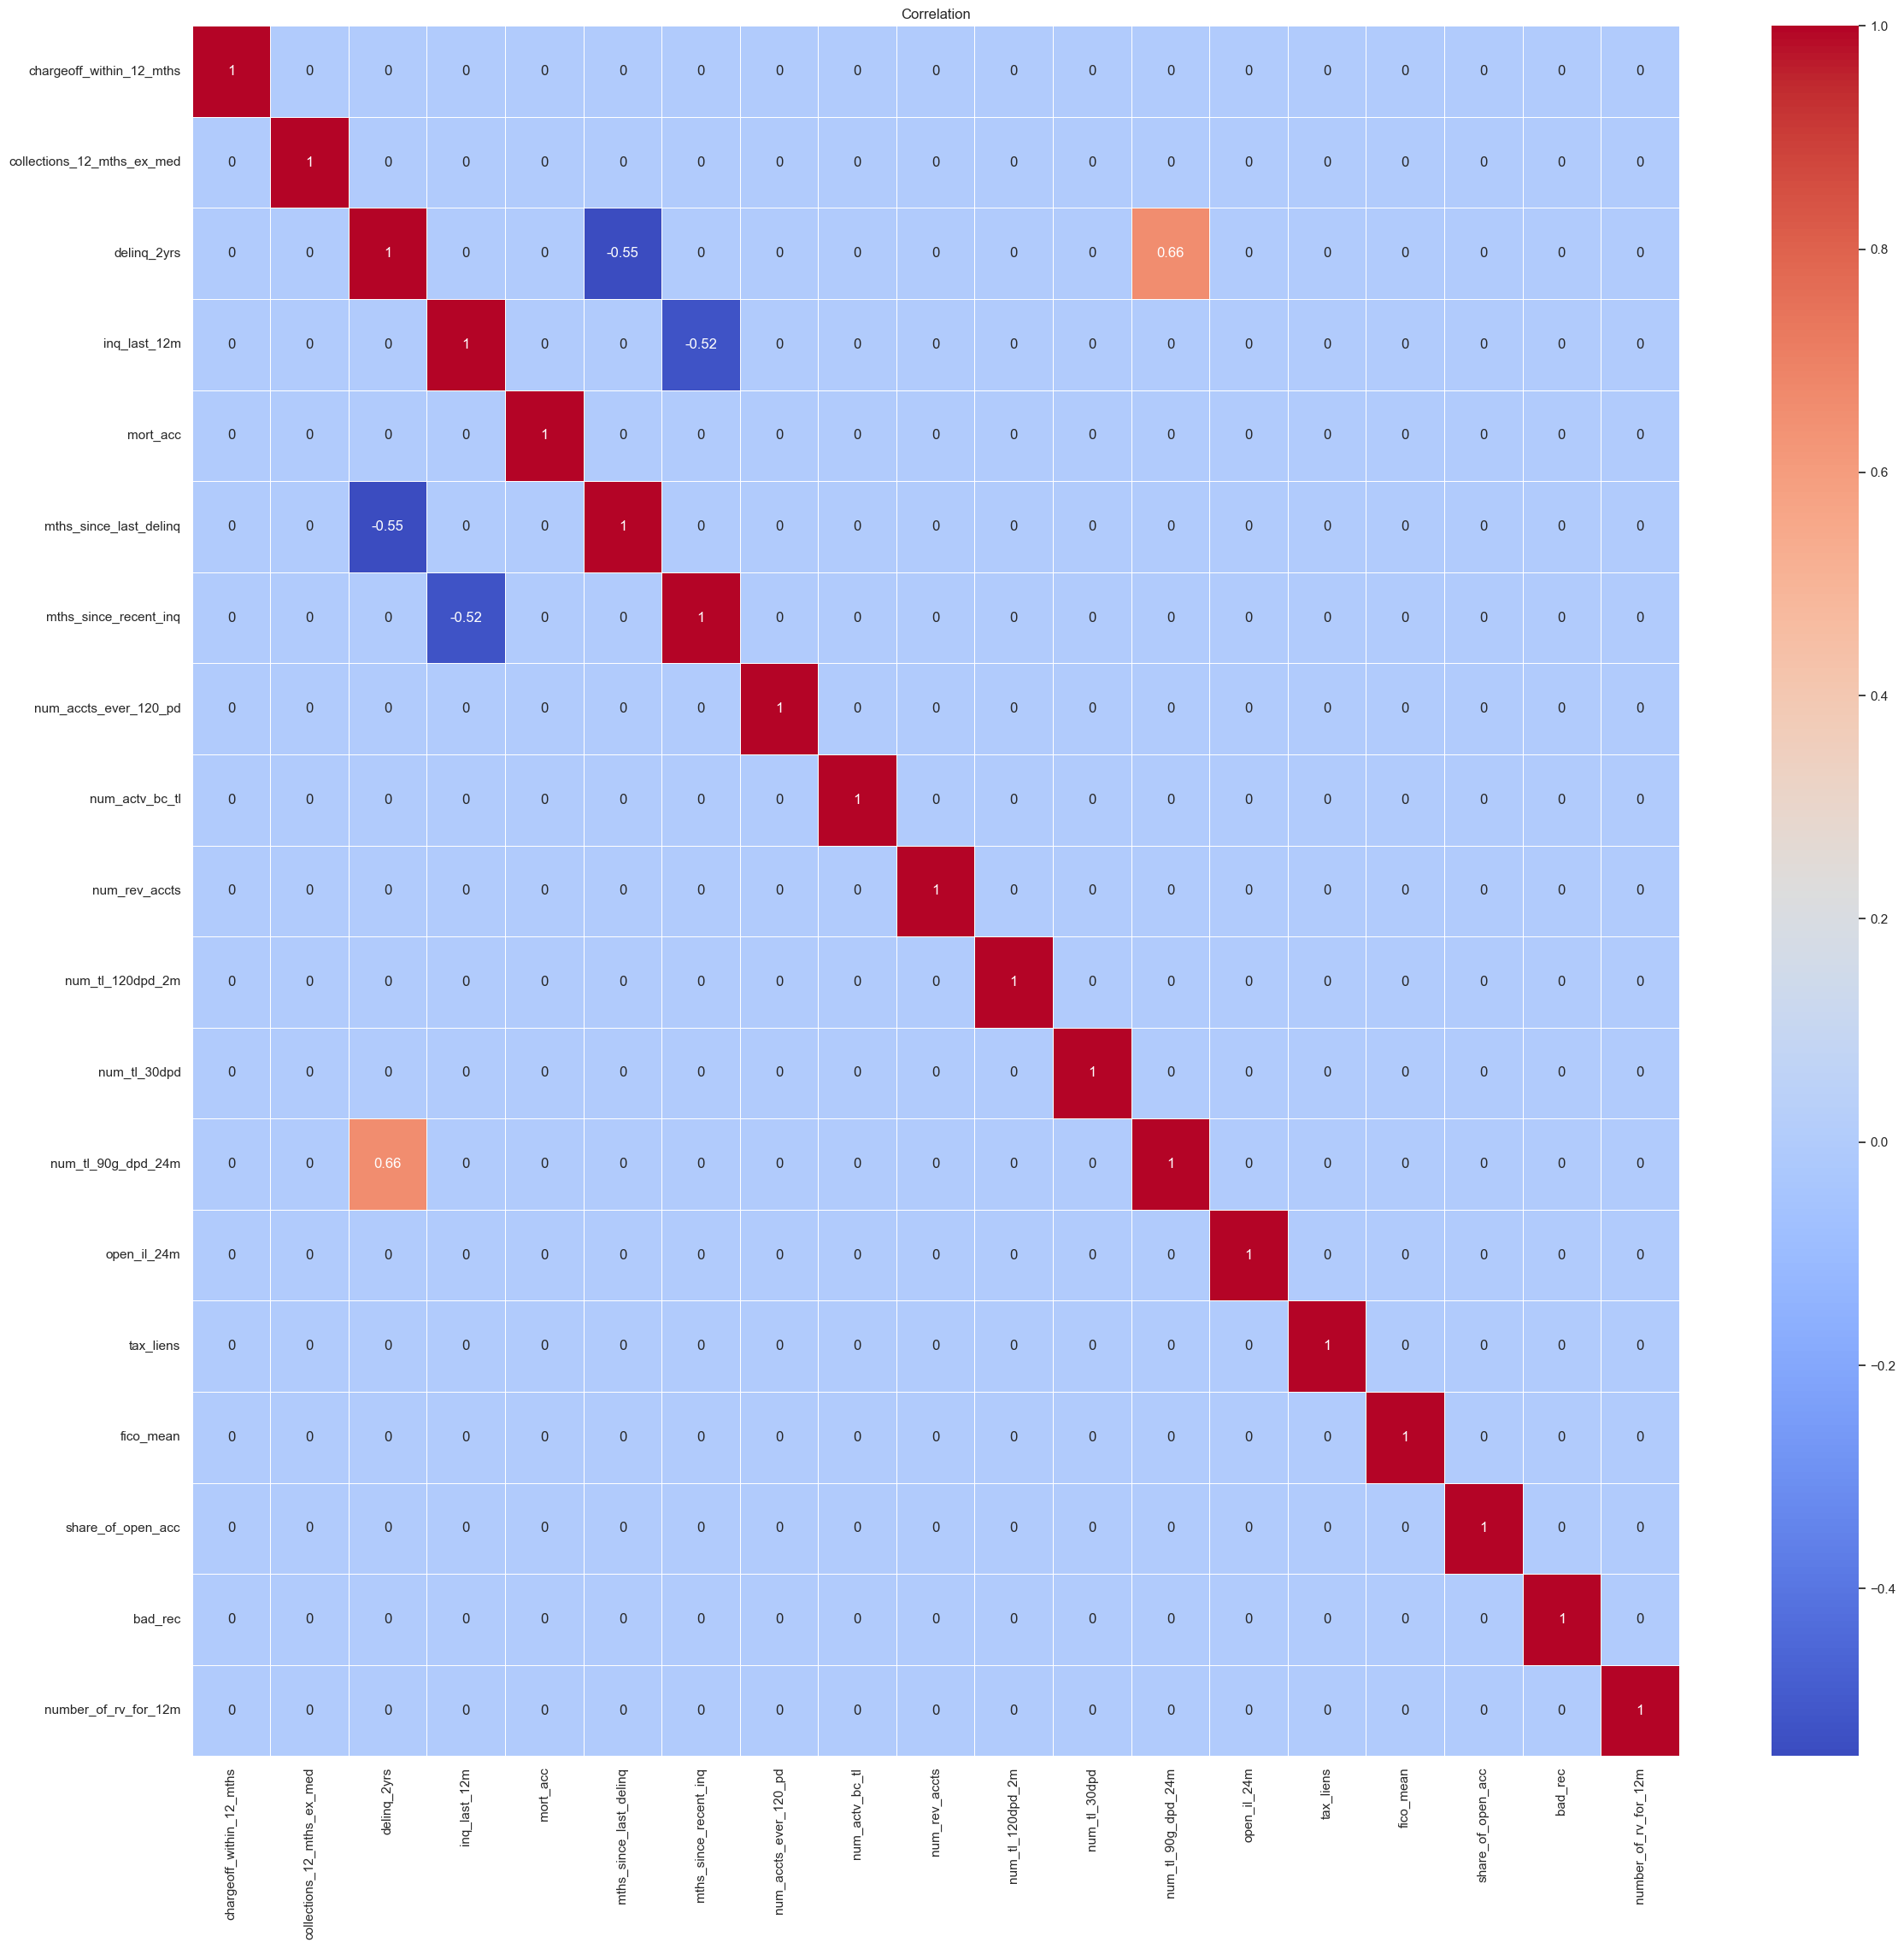

In [97]:
plt.figure(figsize=(25,25))

sns.set(font_scale=1)

corr_matrix=df_num_lim.corr()
corr_matrix=np.round(corr_matrix,2)
corr_matrix[np.abs(corr_matrix)<0.5]=0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation')
plt.show()

In [98]:
df.drop(['emp_length'], axis=1, inplace=True)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 35 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   annual_inc                  1199861 non-null  float64
 1   chargeoff_within_12_mths    1199824 non-null  float64
 2   collections_12_mths_ex_med  1199824 non-null  float64
 3   delinq_2yrs                 1199861 non-null  float64
 4   dti                         1199861 non-null  float64
 5   funded_amnt                 1199861 non-null  float64
 6   home_ownership              1199861 non-null  int64  
 7   inq_last_12m                632646 non-null   float64
 8   installment                 1199861 non-null  float64
 9   int_rate                    1199861 non-null  float64
 10  loan_amnt                   1199861 non-null  float64
 11  mort_acc                    1168320 non-null  float64
 12  mths_since_last_delinq      592418 non-null   float64
 1

In [100]:
data_term=pd.crosstab(df['term'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data_term.head()

loan_status  term         0         1
0               1  0.844724  0.155276
1               2  0.691773  0.308227

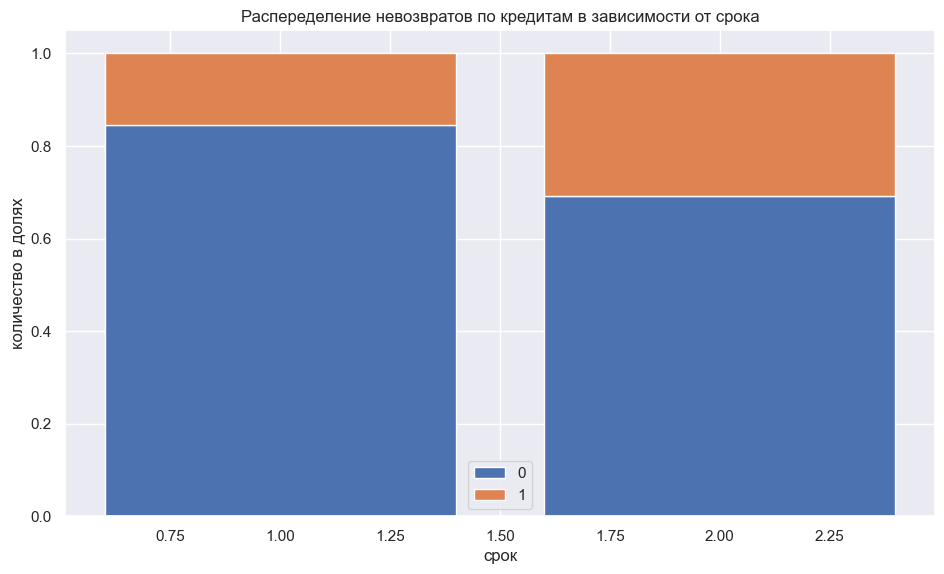

In [101]:
plt.figure(figsize=(10,6))
plt.bar(data_term['term'], data_term[0], label='0')
plt.bar(data_term['term'], data_term[1], bottom=data_term[0], label='1')
plt.title('Распеределение невозвратов по кредитам в зависимости от срока')
plt.xlabel('срок')
plt.ylabel('количество в долях')
plt.legend()
plt.xticks()
plt.show()
# plt.figure(figsize=(12,10))
# plt.bar(data_else['emp_length'], data_else[0], label='0')
# plt.bar(data_else['emp_length'], data_else[1], bottom=data_else[0], label='1')
# plt.title('Сравнение возврата кредита в зависимости от стажа указанного при заявке')
# plt.xlabel('стаж')
# plt.ylabel('количество аналогичных случаев')
# plt.legend()
# plt.xticks()
# plt.show()

In [102]:
df['purpose'].unique().shape

(14,)

In [103]:
df['purpose'].replace(['credit_card', 'car', 'other', 'debt_consolidation',
       'major_purchase', 'small_business', 'home_improvement', 'moving',
       'medical', 'wedding', 'vacation', 'house', 'renewable_energy',
       'educational'], [0,1,2,3,4,5,6,7,8,9,10,11,12,13], inplace=True)
df['purpose'].value_counts()

4     684522
1     268419
7      78972
3      73218
5      26885
9      14327
6      13462
2      13214
11      8686
8       8423
12      7143
10      1555
13       827
14       208
Name: purpose, dtype: int64

In [104]:
data_ver=pd.crosstab(df['verification_status'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data_ver.head()

loan_status  verification_status         0         1
1                              2  0.850939  0.149061
0                              1  0.799828  0.200172
2                              3  0.768710  0.231290

In [105]:
data_home=pd.crosstab(df['home_ownership'], df['loan_status'], normalize='index').reset_index().sort_values(by=1)
data_home.head()

loan_status  home_ownership         0         1
1                         2  0.833604  0.166396
2                         3  0.801856  0.198144
0                         1  0.776000  0.224000

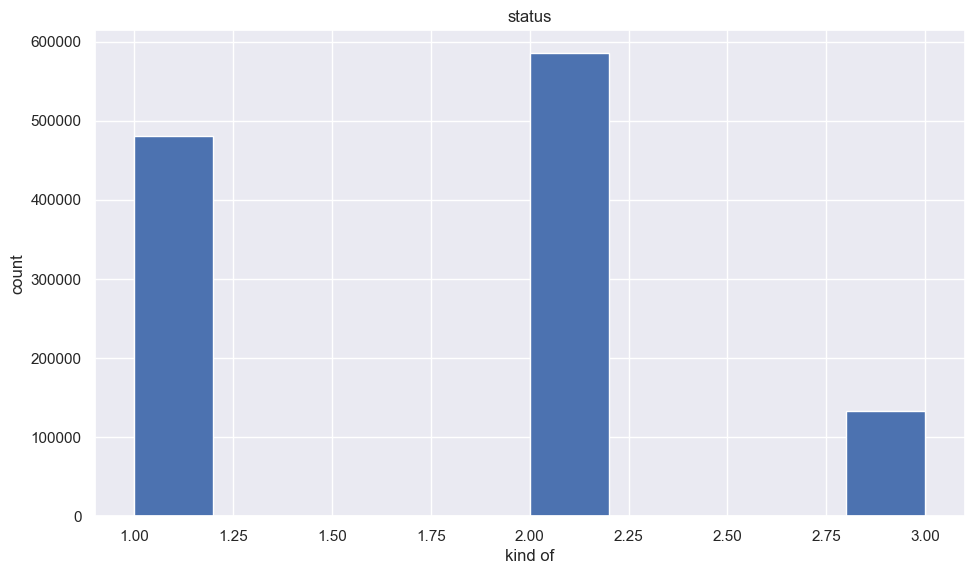

In [106]:
plt.figure(figsize=(10,6))
plt.hist(df['home_ownership'], bins=10)
plt.title('status')
plt.xlabel('kind of')
plt.ylabel('count')
plt.show()

In [107]:
ownership_mode=df['home_ownership'].mode()[0]
ownership_mode

2

In [108]:
df['home_ownership'].unique()

array([1, 2, 3], dtype=int64)

In [109]:
df['home_ownership'].replace(['OTHER', 'ANY', 'NONE'],['MORTGAGE','MORTGAGE','MORTGAGE'], inplace=True)

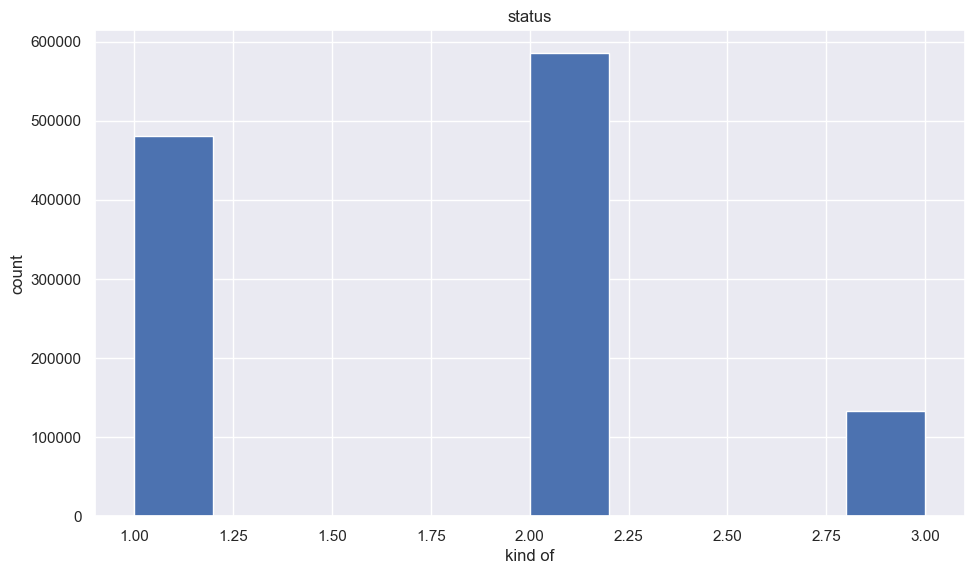

In [110]:
plt.figure(figsize=(10,6))
plt.hist(df['home_ownership'], bins=10)
plt.title('status')
plt.xlabel('kind of')
plt.ylabel('count')
plt.show()

In [111]:
df['home_ownership'].unique()

array([1, 2, 3], dtype=int64)

In [112]:
df['home_ownership'].replace(['RENT', 'MORTGAGE', 'OWN'], [0,1,3], inplace=True)
df['home_ownership'].value_counts()

2    585224
1    481209
3    133428
Name: home_ownership, dtype: int64

In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1199861 entries, 0 to 1199860
Data columns (total 35 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   annual_inc                  1199861 non-null  float64
 1   chargeoff_within_12_mths    1199824 non-null  float64
 2   collections_12_mths_ex_med  1199824 non-null  float64
 3   delinq_2yrs                 1199861 non-null  float64
 4   dti                         1199861 non-null  float64
 5   funded_amnt                 1199861 non-null  float64
 6   home_ownership              1199861 non-null  int64  
 7   inq_last_12m                632646 non-null   float64
 8   installment                 1199861 non-null  float64
 9   int_rate                    1199861 non-null  float64
 10  loan_amnt                   1199861 non-null  float64
 11  mort_acc                    1168320 non-null  float64
 12  mths_since_last_delinq      592418 non-null   float64
 1

In [114]:
df['term'].unique()

array([1, 2], dtype=int64)

In [115]:
df['term'].replace([' 36 months', ' 60 months'], [0,1], inplace=True)
df['term'].value_counts()

1    903699
2    296162
Name: term, dtype: int64

In [117]:
df.columns

Index(['annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'delinq_2yrs', 'dti', 'funded_amnt', 'home_ownership', 'inq_last_12m',
       'installment', 'int_rate', 'loan_amnt', 'mort_acc',
       'mths_since_last_delinq', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts',
       'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'open_il_24m',
       'percent_bc_gt_75', 'purpose', 'revol_util', 'tax_liens', 'term',
       'verification_status', 'loan_status', 'fico_mean', 'share_of_open_acc',
       'bad_rec', 'credit_load', 'year', 'month', 'number_of_rv_for_12m'],
      dtype='object')

In [118]:
df['credit_load']=df['installment']*12/df['annual_inc']

In [119]:
compare_date1=df[['credit_load', 'loan_status']]
compare_date2=df[['chargeoff_within_12_mths', 'loan_status']]
compare_date3=df[['collections_12_mths_ex_med', 'loan_status']]
compare_date4=df[['delinq_2yrs', 'loan_status']]
compare_date5=df[['dti', 'loan_status']]
compare_date6=df[['funded_amnt', 'loan_status']]
compare_date7=df[['home_ownership', 'loan_status']]
compare_date8=df[['inq_last_12m', 'loan_status']]
compare_date9=df[['installment', 'loan_status']]
compare_date10=df[['mths_since_last_delinq', 'loan_status']]
compare_date11=df[['mths_since_recent_inq', 'loan_status']]
compare_date12=df[['num_accts_ever_120_pd', 'loan_status']]
compare_date13=df[['num_actv_bc_tl', 'loan_status']]
compare_date14=df[['num_rev_accts', 'loan_status']]
compare_date15=df[['num_tl_120dpd_2m', 'loan_status']]
compare_date16=df[['num_tl_30dpd', 'loan_status']]
compare_date17=df[['num_tl_90g_dpd_24m', 'loan_status']]
compare_date18=df[['open_il_24m', 'loan_status']]
compare_date19=df[['percent_bc_gt_75', 'loan_status']]
compare_date20=df[['revol_util', 'loan_status']]
compare_date21=df[['tax_liens', 'loan_status']]
compare_date22=df[['fico_mean', 'loan_status']]
compare_date23=df[['share_of_open_acc', 'loan_status']]
compare_date24=df[['bad_rec', 'loan_status']]
compare_date25=df[['number_of_rv_for_12m', 'loan_status']]
compare_date26=df[['int_rate', 'loan_status']]
compare_date27=df[['loan_amnt', 'loan_status']]
compare_date28=df[['mort_acc', 'loan_status']]
compare_date29=df[['purpose', 'loan_status']]

In [120]:
compare_date1.head()

credit_load  loan_status
index                          
0         0.080854            1
1         0.031357            0
2         0.082802            1
3         0.039592            0
4         0.103263            0

In [121]:
compare_date25.iloc[:,0]

index
0          1.5
1          0.5
2          1.5
3          NaN
4          0.5
          ... 
1199856    NaN
1199857    NaN
1199858    NaN
1199859    NaN
1199860    NaN
Name: number_of_rv_for_12m, Length: 1199861, dtype: float64

In [122]:
compare_date25.columns[1]

'loan_status'

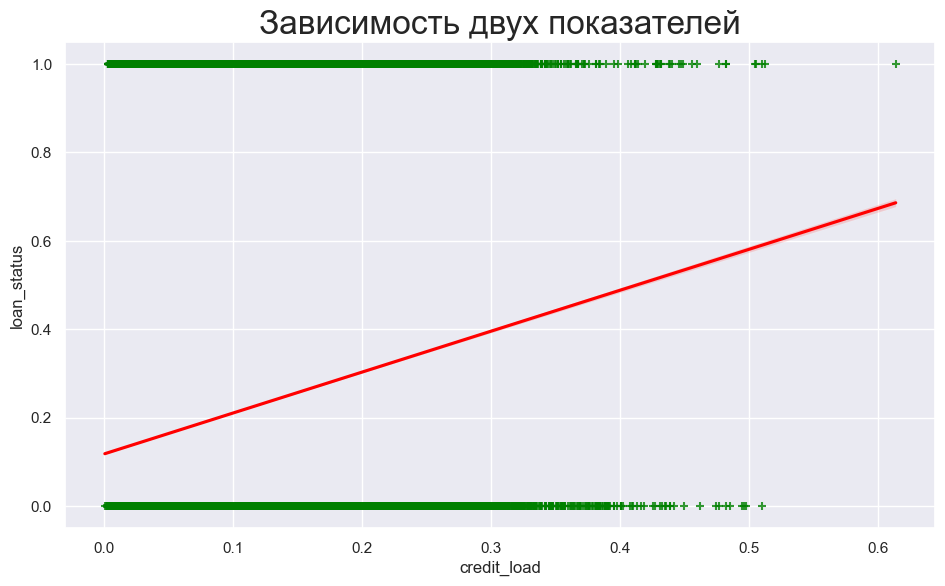

In [123]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date1.iloc[:,0], y=compare_date1.iloc[:,1], data=compare_date1, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date1.columns[0], ylabel=compare_date1.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

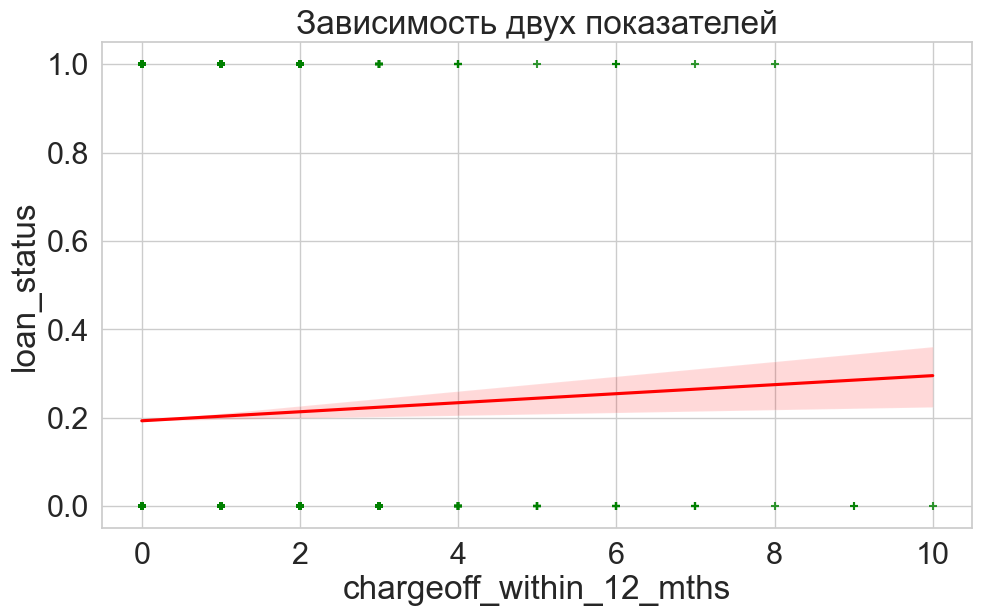

In [124]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date2.iloc[:,0], y=compare_date2.iloc[:,1], data=compare_date2, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date2.columns[0], ylabel=compare_date2.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

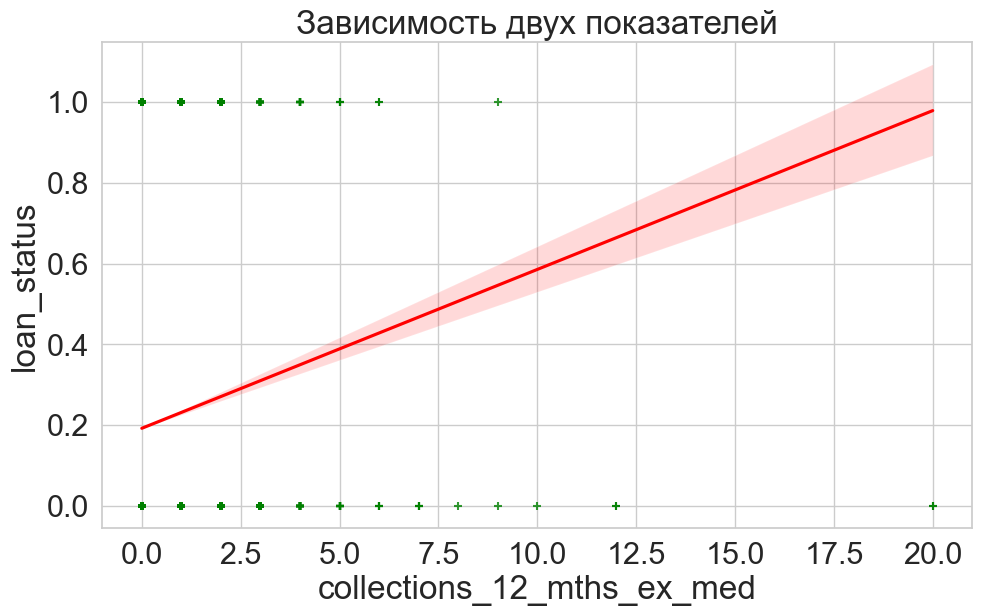

In [125]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date3.iloc[:,0], y=compare_date3.iloc[:,1], data=compare_date3, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date3.columns[0], ylabel=compare_date3.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

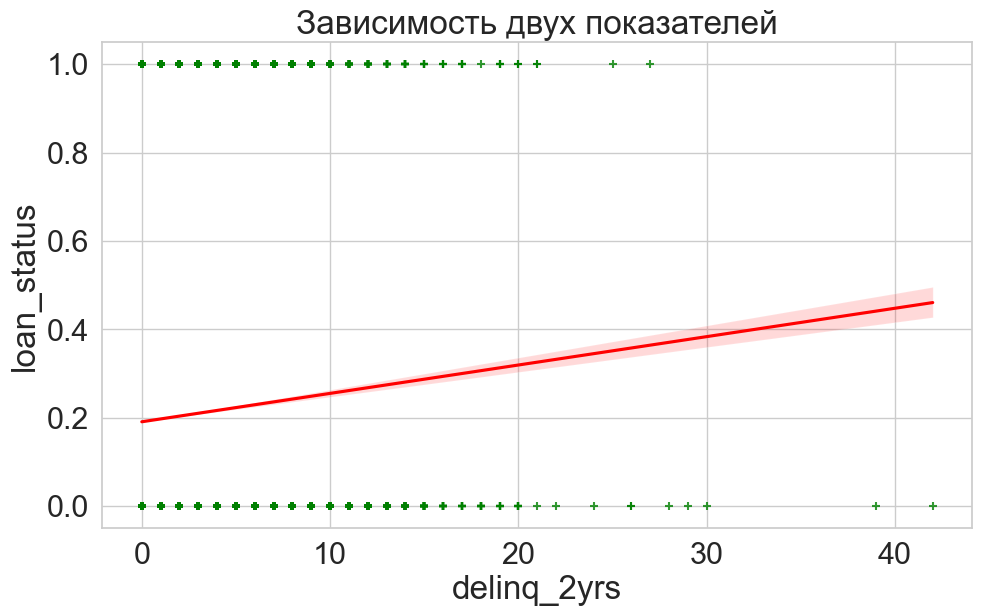

In [126]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date4.iloc[:,0], y=compare_date4.iloc[:,1], data=compare_date4, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date4.columns[0], ylabel=compare_date4.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

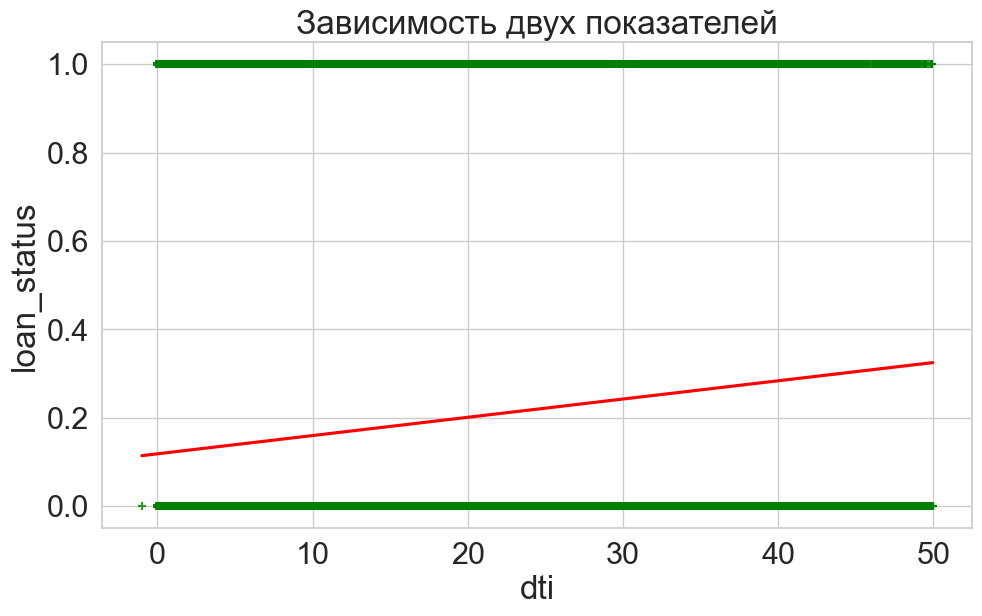

In [127]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date5.iloc[:,0], y=compare_date5.iloc[:,1], data=compare_date5, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date5.columns[0], ylabel=compare_date5.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

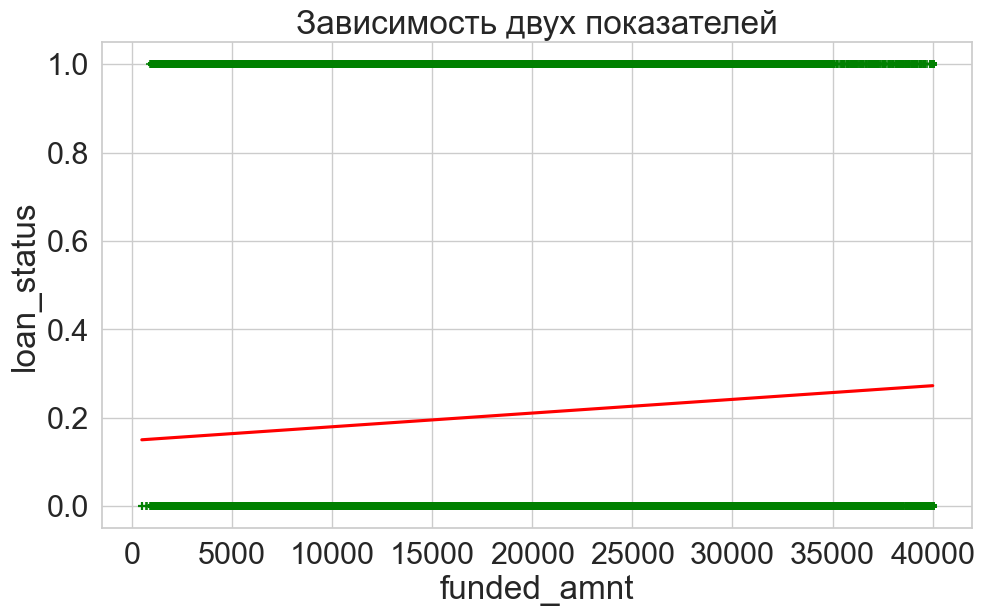

In [128]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date6.iloc[:,0], y=compare_date6.iloc[:,1], data=compare_date6, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date6.columns[0], ylabel=compare_date6.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

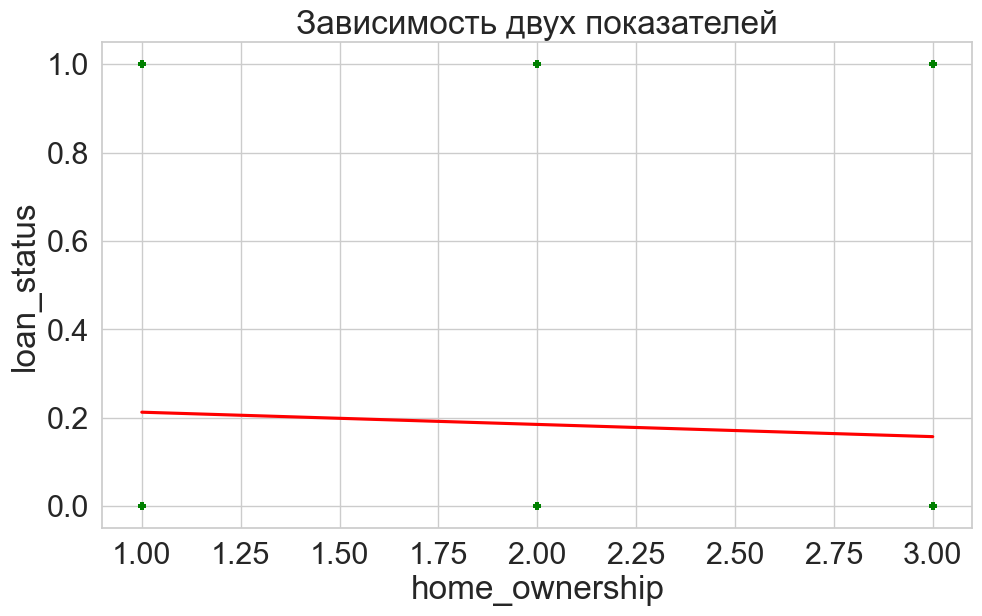

In [129]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date7.iloc[:,0], y=compare_date7.iloc[:,1], data=compare_date7, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date7.columns[0], ylabel=compare_date7.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

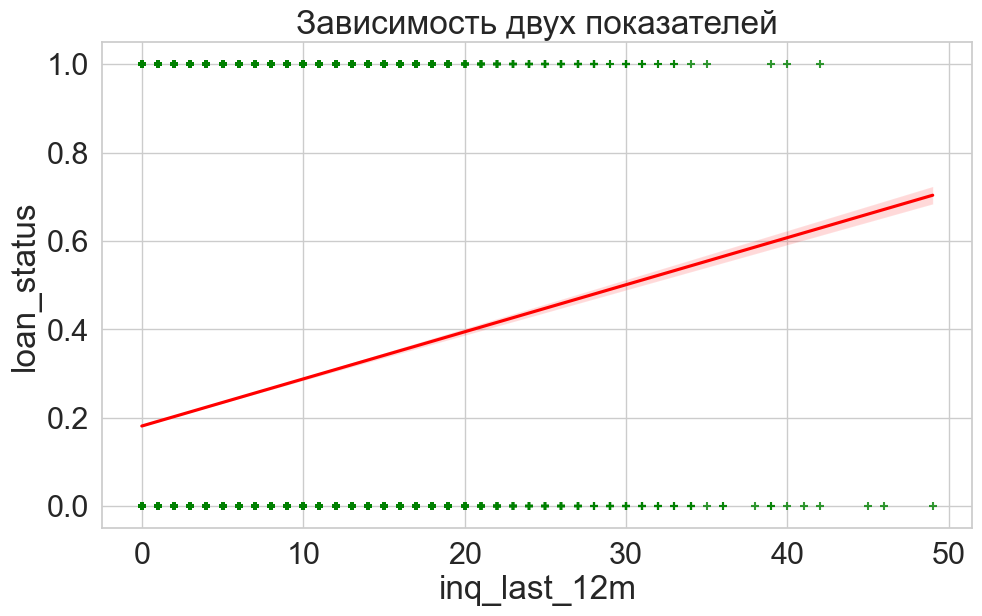

In [130]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date8.iloc[:,0], y=compare_date8.iloc[:,1], data=compare_date8, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date8.columns[0], ylabel=compare_date8.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

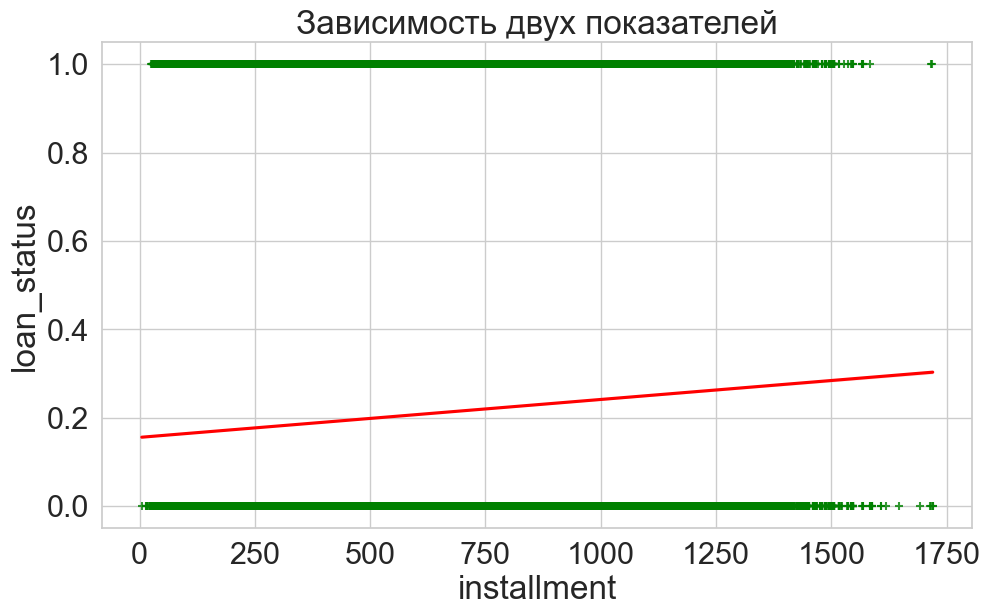

In [131]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date9.iloc[:,0], y=compare_date9.iloc[:,1], data=compare_date9, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date9.columns[0], ylabel=compare_date9.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

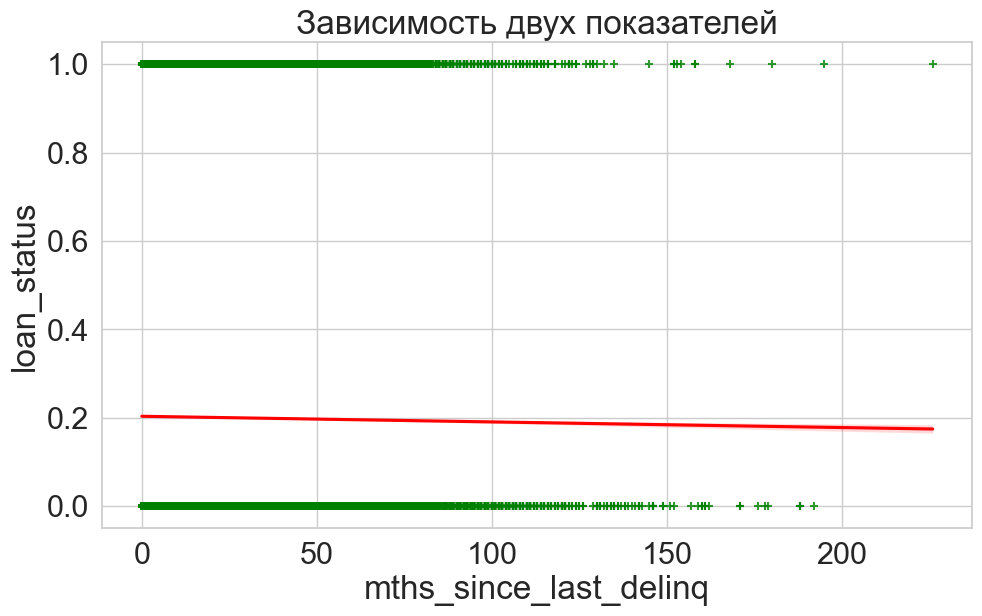

In [132]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date10.iloc[:,0], y=compare_date10.iloc[:,1], data=compare_date10, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date10.columns[0], ylabel=compare_date10.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

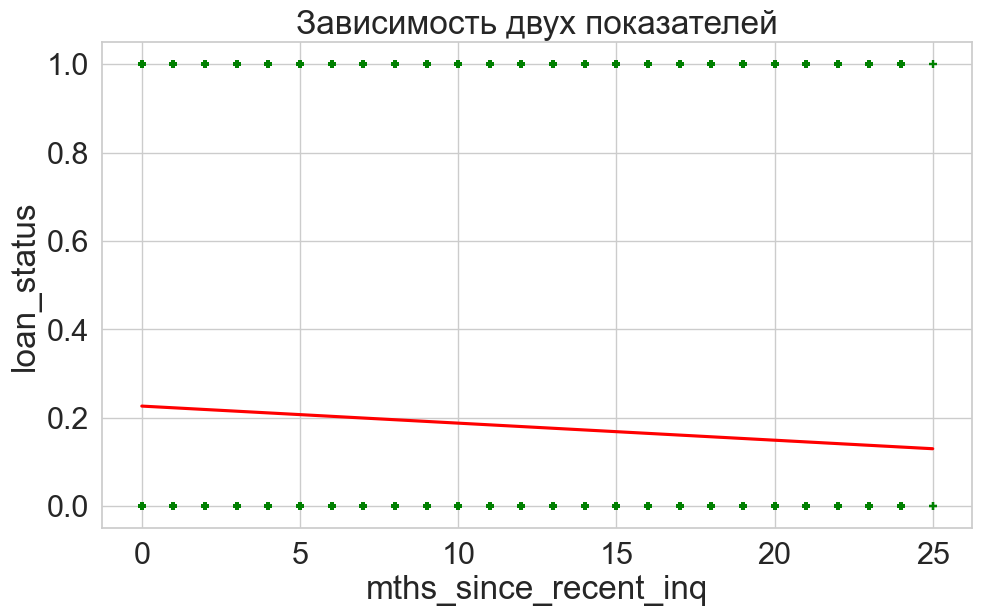

In [133]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date11.iloc[:,0], y=compare_date11.iloc[:,1], data=compare_date11, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date11.columns[0], ylabel=compare_date11.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

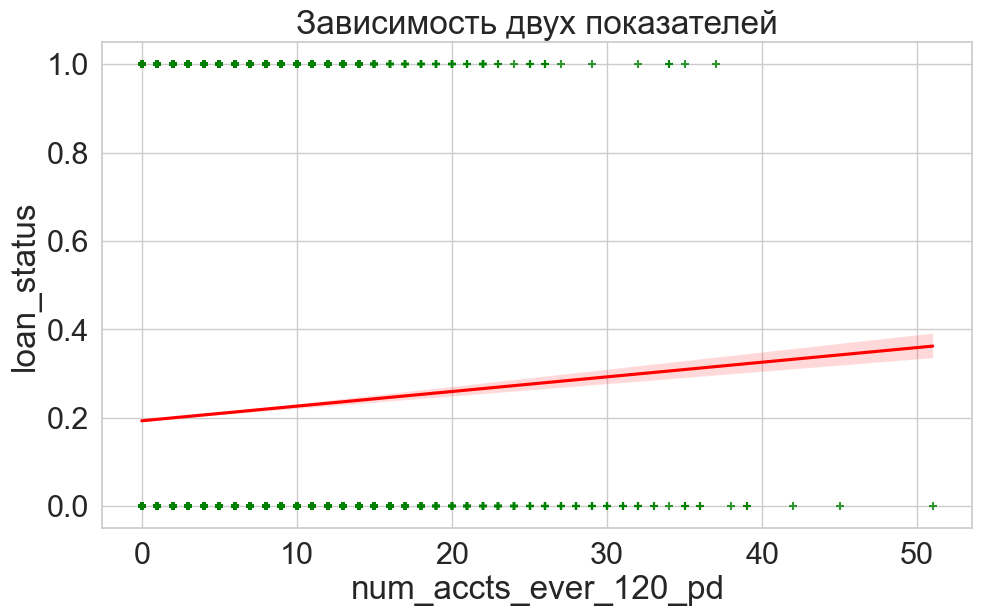

In [134]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date12.iloc[:,0], y=compare_date12.iloc[:,1], data=compare_date12, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date12.columns[0], ylabel=compare_date12.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

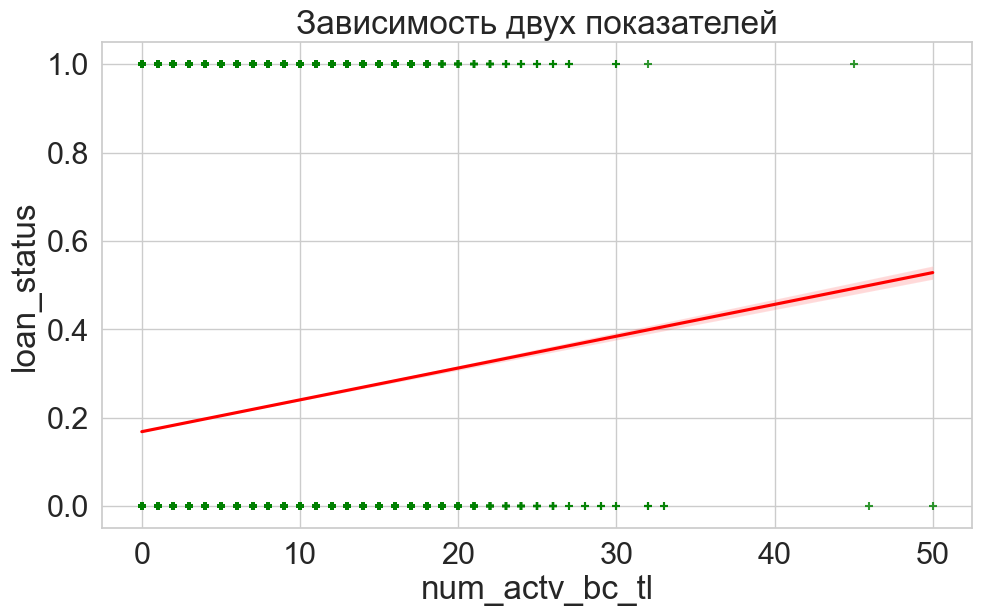

In [135]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date13.iloc[:,0], y=compare_date13.iloc[:,1], data=compare_date13, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date13.columns[0], ylabel=compare_date13.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

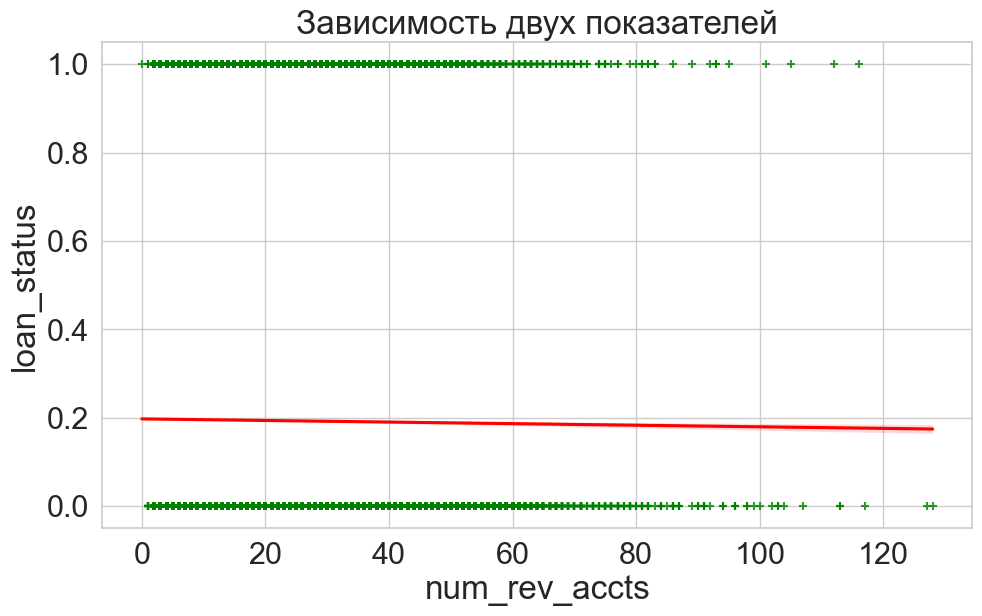

In [136]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date14.iloc[:,0], y=compare_date14.iloc[:,1], data=compare_date14, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date14.columns[0], ylabel=compare_date14.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

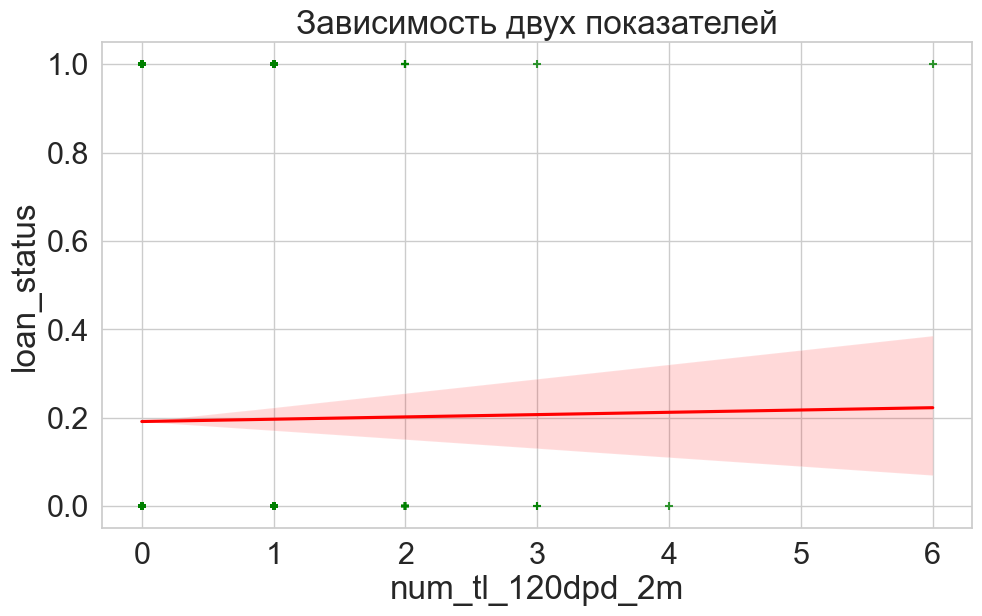

In [137]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date15.iloc[:,0], y=compare_date15.iloc[:,1], data=compare_date15, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date15.columns[0], ylabel=compare_date15.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

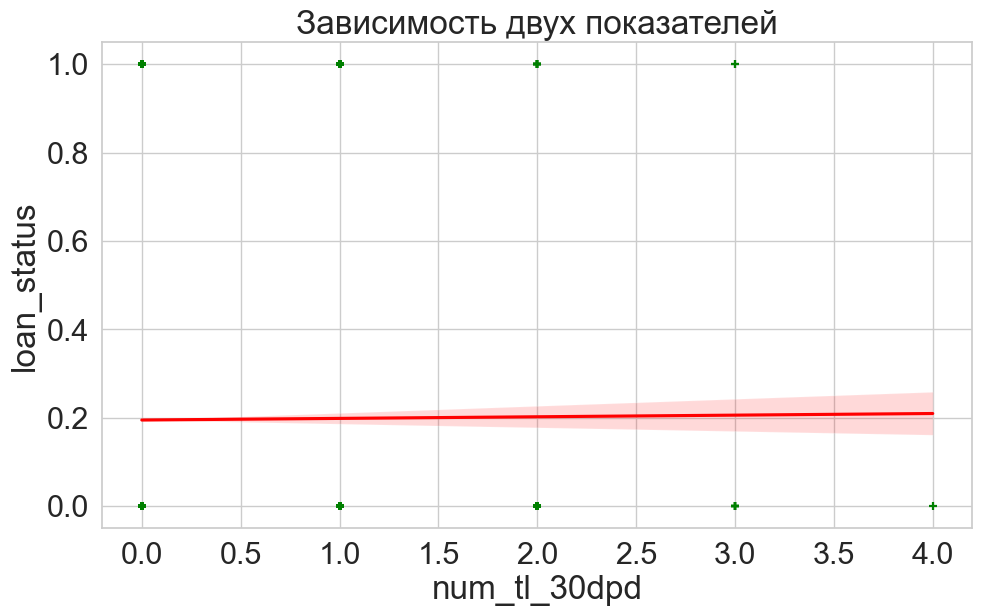

In [138]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date16.iloc[:,0], y=compare_date16.iloc[:,1], data=compare_date16, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date16.columns[0], ylabel=compare_date16.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

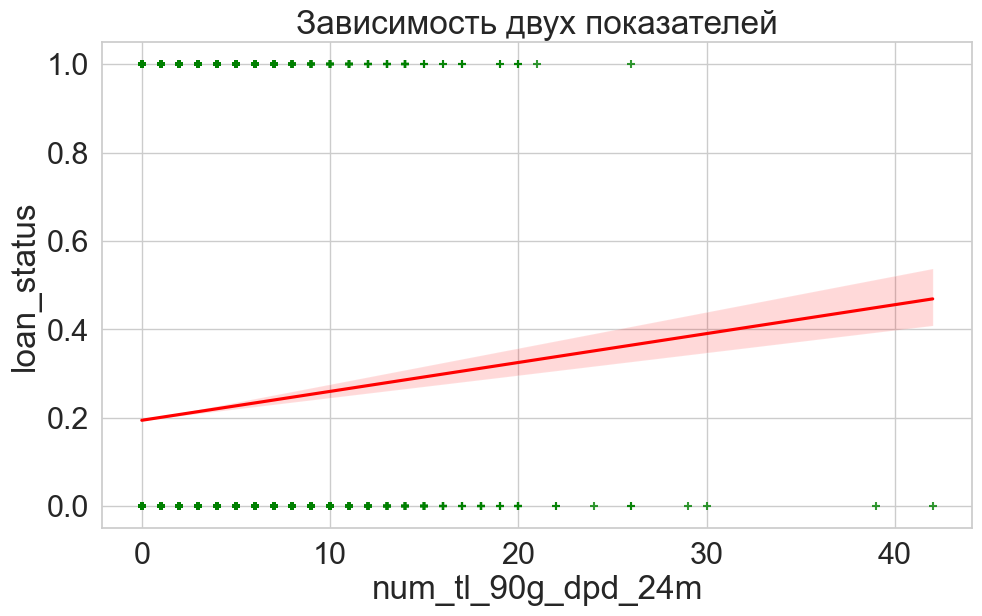

In [139]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date17.iloc[:,0], y=compare_date17.iloc[:,1], data=compare_date17, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date17.columns[0], ylabel=compare_date17.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

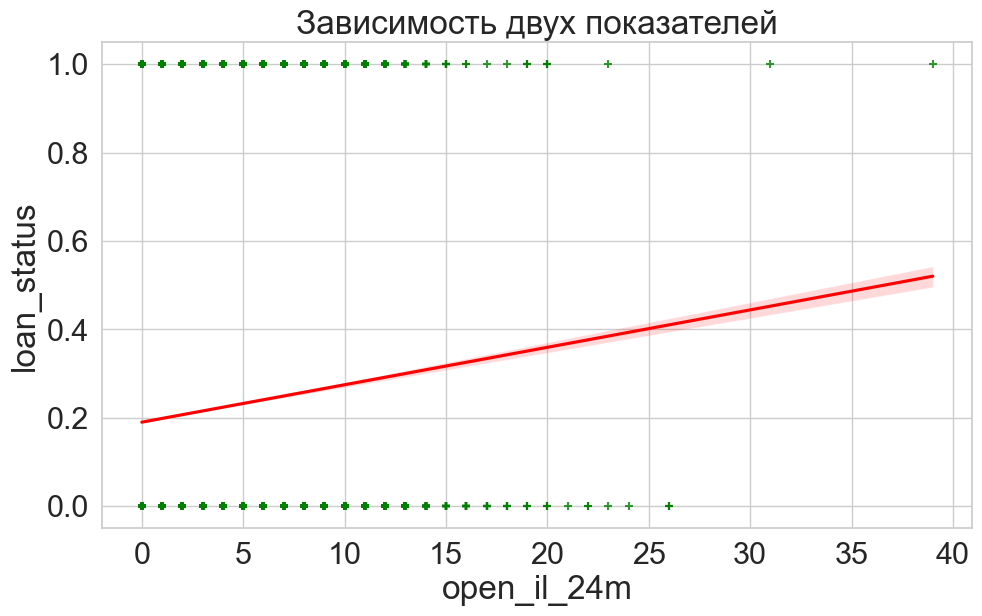

In [140]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date18.iloc[:,0], y=compare_date18.iloc[:,1], data=compare_date18, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date18.columns[0], ylabel=compare_date18.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

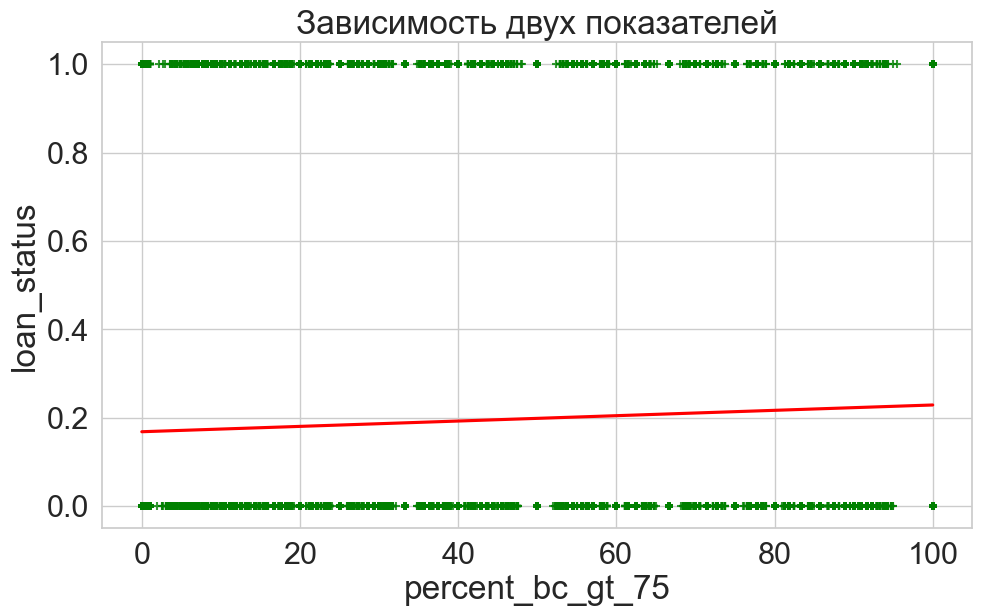

In [141]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date19.iloc[:,0], y=compare_date19.iloc[:,1], data=compare_date19, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date19.columns[0], ylabel=compare_date19.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

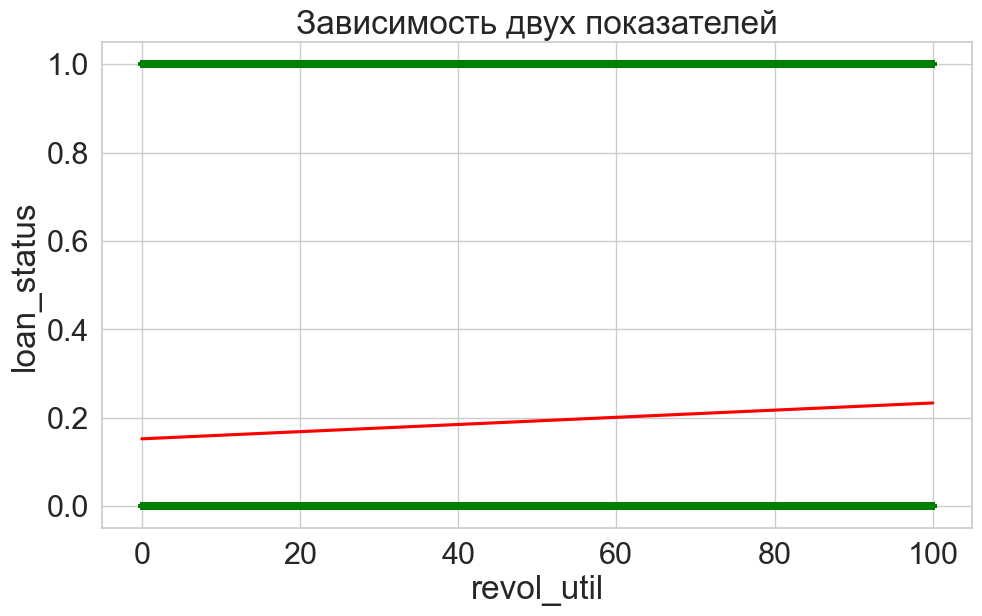

In [142]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date20.iloc[:,0], y=compare_date20.iloc[:,1], data=compare_date20, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date20.columns[0], ylabel=compare_date20.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

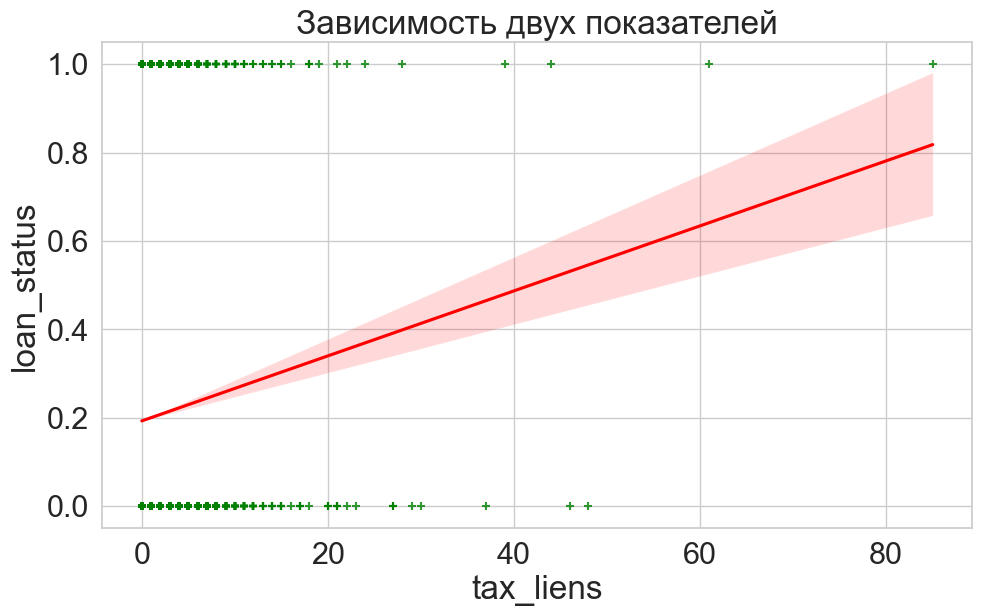

In [143]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date21.iloc[:,0], y=compare_date21.iloc[:,1], data=compare_date21, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date21.columns[0], ylabel=compare_date21.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

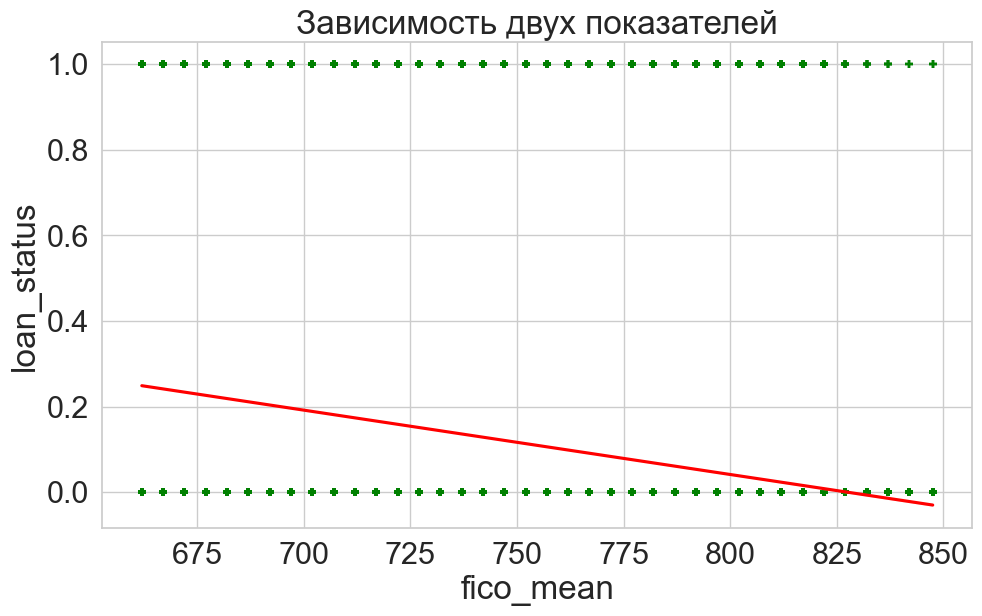

In [144]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date22.iloc[:,0], y=compare_date22.iloc[:,1], data=compare_date22, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date22.columns[0], ylabel=compare_date22.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

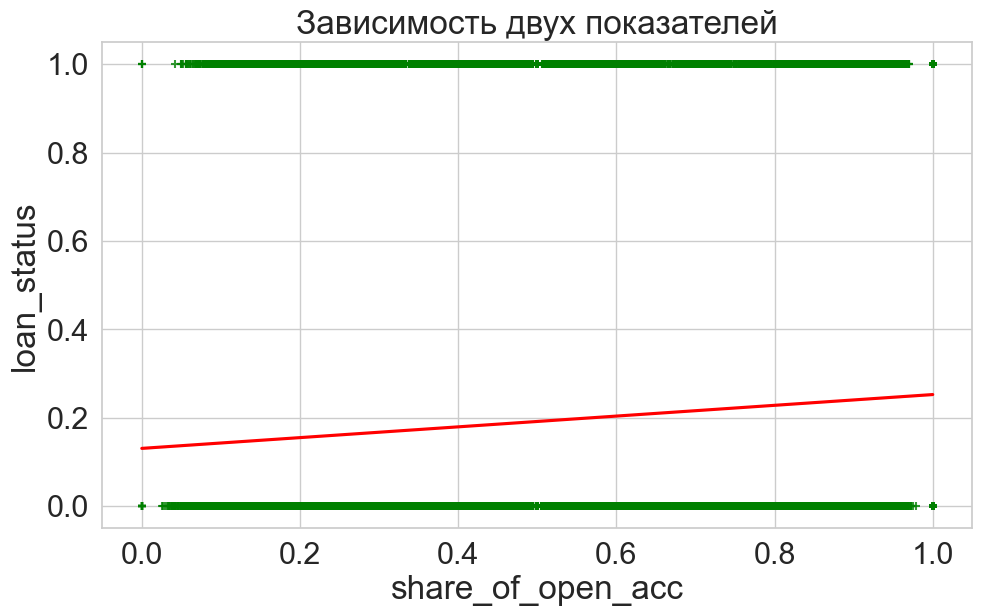

In [145]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date23.iloc[:,0], y=compare_date23.iloc[:,1], data=compare_date23, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date23.columns[0], ylabel=compare_date23.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

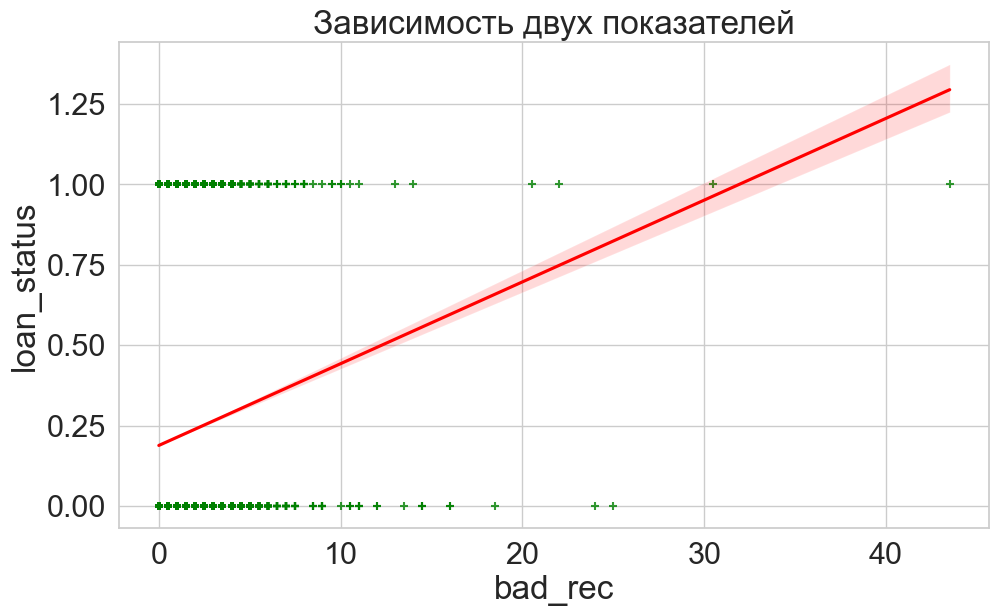

In [146]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date24.iloc[:,0], y=compare_date24.iloc[:,1], data=compare_date24, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date24.columns[0], ylabel=compare_date24.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

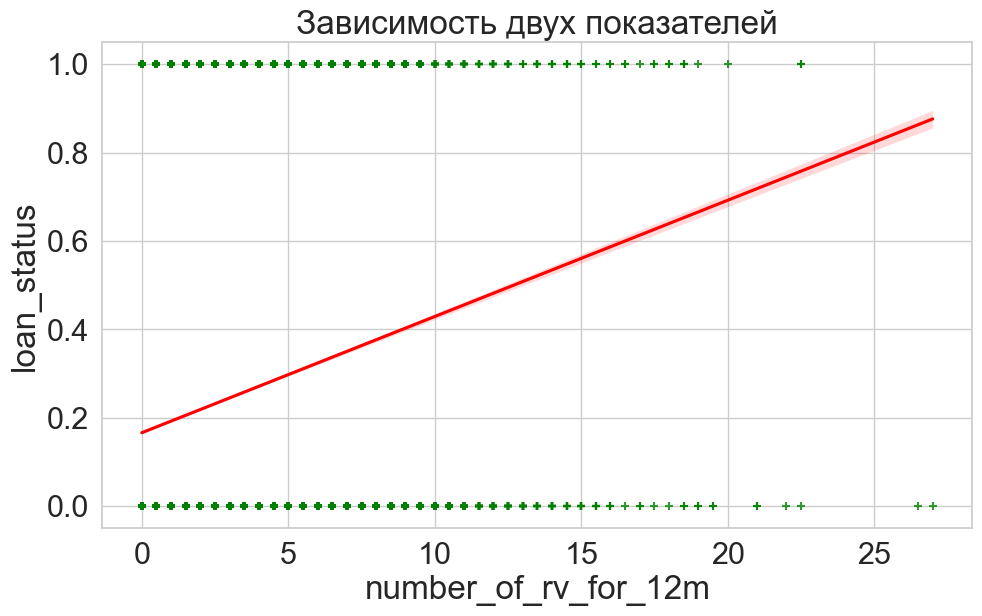

In [147]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date25.iloc[:,0], y=compare_date25.iloc[:,1], data=compare_date25, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date25.columns[0], ylabel=compare_date25.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

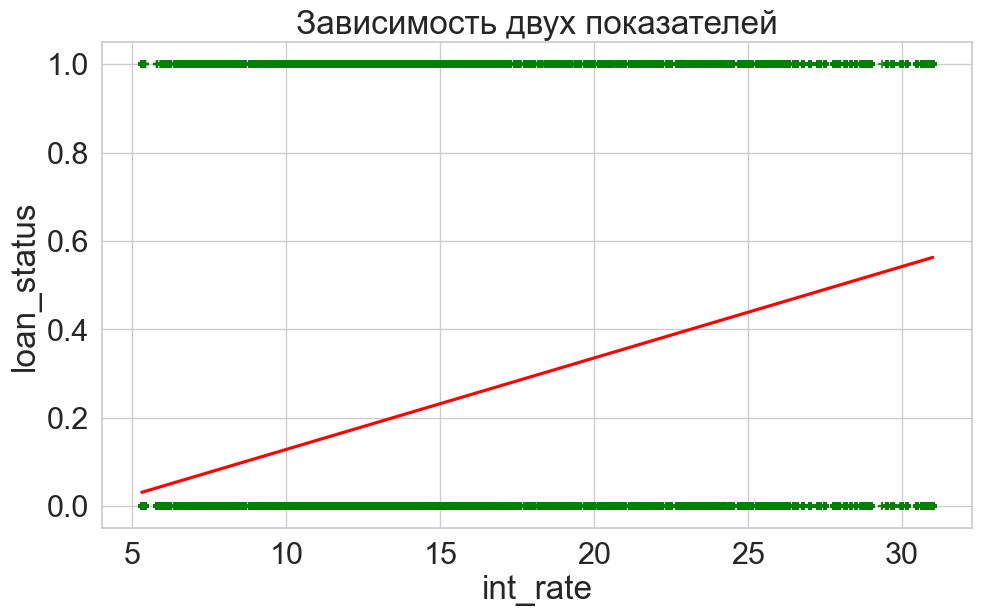

In [148]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date26.iloc[:,0], y=compare_date26.iloc[:,1], data=compare_date26, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date26.columns[0], ylabel=compare_date26.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

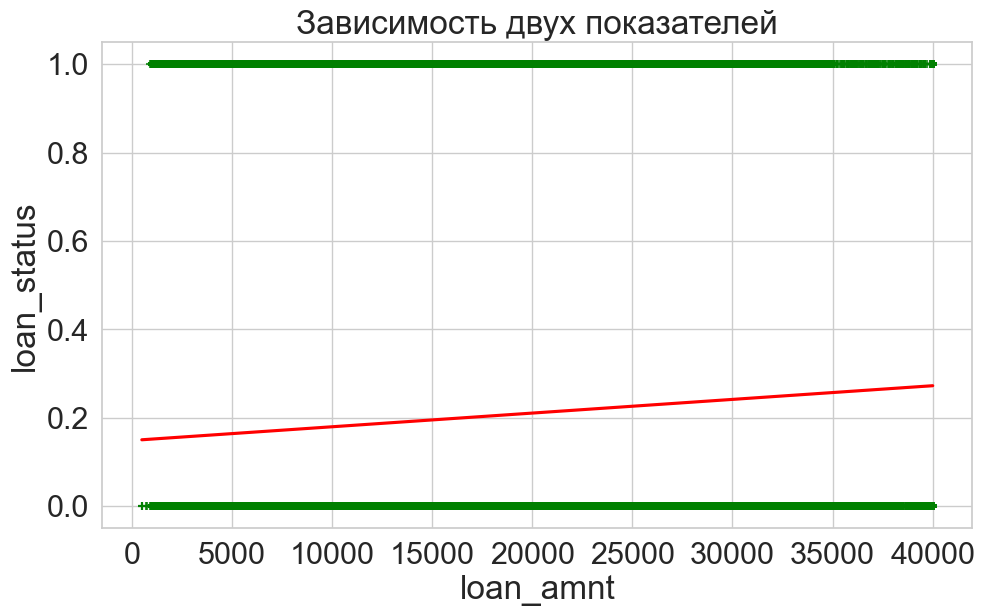

In [149]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date27.iloc[:,0], y=compare_date27.iloc[:,1], data=compare_date27, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date27.columns[0], ylabel=compare_date27.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

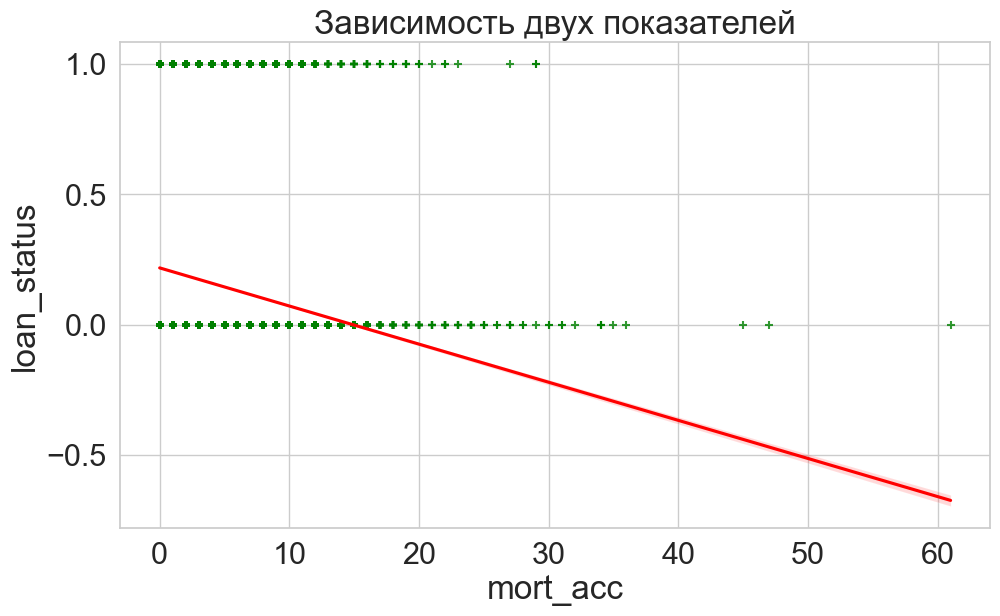

In [150]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date28.iloc[:,0], y=compare_date28.iloc[:,1], data=compare_date28, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date28.columns[0], ylabel=compare_date28.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

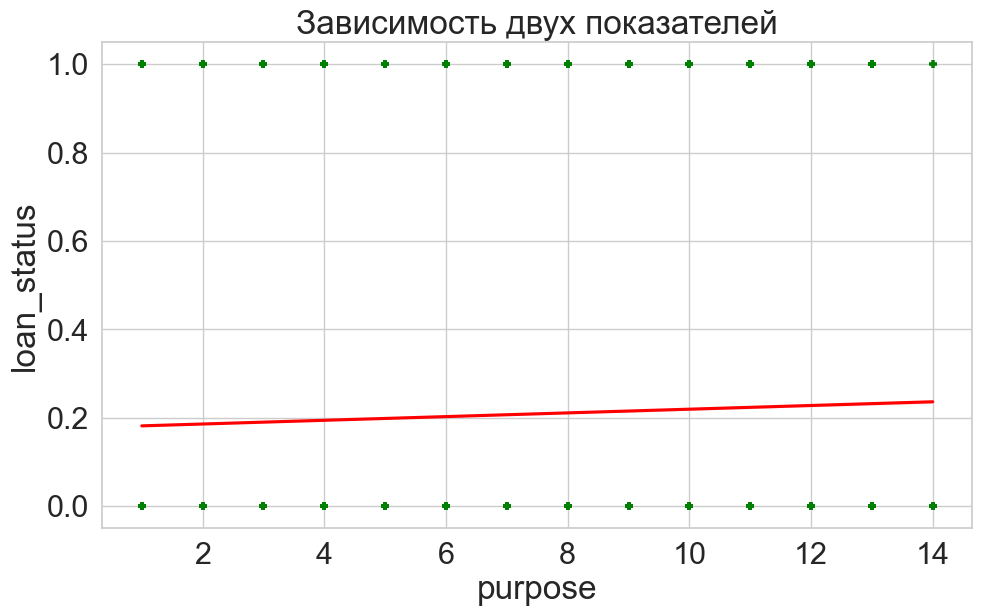

In [151]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date29.iloc[:,0], y=compare_date29.iloc[:,1], data=compare_date29, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date29.columns[0], ylabel=compare_date29.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()

In [152]:
compare_date30=df[['term','loan_status']]

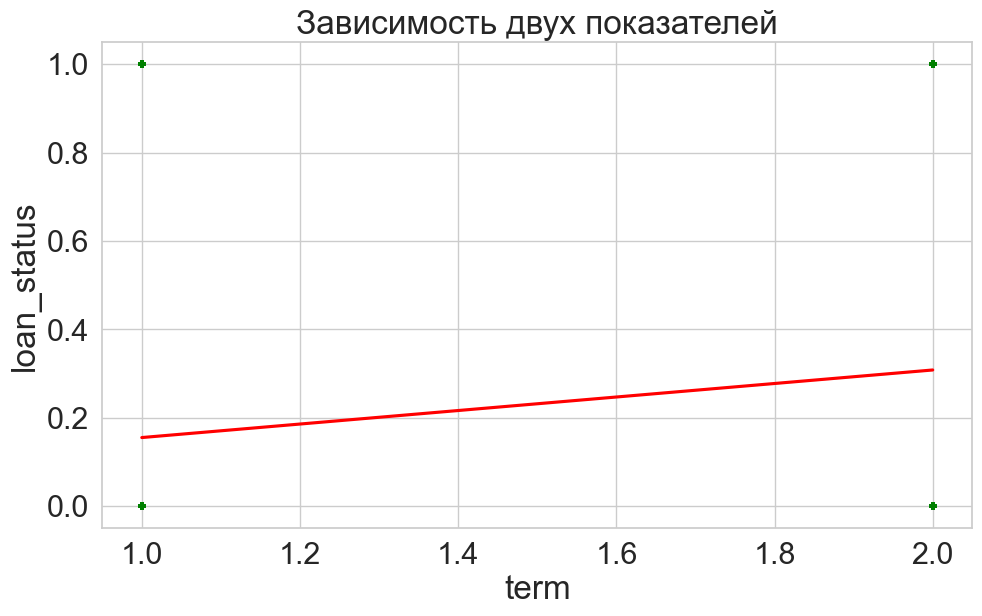

In [153]:
plt.figure(figsize=(10, 6))
ax = sns.regplot(x=compare_date30.iloc[:,0], y=compare_date30.iloc[:,1], data=compare_date30, color='green', marker='+', scatter_kws={"color": "green"}, line_kws={"color": "red"})
sns.set(font_scale=2.0)
sns.set_style('whitegrid')
ax.set(xlabel=compare_date30.columns[0], ylabel=compare_date30.columns[1])
ax.set_title('Зависимость двух показателей')
plt.show()